# Notebook 28 — Opening Recommender Model: Training Pipeline

### 0. Overview and Goals

This notebook defines the full pipeline for training the chess opening recommender model.
The objective is to predict **player–opening performance scores** ((wins + (0.5 * draws) / num games)) for openings a player hasn’t yet played, based on their results in the openings they *have* played.

The model will use **matrix factorization** with **stochastic gradient descent (SGD)** to learn latent factors representing player and opening characteristics.
All computations will be implemented in **PyTorch**, with data loaded from my local **DuckDB** database.

**High-level specs:**
- Use only *White* openings initially (we’ll extend to Black later).
- Data source: processed player–opening stats from local DuckDB.
- Predict: normalized “score” = win rate ((wins + 0.5 x draws) / total games).
- Filter: only include entries with ≥ `MIN_GAMES_THRESHOLD` (default = 10).
- Ignore: rating differences, time controls, and other metadata for the base model.
- Model parameters (to be defined in appropriate places for easy editing):
  - `NUM_FACTORS`, `LEARNING_RATE`, `BATCH_SIZE`, `N_EPOCHS`, `NUM_PLAYERS_TO_PROCESS`
- Logging and checkpoints throughout for reproducibility.
- All random operations seeded for deterministic runs.

---

### 1. Data Extraction
- Connect to local DuckDB and pull all processed player–opening statistics.
- Verify schema consistency and include row-count sanity checks.
- Filter for players with ratings above a minimum threshold (e.g., 1200).

---

### 2. Data Sanitization & Normalization
- Apply confidence weighting using hierarchical Bayesian shrinkage to adjust scores for low-game-count entries.
- Normalize player ratings (z-score) for use as side information.
- Resequence player and opening IDs to be contiguous integers for embedding layers.

---

### 3. Data Splits
- Split data into train, validation, and test sets (e.g., 75/15/10).
- Ensure splits are handled correctly to avoid data leakage.

---

### 4. Enumerate Categorical Variables
- Process ECO codes into categorical features (e.g., `eco_letter`, `eco_number`).
- Store these as opening-level side information.

---

### 5. Training Data Structure
- Convert the final, processed DataFrames into PyTorch Tensors.
- Create custom `Dataset` and `DataLoader` classes for efficient batching.

---

### 6. Cross-Validation & Hyperparameter Tuning
- Define ranges for hyperparameters (`NUM_FACTORS`, `LEARNING_RATE`, `BATCH_SIZE`).
- Perform k-fold cross-validation on a subset of the training data to find the best hyperparameter combination before the final training run.

---

### 7. Final Model Training Setup
- Define constants and hyperparameters for the final model (using results from CV).
- Instantiate the PyTorch model, optimizer (SGD), and learning rate scheduler.
- Implement helper functions for training and evaluation.

---

### 8. Final Model Training Loop
- Initialize player and opening embeddings.
- Iterate through epochs with mini-batch SGD.
- Compute and log training and validation metrics (e.g., RMSE) per epoch.
- Save model checkpoints locally.

---

### 9. Evaluation
- Evaluate the final trained model on the held-out test set.
- Report final metrics (MSE, RMSE) and create visualizations (e.g., predicted vs. actual scores).

---

### 10. Next Steps
- Extend model to include Black openings.
- Experiment with more complex architectures or hybrid inputs.
- Integrate the trained model into an API for serving recommendations.

---

**Notes:**
- Every random seed and parameter definition will be explicit.
- Every major step includes row-count, schema, and type validation.
- Model artifacts and logs will be saved locally for reproducibility.

## Step 1: Data Extraction

Connect to DuckDB and extract all player-opening statistics.
Verify schema and perform sanity checks.

In [1]:
from pathlib import Path
import pandas as pd
import sys

sys.path.append(str(Path.cwd() / 'utils'))
from database.db_utils import get_db_connection

# Configuration
DB_PATH = Path.cwd().parent / "data" / "processed" / "chess_games.db"
COLOR_FILTER = 'w'  # 'w' for white, 'b' for black
MIN_HOLDOUT_PLAYERS = 1000  # Minimum number of players to reserve for fold-in verification. These will not be used at all in this notebook for training, test/val or anything else.

print("=" * 60)
print("STEP 1: DATA EXTRACTION")
print(f"📁 Database exists: {DB_PATH.exists()}")
print(f"🎨 Color filter: {'White' if COLOR_FILTER == 'w' else 'Black'}")
print(f"🔒 Minimum holdout players: {MIN_HOLDOUT_PLAYERS:,}")

if not DB_PATH.exists():
    raise FileNotFoundError(f"Database not found at {DB_PATH}")

STEP 1: DATA EXTRACTION
📁 Database exists: True
🎨 Color filter: White
🔒 Minimum holdout players: 1,000


In [2]:
# Get our training database
con = get_db_connection(str(DB_PATH))
MAX_PLAYERS = 50_000
import numpy as np

try:
    print(f"\n1️⃣  Extracting player-opening stats (color: '{COLOR_FILTER}')...")

    # Extract stats with calculated score and num_games
    # Filter by color, minimum rating, and calculate score in the database
    MIN_RATING = 1200
    print(f"   • Minimum rating filter: {MIN_RATING}")

    print(f"\n2️⃣  Selecting holdout players for fold-in verification...")
    print(f"   • Holdout size: {MIN_HOLDOUT_PLAYERS:,} players minimum")

    player_query = f"""
        SELECT DISTINCT p.id as player_id
        FROM player p
        JOIN player_opening_stats pos ON p.id = pos.player_id
        WHERE p.rating >= {MIN_RATING}
        AND pos.color = '{COLOR_FILTER}'
        LIMIT {MAX_PLAYERS}
    """

    all_eligible_players = pd.DataFrame(con.execute(player_query).df())
    total_eligible = len(all_eligible_players)
    print(f"   • Total eligible players: {total_eligible:,}")

    if total_eligible < MIN_HOLDOUT_PLAYERS:
        raise ValueError(f"Not enough eligible players ({total_eligible:,}) to create holdout set of {MIN_HOLDOUT_PLAYERS:,}")

    # Randomly sample holdout players (deterministic with seed)
    np.random.seed(42)

    holdout_player_ids = np.random.choice(
        all_eligible_players['player_id'].values,
        size=MIN_HOLDOUT_PLAYERS,
        replace=False
    )

    training_player_ids = set(all_eligible_players['player_id'].values) - set(holdout_player_ids)

    print(f"   • Holdout players selected: {len(holdout_player_ids):,}")
    print(f"   • Training players available: {len(training_player_ids):,}")
    print(f"   • Holdout percentage: {100 * len(holdout_player_ids) / total_eligible:.1f}%")

    # SQL-friendly string
    training_player_ids_str = ','.join(map(str, training_player_ids))

    # Extract data ONLY for training players
    query = f"""
        SELECT 
            pos.player_id,
            pos.opening_id,
            pos.num_wins + pos.num_draws + pos.num_losses as num_games,
            (pos.num_wins + (pos.num_draws * 0.5)) / 
                NULLIF(pos.num_wins + pos.num_draws + pos.num_losses, 0) as score,
            o.eco
        FROM player_opening_stats pos
        JOIN opening o ON pos.opening_id = o.id
        JOIN player p ON pos.player_id = p.id
        WHERE pos.color = '{COLOR_FILTER}'
        AND p.rating >= {MIN_RATING}
        AND pos.player_id IN ({training_player_ids_str})
        ORDER BY pos.player_id, pos.opening_id
    """

    raw_data = pd.DataFrame(con.execute(query).df())

    print(f"   ✓ Extracted {len(raw_data):,} rows")

    # Also save holdout player IDs for later use
    holdout_players_df = pd.DataFrame({'player_id': holdout_player_ids})

    # Schema verification
    required_columns = ['player_id', 'opening_id', 'num_games', 'score', 'eco']

    for col in required_columns:
        if col not in raw_data.columns:
            raise ValueError(f"Missing required column: {col}")

    print(f"   ✓ All required columns present: {required_columns}")

    # Data types verification
    print(f"   • player_id: {raw_data['player_id'].dtype}")
    print(f"   • opening_id: {raw_data['opening_id'].dtype}")
    print(f"   • num_games: {raw_data['num_games'].dtype}")
    print(f"   • score: {raw_data['score'].dtype}")
    print(f"   • eco: {raw_data['eco'].dtype}")

    print("\n6️⃣  Data statistics...")
    print(f"   • Total rows: {len(raw_data):,}")
    print(f"   • Unique players: {raw_data['player_id'].nunique():,}")
    print(f"   • Unique openings: {raw_data['opening_id'].nunique():,}")
    print(f"   • Total games (sum): {raw_data['num_games'].sum():,}")

    # These won't be sequential; that's OK, we'll sequentialize them later
    print(f"\n   Player ID range:")
    print(f"   • Min: {raw_data['player_id'].min()}")
    print(f"   • Max: {raw_data['player_id'].max()}")

    # These won't be sequential; that's OK, we'll sequentialize them later
    print(f"\n   Opening ID range:")
    print(f"   • Min: {raw_data['opening_id'].min()}")
    print(f"   • Max: {raw_data['opening_id'].max()}")

    print(f"\n   Games per entry:")
    print(f"   • Min: {raw_data['num_games'].min()}")
    print(f"   • Max: {raw_data['num_games'].max()}")
    print(f"   • Mean: {raw_data['num_games'].mean():.1f}")
    print(f"   • Median: {raw_data['num_games'].median():.0f}")

    print(f"\n   Score distribution:")
    print(f"   • Min: {raw_data['score'].min():.4f}")
    print(f"   • Max: {raw_data['score'].max():.4f}")
    print(f"   • Mean: {raw_data['score'].mean():.4f}")
    print(f"   • Median: {raw_data['score'].median():.4f}")

    print("\n7️⃣  Checking for null values...")
    null_counts = raw_data.isnull().sum()
    if null_counts.sum() == 0:
        print("   ✓ No null values found")
    else:
        print("   ⚠️  Found null values:")
        for col, count in null_counts[null_counts > 0].items():
            print(f"      • {col}: {count} nulls")

    print("\n8️⃣  Sample of extracted data (first 10 rows):")
    print(raw_data.head(10).to_string())

    print("\n" + "=" * 60)
    print("✅ DATA EXTRACTION COMPLETE")
    print("=" * 60)
    print(f"\nData shape: {raw_data.shape}")
    print(f"Columns: {list(raw_data.columns)}")

finally:
    con.close()
    print("\n✓ Database connection closed")


1️⃣  Extracting player-opening stats (color: 'w')...
   • Minimum rating filter: 1200

2️⃣  Selecting holdout players for fold-in verification...
   • Holdout size: 1,000 players minimum
   • Total eligible players: 49,551
   • Holdout players selected: 1,000
   • Training players available: 48,551
   • Holdout percentage: 2.0%
   • Total eligible players: 49,551
   • Holdout players selected: 1,000
   • Training players available: 48,551
   • Holdout percentage: 2.0%


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   ✓ Extracted 11,567,358 rows
   ✓ All required columns present: ['player_id', 'opening_id', 'num_games', 'score', 'eco']
   • player_id: int32
   • opening_id: int32
   • num_games: int32
   • score: float64
   • eco: object

6️⃣  Data statistics...
   • Total rows: 11,567,358
   • Unique players: 48,551
   • Unique openings: 2,991
   • Total games (sum): 228,918,732

   Player ID range:
   • Min: 1
   • Max: 50000

   Opening ID range:
   • Min: 2
   • Max: 3589

   Games per entry:
   • Min: 1
   • Max: 13462
   • Mean: 19.8
   • Unique openings: 2,991
   • Total games (sum): 228,918,732

   Player ID range:
   • Min: 1
   • Max: 50000

   Opening ID range:
   • Min: 2
   • Max: 3589

   Games per entry:
   • Min: 1
   • Max: 13462
   • Mean: 19.8
   • Median: 3

   Score distribution:
   • Min: 0.0000
   • Max: 1.0000
   • Mean: 0.5007
   • Median: 3

   Score distribution:
   • Min: 0.0000
   • Max: 1.0000
   • Mean: 0.5007
   • Median: 0.5000

7️⃣  Checking for null values...
  

## Step 2: Data Sanitization & Normalization

Filter low-quality data, handle duplicates, and prepare for training.

In [3]:
# 2a. Filter low-quality data, handle duplicates, and prepare for training.

# Configuration
MIN_GAMES_THRESHOLD = 10

print("STEP 2: DATA SANITIZATION & NORMALIZATION")

# Start with raw_data from Step 1
print(f"\n📊 Starting data shape: {raw_data.shape}")
print(f"   • Rows: {len(raw_data):,}")
print(f"   • Unique players: {raw_data['player_id'].nunique():,}")
print(f"   • Unique openings: {raw_data['opening_id'].nunique():,}")

# 1. Filter by minimum games threshold
print(f"\n1️⃣  Filtering entries with < {MIN_GAMES_THRESHOLD} games...")
before_filter = len(raw_data)
clean_data = raw_data.query(f'num_games >= {MIN_GAMES_THRESHOLD}').copy()
num_rows_after_filter = len(clean_data)
num_rows_filtered_out = before_filter - num_rows_after_filter

print(f"   • Before: {before_filter:,} rows")
print(f"   • After: {num_rows_after_filter:,} rows")
print(f"   • Filtered out: {num_rows_filtered_out:,} rows ({100*num_rows_filtered_out/before_filter:.1f}%)")

# 2. Check for duplicates
num_duplicates = clean_data.duplicated(subset=['player_id', 'opening_id']).sum()

if num_duplicates > 0:
    print(f"   ⚠️  Found {num_duplicates} duplicate player-opening entries")
    dup_mask = clean_data.duplicated(subset=['player_id', 'opening_id'], keep=False)
    print("\n   Sample of duplicates:")
    print(clean_data[dup_mask].head(10).to_string())
    
    # Keep only first occurrence of any duplicate player-opening pair
    print("\n   Removing duplicates (keeping first occurrence)...")
    clean_data = pd.DataFrame.drop_duplicates(clean_data, subset=['player_id', 'opening_id'], keep='first')
    print(f"   ✓ After deduplication: {len(clean_data):,} rows")

# 3. Remove players with no qualifying openings

# Note that a few players only play stuff like the Van't Kruijs which we've excluded, so a small numer of players will be excluded here
players_before = clean_data['player_id'].nunique()

# Count openings per player
num_openings_per_player = pd.DataFrame(clean_data.groupby('player_id').size(), columns=['count'])
players_with_data = num_openings_per_player[num_openings_per_player['count'] > 0].index.tolist()

# Filter
clean_data = clean_data[clean_data['player_id'].isin(players_with_data)]
players_after = clean_data['player_id'].nunique()

# 4. Remove openings with no qualifying players
num_openings_before = clean_data['opening_id'].nunique()

num_players_per_opening = pd.DataFrame(clean_data.groupby('opening_id').size(), columns=['count'])
openings_with_data = num_players_per_opening[num_players_per_opening['count'] > 0].index.tolist()

clean_data = clean_data[clean_data['opening_id'].isin(openings_with_data)]
openings_after = clean_data['opening_id'].nunique()

# 5. Verify no null values using pd.isna()
null_counts = pd.DataFrame.isna(clean_data).sum()
if null_counts.sum() == 0:
    print("   ✓ No null values found")
else:
    print("   ⚠️  Found null values:")
    for col, count in null_counts[null_counts > 0].items():
        print(f"      • {col}: {count} nulls")
    # Drop rows with nulls using pd.DataFrame.dropna()
    clean_data = pd.DataFrame.dropna(clean_data)
    print(f"   ✓ Dropped null rows. New shape: {clean_data.shape}")

# Reset index using pd.DataFrame.reset_index()
clean_data = pd.DataFrame.reset_index(clean_data, drop=True)

# Final statistics using pd functions
print(f"\n6️⃣  Data statistics:")
print(f"   • Total rows: {len(clean_data):,}")
print(f"   • Unique players: {pd.Series.nunique(clean_data['player_id']):,}")
print(f"   • Unique openings: {pd.Series.nunique(clean_data['opening_id']):,}")
print(f"   • Total games: {pd.Series.sum(clean_data['num_games']):,}")
print(f"   • Avg games per entry: {pd.Series.mean(clean_data['num_games']):.1f}")
print(f"   • Avg openings per player: {len(clean_data) / pd.Series.nunique(clean_data['player_id']):.1f}")
print(f"   • Avg players per opening: {len(clean_data) / pd.Series.nunique(clean_data['opening_id']):.1f}")

# Score distribution using pd functions
print(f"\n   Score statistics:")
print(f"   • Min: {pd.Series.min(clean_data['score']):.4f}")
print(f"   • 25th percentile: {pd.Series.quantile(clean_data['score'], 0.25):.4f}")
print(f"   • Median: {pd.Series.median(clean_data['score']):.4f}")
print(f"   • 75th percentile: {pd.Series.quantile(clean_data['score'], 0.75):.4f}")
print(f"   • Max: {pd.Series.max(clean_data['score']):.4f}")
print(f"   • Mean: {pd.Series.mean(clean_data['score']):.4f}")
print(f"   • Std: {pd.Series.std(clean_data['score']):.4f}")

# Sample of cleaned data using pd.DataFrame.sample()
print(f"\n7️⃣  Sample of cleaned data (10 random rows):")
print(pd.DataFrame.sample(clean_data, min(10, len(clean_data)), random_state=42).to_string())

print("\n" + "=" * 60)
print("✅ DATA SANITIZATION COMPLETE")
print("=" * 60)
print(f"\nCleaned data shape: {clean_data.shape}")
print(f"Data reduction: {100 * (1 - len(clean_data)/len(raw_data)):.1f}%")

STEP 2: DATA SANITIZATION & NORMALIZATION

📊 Starting data shape: (11567358, 5)
   • Rows: 11,567,358
   • Unique players: 48,551
   • Unique openings: 2,991

1️⃣  Filtering entries with < 10 games...
   • Unique openings: 2,991

1️⃣  Filtering entries with < 10 games...
   • Before: 11,567,358 rows
   • After: 2,897,700 rows
   • Filtered out: 8,669,658 rows (74.9%)
   • Before: 11,567,358 rows
   • After: 2,897,700 rows
   • Filtered out: 8,669,658 rows (74.9%)
   ✓ No null values found

6️⃣  Data statistics:
   • Total rows: 2,897,700
   • Unique players: 48,468
   • Unique openings: 2,717
   • Total games: 206,320,314
   • Avg games per entry: 71.2
   ✓ No null values found

6️⃣  Data statistics:
   • Total rows: 2,897,700
   • Unique players: 48,468
   • Unique openings: 2,717
   • Total games: 206,320,314
   • Avg games per entry: 71.2
   • Avg openings per player: 59.8
   • Avg players per opening: 1066.5

   Score statistics:
   • Min: 0.0000
   • 25th percentile: 0.4500
   • M

In [4]:
# 2b. Apply hierarchical Bayesian shrinkage to adjust scores based on sample size confidence

# Check if confidence already exists - if so, skip this processing
if 'confidence' in clean_data.columns:
    print("=" * 60)
    print("⏭️  SKIPPING STEP 2B: HIERARCHICAL BAYESIAN SCORE ADJUSTMENT")
    print("=" * 60)
    print("\n✓ 'confidence' column already exists in data")
else:
    # Define the processing function
    # This is a long function, I recommend you fold it down in your editor
    def apply_hierarchical_bayesian_shrinkage(data, k_player=50):
        """
        Apply two-level hierarchical Bayesian shrinkage to adjust scores.
        
        A lot of our player-opening entries have a small number of games played, because openings are so specific.
        This introduces sample size issues.
        
        We use TWO-LEVEL shrinkage:
        Level 1: Calculate opening-specific means (these are our "ground truth" for each opening)
        Level 2: Shrink individual player-opening scores toward their opening's mean
        This is better than shrinking toward global mean because different openings have different baseline win rates
        
        Parameters:
        -----------
        data : pd.DataFrame
            Clean data with columns: player_id, opening_id, score, num_games, eco
        k_player : int
            Shrinkage constant for player-opening scores (default: 50)
            
        Returns:
        --------
        pd.DataFrame
            Data with adjusted scores and new 'confidence' column
        """
        print("=" * 60)
        print("STEP 2B: HIERARCHICAL BAYESIAN SCORE ADJUSTMENT")
        print("=" * 60)

        # Calculate global mean score for comparison
        global_mean_score = data["score"].mean()
        print(f"\n📊 Global statistics:")
        print(f"   • Global mean score: {global_mean_score:.4f}")
        print(f"   • Total entries: {len(data):,}")
        print(f"   • Unique openings: {data['opening_id'].nunique():,}")
        
        # Store original scores for comparison
        data = data.copy()
        data["score_original"] = data["score"].copy()
        
        # LEVEL 1: Calculate opening-specific means and statistics        
        opening_stats = (
            data.groupby("opening_id")
            .agg(
                {
                    "score": "mean",
                    "num_games": "sum",
                    "player_id": "count",  # Number of players who played this opening
                }
            )
            .rename(
                columns={
                    "score": "opening_mean",
                    "num_games": "opening_total_games",
                    "player_id": "opening_num_players",
                }
            )
        )
                
        # Opening mean statistics
        print(f"\n   Opening mean score distribution:")
        print(f"   • Min: {opening_stats['opening_mean'].min():.4f}")
        print(f"   • 25th percentile: {opening_stats['opening_mean'].quantile(0.25):.4f}")
        print(f"   • Median: {opening_stats['opening_mean'].median():.4f}")
        print(f"   • 75th percentile: {opening_stats['opening_mean'].quantile(0.75):.4f}")
        print(f"   • Max: {opening_stats['opening_mean'].max():.4f}")
        print(f"   • Std: {opening_stats['opening_mean'].std():.4f}")
        
        # Show distribution of opening sizes
        print(f"\n   Opening sample size distribution:")
        print(
            f"   • Total games per opening (median): {opening_stats['opening_total_games'].median():.0f}"
        )
        print(
            f"   • Players per opening (median): {opening_stats['opening_num_players'].median():.0f}"
        )
        print(
            f"   • Total games range: [{opening_stats['opening_total_games'].min():.0f}, {opening_stats['opening_total_games'].max():.0f}]"
        )
        print(
            f"   • Players range: [{opening_stats['opening_num_players'].min():.0f}, {opening_stats['opening_num_players'].max():.0f}]"
        )
        
        # Merge opening means back into main dataframe
        data = data.merge(
            opening_stats[["opening_mean"]], left_on="opening_id", right_index=True, how="left"
        )
        
        # LEVEL 2: Shrink player-opening scores toward opening-specific means
        print(
            f"   Formula: adjusted_score = (num_games × player_score + {k_player} × opening_mean) / (num_games + {k_player})"
        )
        
        numerator = (data["num_games"] * data["score_original"]) + (
            k_player * data["opening_mean"]
        )
        denominator = data["num_games"] + k_player
        data["score"] = numerator / denominator
        
        print(f"   ✓ Scores adjusted for {len(data):,} entries")
        
        # Calculate confidence weights (will be used in loss function later)
        data["confidence"] = data["num_games"] / (
            data["num_games"] + k_player
        )
        print(f"   ✓ Confidence weights calculated")
        print(
            f"   • Range: [{data['confidence'].min():.4f}, {data['confidence'].max():.4f}]"
        )
        
        # Statistics on the adjustment
        score_diff = data["score"] - data["score_original"]
        print(f"\n4️⃣  Adjustment statistics:")
        print(f"   • Mean adjustment: {score_diff.mean():.6f}")
        print(f"   • Std adjustment: {score_diff.std():.6f}")
        print(f"   • Max adjustment: {score_diff.max():.6f}")
        print(f"   • Min adjustment: {score_diff.min():.6f}")
        
        # Show distribution of adjustments
        print(f"\n   Adjustment by num_games quartiles:")
        quartiles = data["num_games"].quantile([0.25, 0.5, 0.75])
        print(
            f"   • 25th percentile (n={quartiles[0.25]:.0f} games): avg adjustment = {score_diff[data['num_games'] <= quartiles[0.25]].mean():.6f}"
        )
        print(
            f"   • 50th percentile (n={quartiles[0.5]:.0f} games): avg adjustment = {score_diff[(data['num_games'] > quartiles[0.25]) & (data['num_games'] <= quartiles[0.5])].mean():.6f}"
        )
        print(
            f"   • 75th percentile (n={quartiles[0.75]:.0f} games): avg adjustment = {score_diff[(data['num_games'] > quartiles[0.5]) & (data['num_games'] <= quartiles[0.75])].mean():.6f}"
        )
        print(
            f"   • >75th percentile (n>{quartiles[0.75]:.0f} games): avg adjustment = {score_diff[data['num_games'] > quartiles[0.75]].mean():.6f}"
        )
        
        # New score distribution after adjustment
        print(f"\n5️⃣  Adjusted score statistics:")
        print(f"   • Min: {data['score'].min():.4f}")
        print(f"   • 25th percentile: {data['score'].quantile(0.25):.4f}")
        print(f"   • Median: {data['score'].median():.4f}")
        print(f"   • 75th percentile: {data['score'].quantile(0.75):.4f}")
        print(f"   • Max: {data['score'].max():.4f}")
        print(f"   • Mean: {data['score'].mean():.4f}")
        print(f"   • Std: {data['score'].std():.4f}")
        
        # Detailed sample showing the effect across different game counts
        print(f"\n6️⃣  Sample comparisons (showing effect of hierarchical shrinkage):")
        print(f"\n   {'='*120}")
        print(f"   Low-game entries (10-20 games) - HIGH shrinkage toward opening mean:")
        print(f"   {'='*120}")
        
        low_game_sample = data[
            (data["num_games"] >= 10) & (data["num_games"] <= 20)
        ].sample(
            min(
                10,
                len(
                    data[
                        (data["num_games"] >= 10) & (data["num_games"] <= 20)
                    ]
                ),
            ),
            random_state=42,
        )
        for idx, row in low_game_sample.iterrows():
            adjustment = row["score"] - row["score_original"]
            print(
                f"   Player {row['player_id']:>5} | Opening {row['opening_id']:>4} | Games: {row['num_games']:>3} | "
                f"Opening mean: {row['opening_mean']:.4f} | Original: {row['score_original']:.4f} → Adjusted: {row['score']:.4f} | "
                f"Diff: {adjustment:>+.4f} | Confidence: {row['confidence']:.3f}"
            )
        
        print(f"\n   {'='*120}")
        print(f"   Medium-game entries (50-100 games) - MODERATE shrinkage:")
        print(f"   {'='*120}")
        
        med_game_sample = data[
            (data["num_games"] >= 50) & (data["num_games"] <= 100)
        ].sample(
            min(
                10,
                len(
                    data[
                        (data["num_games"] >= 50) & (data["num_games"] <= 100)
                    ]
                ),
            ),
            random_state=42,
        )
        for idx, row in med_game_sample.iterrows():
            adjustment = row["score"] - row["score_original"]
            print(
                f"   Player {row['player_id']:>5} | Opening {row['opening_id']:>4} | Games: {row['num_games']:>3} | "
                f"Opening mean: {row['opening_mean']:.4f} | Original: {row['score_original']:.4f} → Adjusted: {row['score']:.4f} | "
                f"Diff: {adjustment:>+.4f} | Confidence: {row['confidence']:.3f}"
            )
        
        print(f"\n   {'='*120}")
        print(f"   High-game entries (200+ games) - LOW shrinkage:")
        print(f"   {'='*120}")
        
        high_game_sample = data[data["num_games"] >= 200].sample(
            min(10, len(data[data["num_games"] >= 200])), random_state=42
        )
        for idx, row in high_game_sample.iterrows():
            adjustment = row["score"] - row["score_original"]
            print(
                f"   Player {row['player_id']:>5} | Opening {row['opening_id']:>4} | Games: {row['num_games']:>3} | "
                f"Opening mean: {row['opening_mean']:.4f} | Original: {row['score_original']:.4f} → Adjusted: {row['score']:.4f} | "
                f"Diff: {adjustment:>+.4f} | Confidence: {row['confidence']:.3f}"
            )
        
        # Show extreme cases - comparing to both opening mean AND global mean
        print(f"\n7️⃣  Extreme cases (showing why opening-specific shrinkage matters):")
        
        # Find entries where opening mean differs significantly from global mean
        data["opening_deviation_from_global"] = (
            data["opening_mean"] - global_mean_score
        ).abs()
        
        print(f"\n   Openings with HIGHEST win rates (strong for White):")
        strong_openings = data.nlargest(5, "opening_mean")[
            ["opening_id", "opening_mean", "eco"]
        ].drop_duplicates("opening_id")
        for idx, row in strong_openings.iterrows():
            num_entries = len(data[data["opening_id"] == row["opening_id"]])
            deviation = row["opening_mean"] - global_mean_score
            print(
                f"   Opening {row['opening_id']:>4} ({row['eco']:>3}): mean = {row['opening_mean']:.4f} "
                f"(+{deviation:.4f} vs global) | {num_entries} player entries"
            )
        
        print(f"\n   Openings with LOWEST win rates (weak for White):")
        weak_openings = data.nsmallest(5, "opening_mean")[
            ["opening_id", "opening_mean", "eco"]
        ].drop_duplicates("opening_id")
        for idx, row in weak_openings.iterrows():
            num_entries = len(data[data["opening_id"] == row["opening_id"]])
            deviation = row["opening_mean"] - global_mean_score
            print(
                f"   Opening {row['opening_id']:>4} ({row['eco']:>3}): mean = {row['opening_mean']:.4f} "
                f"({deviation:.4f} vs global) | {num_entries} player entries"
            )
        
        # Show specific examples where hierarchical shrinkage made a difference
        print(f"\n8️⃣  Examples showing hierarchical shrinkage benefit:")
        
        # Find entries with strong openings where player did well
        strong_opening_ids = data.nlargest(50, "opening_mean")["opening_id"].unique()
        strong_examples = data[
            (data["opening_id"].isin(strong_opening_ids))
            & (data["num_games"] <= 20)
            & (data["score_original"] > 0.6)
        ].sample(
            min(
                3,
                len(
                    data[
                        (data["opening_id"].isin(strong_opening_ids))
                        & (data["num_games"] <= 20)
                        & (data["score_original"] > 0.6)
                    ]
                ),
            ),
            random_state=42,
        )
        
        print(
            f"\n   Strong opening + good player performance (shrunk toward HIGH opening mean):"
        )
        for idx, row in strong_examples.iterrows():
            adjustment = row["score"] - row["score_original"]
            global_shrink_would_be = (
                (row["num_games"] * row["score_original"]) + (k_player * global_mean_score)
            ) / (row["num_games"] + k_player)
            difference = row["score"] - global_shrink_would_be
            print(
                f"   Player {row['player_id']:>5} | Opening {row['opening_id']:>4} ({row['eco']:>3}) | Games: {row['num_games']:>2} | "
                f"Opening mean: {row['opening_mean']:.4f} | Original: {row['score_original']:.4f} → {row['score']:.4f}"
            )
            print(
                f"      If we'd shrunk to global mean: {global_shrink_would_be:.4f} (would lose {difference:+.4f} of deserved credit)"
            )
        
        # Find entries with weak openings where player did poorly
        weak_opening_ids = data.nsmallest(50, "opening_mean")["opening_id"].unique()
        weak_examples = data[
            (data["opening_id"].isin(weak_opening_ids))
            & (data["num_games"] <= 20)
            & (data["score_original"] < 0.45)
        ].sample(
            min(
                3,
                len(
                    data[
                        (data["opening_id"].isin(weak_opening_ids))
                        & (data["num_games"] <= 20)
                        & (data["score_original"] < 0.45)
                    ]
                ),
            ),
            random_state=42,
        )
        
        print(f"\n   Weak opening + poor player performance (shrunk toward LOW opening mean):")
        for idx, row in weak_examples.iterrows():
            adjustment = row["score"] - row["score_original"]
            global_shrink_would_be = (
                (row["num_games"] * row["score_original"]) + (k_player * global_mean_score)
            ) / (row["num_games"] + k_player)
            difference = row["score"] - global_shrink_would_be
            print(
                f"   Player {row['player_id']:>5} | Opening {row['opening_id']:>4} ({row['eco']:>3}) | Games: {row['num_games']:>2} | "
                f"Opening mean: {row['opening_mean']:.4f} | Original: {row['score_original']:.4f} → {row['score']:.4f}"
            )
            print(
                f"      If we'd shrunk to global mean: {global_shrink_would_be:.4f} (would unfairly boost by {-difference:+.4f})"
            )
        
        # Drop temporary columns
        data = data.drop(
            columns=["score_original", "opening_mean", "opening_deviation_from_global"]
        )
        
        print(f"\n" + "=" * 60)
        print("✅ HIERARCHICAL BAYESIAN ADJUSTMENT COMPLETE")
        print("=" * 60)
        print(f"\nFinal data shape: {data.shape}")
        print(f"Columns: {list(data.columns)}")
        print(f"\nNew columns added:")
        print(f"   • 'confidence': weight for loss function (range [0,1])")
        print(f"   • 'score': adjusted using hierarchical Bayesian shrinkage")
        print(f"\nKey improvement over simple shrinkage:")
        print(f"   • Player scores now shrink toward OPENING-SPECIFIC means, not global mean")
        print(f"   • Preserves opening difficulty differences")
        print(f"   • More accurate for both strong and weak openings")
        
        return data
    
    K_PLAYER = 50  # Shrinkage constant for player-opening scores
    
    clean_data = apply_hierarchical_bayesian_shrinkage(clean_data, k_player=K_PLAYER)


STEP 2B: HIERARCHICAL BAYESIAN SCORE ADJUSTMENT

📊 Global statistics:
   • Global mean score: 0.5111
   • Total entries: 2,897,700
   • Unique openings: 2,717

   Opening mean score distribution:
   • Min: 0.1667
   • 25th percentile: 0.4964
   • Median: 0.5161
   • 75th percentile: 0.5361
   • Max: 1.0000
   • Std: 0.0505

   Opening sample size distribution:
   • Total games per opening (median): 4743
   • Players per opening (median): 156
   • Total games range: [10, 5508743]
   • Players range: [1, 42902]

   Opening mean score distribution:
   • Min: 0.1667
   • 25th percentile: 0.4964
   • Median: 0.5161
   • 75th percentile: 0.5361
   • Max: 1.0000
   • Std: 0.0505

   Opening sample size distribution:
   • Total games per opening (median): 4743
   • Players per opening (median): 156
   • Total games range: [10, 5508743]
   • Players range: [1, 42902]
   Formula: adjusted_score = (num_games × player_score + 50 × opening_mean) / (num_games + 50)
   ✓ Scores adjusted for 2,897,700

In [5]:
# 2c. Gather player rating statistics

print("STEP 2C: PLAYER RATING STATISTICS")
print("=" * 60)

# Connect to database and extract player ratings
con = get_db_connection(str(DB_PATH))

try:    
    unique_player_ids = clean_data['player_id'].unique()
    player_ids_str = ','.join(map(str, unique_player_ids))
    
    # Query to get player ratings
    rating_query = f"""
        SELECT 
            id as player_id,
            name,
            title,
            rating
        FROM player
        WHERE id IN ({player_ids_str})
    """
    
    player_ratings = pd.DataFrame(con.execute(rating_query).df())
    print(f"   ✓ Retrieved ratings for {len(player_ratings):,} players")
    
finally:
    con.close()

# Check for missing ratings
missing_ratings = player_ratings['rating'].isna().sum()
if missing_ratings > 0:
    print(f"   ⚠️  Warning: {missing_ratings:,} players have missing ratings")
else:
    print(f"   ✓ All players have ratings")

print(f"\n3️⃣  Basic rating statistics:")
print(f"   • Count: {player_ratings['rating'].notna().sum():,}")
print(f"   • Missing: {player_ratings['rating'].isna().sum():,}")
print(f"   • Min: {player_ratings['rating'].min():.0f}")
print(f"   • Max: {player_ratings['rating'].max():.0f}")
print(f"   • Mean: {player_ratings['rating'].mean():.2f}")
print(f"   • Median: {player_ratings['rating'].median():.0f}")
print(f"   • Std Dev: {player_ratings['rating'].std():.2f}")


print(f"\n5️⃣  Ratings Percentiles")
percentiles = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
               0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]

print(f"\n   {'Percentile':<12} {'Rating':<10} {'Visual'}")
print(f"   {'-'*12} {'-'*10} {'-'*40}")

for p in percentiles:
    rating_value = player_ratings['rating'].quantile(p)
    # Create a simple bar visualization
    bar_length = int((rating_value - player_ratings['rating'].min()) / 
                     (player_ratings['rating'].max() - player_ratings['rating'].min()) * 40)
    bar = '█' * bar_length
    print(f"   {p*100:>5.0f}%       {rating_value:>7.0f}    {bar}")

# Rating ranges and counts
print(f"\n6️⃣  Rating distribution by range:")
rating_ranges = [
    (0, 1000), (1000, 1200), (1200, 1400), (1400, 1600), 
    (1600, 1800), (1800, 2000), (2000, 2200), (2200, 2400), 
    (2400, 2600), (2600, 3000)
]

print(f"\n   {'Range':<15} {'Count':<10} {'Percentage':<12} {'Visual'}")
print(f"   {'-'*15} {'-'*10} {'-'*12} {'-'*40}")

for low, high in rating_ranges:
    count = len(player_ratings[(player_ratings['rating'] >= low) & (player_ratings['rating'] < high)])
    pct = 100 * count / len(player_ratings)
    bar_length = int(pct * 0.4)  # Scale for visualization
    bar = '█' * bar_length
    print(f"   {low:>4}-{high:<8} {count:>7,}    {pct:>6.2f}%      {bar}")

# Interquartile range
iqr = player_ratings['rating'].quantile(0.75) - player_ratings['rating'].quantile(0.25)
print(f"\n7️⃣  Spread statistics:")
print(f"   • Range: {player_ratings['rating'].max() - player_ratings['rating'].min():.0f}")
print(f"   • Interquartile Range (IQR): {iqr:.0f}")
print(f"   • 10th-90th percentile range: {player_ratings['rating'].quantile(0.90) - player_ratings['rating'].quantile(0.10):.0f}")

# Sample of players at different rating levels
print(f"\n9️⃣  Sample players at different rating levels:")
sample_percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]
for p in sample_percentiles:
    rating_threshold = player_ratings['rating'].quantile(p)
    # Get a player near this rating
    sample_player = player_ratings.iloc[(player_ratings['rating'] - rating_threshold).abs().argsort()[:1]]
    print(f"\n   ~{p*100:.0f}th percentile (rating ≈ {rating_threshold:.0f}):")
    for idx, row in sample_player.iterrows():
        # print(f"      Player {row['player_id']}: {row['name']} - Rating: {row['rating']:.0f} {f'({row['title']})' if pd.notna(row['title']) else ''}")
        title_str = f" ({row['title']})" if pd.notna(row['title']) else ""
        print(f"      Player {row['player_id']}: {row['name']} - Rating: {row['rating']:.0f}{title_str}")

print("\n" + "=" * 60)
print("✅ RATING STATISTICS COMPLETE")
print(f"   • Total players: {len(player_ratings):,}")
print(f"   • Rating range: [{player_ratings['rating'].min():.0f}, {player_ratings['rating'].max():.0f}]")
print(f"   • Mean ± std: {player_ratings['rating'].mean():.0f} ± {player_ratings['rating'].std():.0f}")
print(f"   • Median: {player_ratings['rating'].median():.0f}")

STEP 2C: PLAYER RATING STATISTICS
   ✓ Retrieved ratings for 48,468 players
   ✓ All players have ratings

3️⃣  Basic rating statistics:
   • Count: 48,468
   • Missing: 0
   • Min: 1200
   • Max: 2823
   • Mean: 1765.38
   • Median: 1762
   • Std Dev: 249.11

5️⃣  Ratings Percentiles

   Percentile   Rating     Visual
   ------------ ---------- ----------------------------------------
       0%          1200    
       5%          1359    ███
      10%          1435    █████
      15%          1494    ███████
      20%          1541    ████████
      25%          1585    █████████
      30%          1623    ██████████
      35%          1660    ███████████
      40%          1697    ████████████
      45%          1729    █████████████
      50%          1762    █████████████
      55%          1798    ██████████████
      60%          1829    ███████████████
      65%          1864    ████████████████
      70%          1901    █████████████████
      75%          1936    ███████████

In [6]:
# 2d. Normalize player ratings using z-score normalization (for use as side information in MF model)

# Check if we've already normalized ratings
if 'player_side_info' in globals() and 'rating_z' in player_side_info.columns:
    print("   SKIPPING STEP 2D: RATING NORMALIZATION")
    print("Ratings have already been normalized")
    
    # Show statistics
    print(f"\n📊 Existing normalized rating statistics:")
    print(f"   • Min: {player_side_info['rating_z'].min():.4f}")
    print(f"   • Max: {player_side_info['rating_z'].max():.4f}")
    print(f"   • Mean: {player_side_info['rating_z'].mean():.6f} (should be ~0)")
    print(f"   • Std: {player_side_info['rating_z'].std():.6f} (should be ~1)")

else:
    def normalize_player_ratings(player_ratings_df):
        """
        Apply z-score normalization to player ratings for use as side information.
        
        This creates a SEPARATE table of player-level features, NOT merged into clean_data.
        Rating is side information - it describes the player, not the player-opening interaction.
        
        During training, the model will LOOK UP each player's rating_z from this table.
        
        Parameters:
        -----------
        player_ratings_df : pd.DataFrame
            Player ratings with columns: player_id, name, title, rating
            
        Returns:
        --------
        tuple: (player_side_info DataFrame, RATING_MEAN, RATING_STD)
        """
        print("=" * 60)
        print("STEP 2D: NORMALIZE PLAYER RATINGS (SIDE INFORMATION)")
        print("=" * 60)
        
        # Calculate normalization parameters
        RATING_MEAN = player_ratings_df['rating'].mean()
        RATING_STD = player_ratings_df['rating'].std()
        
        print(f"\n1️⃣  Normalization parameters (calculated from {len(player_ratings_df):,} players):")
        print(f"   • Mean: {RATING_MEAN:.2f}")
        print(f"   • Std Dev: {RATING_STD:.2f}")
        
        # Create side information table - only keep player_id and rating for now
        player_side_info = player_ratings_df[['player_id', 'rating']].copy()
        player_side_info['rating_z'] = (player_side_info['rating'] - RATING_MEAN) / RATING_STD
        
        print(f"\n2️⃣  Normalized rating statistics:")
        print(f"   • Min: {player_side_info['rating_z'].min():.4f}")
        print(f"   • Max: {player_side_info['rating_z'].max():.4f}")
        print(f"   • Mean: {player_side_info['rating_z'].mean():.6f} (should be ~0)")
        print(f"   • Std: {player_side_info['rating_z'].std():.6f} (should be ~1)")
        print(f"   • Range: [{player_side_info['rating_z'].min():.2f}, {player_side_info['rating_z'].max():.2f}]")
        
        print(f"\n3️⃣  Sample normalized ratings across skill levels:")
        sample_percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]
        for p in sample_percentiles:
            rating_threshold = player_side_info['rating'].quantile(p)
            sample_player = player_side_info.iloc[(player_side_info['rating'] - rating_threshold).abs().argsort()[:1]]
            for idx, row in sample_player.iterrows():
                print(f"   ~{p*100:.0f}th percentile: Player {idx} | "
                      f"Rating: {row['rating']:>4.0f} → Z-score: {row['rating_z']:>6.3f}")
        
        print(f"\n4️⃣  Interpretation guide:")
        print(f"   • rating_z ≈ {(1200 - RATING_MEAN)/RATING_STD:.1f}: 1200 player (minimum)")
        print(f"   • rating_z ≈ {(player_side_info['rating'].quantile(0.25) - RATING_MEAN)/RATING_STD:.1f}: {player_side_info['rating'].quantile(0.25):.0f} player (25th percentile)")
        print(f"   • rating_z ≈  0.0: {RATING_MEAN:.0f} player (mean)")
        print(f"   • rating_z ≈ {(player_side_info['rating'].quantile(0.75) - RATING_MEAN)/RATING_STD:.1f}: {player_side_info['rating'].quantile(0.75):.0f} player (75th percentile)")
        print(f"   • rating_z ≈ {(player_side_info['rating'].max() - RATING_MEAN)/RATING_STD:.1f}: {player_side_info['rating'].max():.0f} player (maximum)")
        
        print(f"\n5️⃣  Player side information table structure:")
        print(f"   • Shape: {player_side_info.shape}")
        print(f"   • Columns: {list(player_side_info.columns)}")
        
        # Set player_id as index for fast lookups
        player_side_info = player_side_info.set_index('player_id')
        
        print(f"\n6️⃣  Sample entries from side information table:")
        sample_data = player_side_info.sample(min(10, len(player_side_info)), random_state=42)
        for idx, row in sample_data.iterrows():
            print(f"   Player {idx:>5} | Rating: {row['rating']:>4.0f} → Z-score: {row['rating_z']:>6.3f}")
        
        # Drop rating column - we only need rating_z for the model
        player_side_info = player_side_info.drop(columns=['rating'])
        
        # This is important - make sure every player in clean_data has a rating
        missing_players = set(clean_data['player_id'].unique()) - set(player_side_info.index)
        if len(missing_players) > 0:
            print(f"   ⚠️  WARNING: {len(missing_players)} players in clean_data are missing from side_info!")
            print(f"   Missing player IDs: {sorted(list(missing_players))[:10]}...")
        else:
            print(f"   ✓ All {len(player_side_info):,} players in clean_data have side information")
        
        print("\n" + "=" * 60)
        print("✅ RATING NORMALIZATION COMPLETE")
        print(f"\nCreated: player_side_info")
        print(f"   • Shape: {player_side_info.shape}")
        print(f"   • Index: player_id")
        print(f"   • Columns: {list(player_side_info.columns)}")
        
        print(f"\n📊 Data structure summary:")
        print(f"   • clean_data: {clean_data.shape[0]:,} rows (player-opening interactions)")
        print(f"   • player_side_info: {len(player_side_info):,} rows (one per player)")
        
        print(f"\n⚠️  CRITICAL: Save these parameters for inference!")
        print(f"   RATING_MEAN = {RATING_MEAN:.2f}")
        print(f"   RATING_STD = {RATING_STD:.2f}")
        print(f"\n   You'll need them to normalize ratings for new users at inference time.")
        
        return player_side_info, RATING_MEAN, RATING_STD
    
    player_side_info, RATING_MEAN, RATING_STD = normalize_player_ratings(player_ratings)


STEP 2D: NORMALIZE PLAYER RATINGS (SIDE INFORMATION)

1️⃣  Normalization parameters (calculated from 48,468 players):
   • Mean: 1765.38
   • Std Dev: 249.11

2️⃣  Normalized rating statistics:
   • Min: -2.2696
   • Max: 4.2457
   • Mean: -0.000000 (should be ~0)
   • Std: 1.000000 (should be ~1)
   • Range: [-2.27, 4.25]

3️⃣  Sample normalized ratings across skill levels:
   ~10th percentile: Player 29697 | Rating: 1435 → Z-score: -1.326
   ~25th percentile: Player 12249 | Rating: 1585 → Z-score: -0.724
   ~50th percentile: Player 19269 | Rating: 1762 → Z-score: -0.014
   ~75th percentile: Player 33154 | Rating: 1936 → Z-score:  0.685
   ~90th percentile: Player 4869 | Rating: 2089 → Z-score:  1.299

4️⃣  Interpretation guide:
   • rating_z ≈ -2.3: 1200 player (minimum)
   • rating_z ≈ -0.7: 1585 player (25th percentile)
   • rating_z ≈  0.0: 1765 player (mean)
   • rating_z ≈ 0.7: 1936 player (75th percentile)
   • rating_z ≈ 4.2: 2823 player (maximum)

5️⃣  Player side information

In [7]:
print(clean_data.sample(20).to_string())

         player_id  opening_id  num_games     score  eco  confidence
1289916      21872        1373         39  0.529081  C00    0.438202
2264209      38265         744         11  0.502277  B00    0.180328
971825       16343        1622         15  0.543998  C26    0.230769
275669        4643         976         17  0.509269  B15    0.253731
1942571      32800        2451         11  0.519303  D01    0.180328
1667728      28160        3409         41  0.465559  D02    0.450549
2422402      40971        3235         15  0.503054  D00    0.230769
826132       13855         838         86  0.470452  B06    0.632353
1859762      31404        2003        133  0.530914  C45    0.726776
2324807      39295        3481         49  0.477825  C42    0.494949
26620          479        1582        262  0.549469  C24    0.839744
1647138      27836        1373         22  0.473448  C00    0.305556
654266       10956        1167         39  0.469703  B40    0.438202
2443045      41332        2620    

In [8]:
print(player_side_info.sample(10).to_string())

           rating_z
player_id          
29605     -1.904317
48600     -0.198210
3434      -0.174124
22900      0.512333
42831      0.580577
3957      -1.237932
208        1.006101
4312       1.391480
29316      1.479796
32091      0.227313


## Step 3: Train/Test/Val splits

Here, I split my data and drop columns that are no longer needed. We're very close to being able to train our model!

In [9]:
# Step 3: Train/Validation/Test Split (75/15/10)

from sklearn.model_selection import train_test_split
import numpy as np

print("STEP 3: TRAIN/VALIDATION/TEST SPLIT")

print(f"\n1️⃣  Preparing data for split...")

# We don't need num_games for modeling because we have the `confidence` based on num_games
# Keep: player_id, opening_id, score, eco, confidence
X = clean_data[["player_id", "opening_id", "eco", "confidence"]].copy()
y = clean_data["score"].copy()

print(f"   • Features (X): {X.shape}")
print(f"   • Target (y): {y.shape}")
print(f"   • Feature columns: {list(X.columns)}")

# Clean up player_side_info - only keep rating_z
# May regret this if we add more side info later and forget we took this step
# God help me that would be a nasty bug
player_side_info_clean = player_side_info[["rating_z"]].copy()

#  Use index-based splitting to avoid DataFrame copies
idx = np.arange(len(X))

# First split: separate out test set (10%)
idx_temp, idx_test = train_test_split(idx, test_size=0.10, random_state=42, shuffle=True)

# Second split: split remaining into train (75%) and val (15%)
# 15% of original = 15/90 ≈ 0.1667 of temp
idx_train, idx_val = train_test_split(idx_temp, test_size=15/90, random_state=42, shuffle=True)

# Create splits using iloc (view, not copy)
X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
X_val, y_val = X.iloc[idx_val], y.iloc[idx_val]
X_test, y_test = X.iloc[idx_test], y.iloc[idx_test]

print(f"   • Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   • Val: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   • Test: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify the split
total = len(X_train) + len(X_val) + len(X_test)
print(f"   • Total samples: {total:,} (should equal {len(X):,})")
print(f"   • Train %: {len(X_train)/total*100:.2f}% (target: 75%)")
print(f"   • Val %: {len(X_val)/total*100:.2f}% (target: 15%)")
print(f"   • Test %: {len(X_test)/total*100:.2f}% (target: 10%)")

# Pre-compute unique arrays once
players_train = X_train["player_id"].unique()
players_val = X_val["player_id"].unique()
players_test = X_test["player_id"].unique()

openings_train = X_train["opening_id"].unique()
openings_val = X_val["opening_id"].unique()
openings_test = X_test["opening_id"].unique()

print(f"\n   Players:")
print(f"   • Train: {len(players_train):,} unique players")
print(f"   • Val: {len(players_val):,} unique players")
print(f"   • Test: {len(players_test):,} unique players")
print(f"   • Total unique: {X['player_id'].nunique():,} players")

print(f"\n   Openings:")
print(f"   • Train: {len(openings_train):,} unique openings")
print(f"   • Val: {len(openings_val):,} unique openings")
print(f"   • Test: {len(openings_test):,} unique openings")
print(f"   • Total unique: {X['opening_id'].nunique():,} openings")

# Use NumPy setdiff1d for cold-start analysis (C-speed)

val_cold_players = np.setdiff1d(players_val, players_train, assume_unique=True)
val_cold_openings = np.setdiff1d(openings_val, openings_train, assume_unique=True)

test_cold_players = np.setdiff1d(players_test, players_train, assume_unique=True)
test_cold_openings = np.setdiff1d(openings_test, openings_train, assume_unique=True)

print(f"\n   Validation set:")
print(f"   • Players not in train: {len(val_cold_players):,} ({len(val_cold_players)/len(players_val)*100:.1f}%)")
print(f"   • Openings not in train: {len(val_cold_openings):,} ({len(val_cold_openings)/len(openings_val)*100:.1f}%)")

print(f"\n   Test set:")
print(f"   • Players not in train: {len(test_cold_players):,} ({len(test_cold_players)/len(players_test)*100:.1f}%)")
print(f"   • Openings not in train: {len(test_cold_openings):,} ({len(test_cold_openings)/len(openings_test)*100:.1f}%)")

print(f"\n7️⃣  Score distribution across splits:")

y_train_stats = y_train.describe()
y_val_stats = y_val.describe()
y_test_stats = y_test.describe()

print(f"\n   Train y:")
print(f"   • Mean: {y_train_stats['mean']:.4f}")
print(f"   • Std: {y_train_stats['std']:.4f}")
print(f"   • Min: {y_train_stats['min']:.4f}")
print(f"   • Max: {y_train_stats['max']:.4f}")

print(f"\n   Validation y:")
print(f"   • Mean: {y_val_stats['mean']:.4f}")
print(f"   • Std: {y_val_stats['std']:.4f}")
print(f"   • Min: {y_val_stats['min']:.4f}")
print(f"   • Max: {y_val_stats['max']:.4f}")

print(f"\n   Test y:")
print(f"   • Mean: {y_test_stats['mean']:.4f}")
print(f"   • Std: {y_test_stats['std']:.4f}")
print(f"   • Min: {y_test_stats['min']:.4f}")
print(f"   • Max: {y_test_stats['max']:.4f}")

print(f"\n8️⃣  Confidence distribution across splits:")

conf_train_stats = X_train['confidence'].describe()
conf_val_stats = X_val['confidence'].describe()
conf_test_stats = X_test['confidence'].describe()

print(f"\n   Train confidence:")
print(f"   • Mean: {conf_train_stats['mean']:.4f}")
print(f"   • Median: {conf_train_stats['50%']:.4f}")

print(f"\n   Validation confidence:")
print(f"   • Mean: {conf_val_stats['mean']:.4f}")
print(f"   • Median: {conf_val_stats['50%']:.4f}")

print(f"\n   Test confidence:")
print(f"   • Mean: {conf_test_stats['mean']:.4f}")
print(f"   • Median: {conf_test_stats['50%']:.4f}")

print("\n" + "=" * 60)
print("✅ DATA SPLIT COMPLETE")
print("=" * 60)

print(f"\n📊 Summary:")
print(f"   • Training data: {len(X_train):,} samples (75%)")
print(f"   • Validation data: {len(X_val):,} samples (15%)")
print(f"   • Test data: {len(X_test):,} samples (10%)")
print(f"   • Player side info: {len(player_side_info_clean):,} players")
print(f"   • Side info columns: {list(player_side_info_clean.columns)}")

STEP 3: TRAIN/VALIDATION/TEST SPLIT

1️⃣  Preparing data for split...
   • Features (X): (2897700, 4)
   • Target (y): (2897700,)
   • Feature columns: ['player_id', 'opening_id', 'eco', 'confidence']
   • Train: 2,173,275 samples (75.0%)
   • Val: 434,655 samples (15.0%)
   • Test: 289,770 samples (10.0%)
   • Total samples: 2,897,700 (should equal 2,897,700)
   • Train %: 75.00% (target: 75%)
   • Val %: 15.00% (target: 15%)
   • Test %: 10.00% (target: 10%)

   Players:
   • Train: 48,414 unique players
   • Val: 47,504 unique players
   • Test: 46,484 unique players
   • Total unique: 48,468 players

   Openings:
   • Train: 2,687 unique openings
   • Val: 2,448 unique openings
   • Test: 2,374 unique openings
   • Total unique: 2,717 openings

   Validation set:
   • Players not in train: 36 (0.1%)
   • Openings not in train: 18 (0.7%)

   Test set:
   • Players not in train: 24 (0.1%)
   • Openings not in train: 14 (0.6%)

7️⃣  Score distribution across splits:
   • Train: 2,173,

## Step 3b: Remap Player and Opening IDs to Sequential Integers

**Why remap IDs?**
- Database IDs may have gaps (e.g., [1, 5, 10, 15, ...]) from deleted entries
- Embedding layers need 0-based contiguous indices for efficiency
- Remapping saves memory (no unused embedding slots)

**Process:**
1. Check if IDs are already sequential (0 or 1-based with no gaps)
2. If not, create mappings: old_id → new_sequential_id
3. Remap all DataFrames and side info tables
4. Verify mappings with spot checks

This ensures embeddings use minimal memory and indices align properly.

In [10]:
# Step 3b: Remap player and opening IDs to 0-based sequential integers

print("STEP 3B: REMAP IDs TO SEQUENTIAL INTEGERS")

def check_and_remap_ids(df_list, id_column, entity_name):
    """
    Check if IDs are sequential starting from 0, and remap if not.
    
    Parameters:
    -----------
    df_list : list of DataFrames
        List of DataFrames containing the ID column to check/remap
    id_column : str
        Name of the ID column ('player_id' or 'opening_id')
    entity_name : str
        Name for logging ('player' or 'opening')
        
    Returns:
    --------
    tuple: (df_list with remapped IDs, id_to_idx mapping dict, needs_remapping bool)
    """
    # Get all unique IDs across all dataframes
    all_ids = pd.concat([df[id_column] for df in df_list]).unique()
    all_ids_sorted = sorted(all_ids)
    
    print(f"Checking {entity_name} IDs...")
    print(f"{'='*60}")
    print(f"   • Total unique {entity_name}s: {len(all_ids_sorted)}")
    print(f"   • ID range: [{all_ids_sorted[0]}, {all_ids_sorted[-1]}]")
    
    # Check if IDs are already 0-based sequential (0, 1, 2, ...)
    expected_sequential = list(range(len(all_ids_sorted)))
    is_sequential = (all_ids_sorted == expected_sequential)
    
    if is_sequential:
        print(f"   ✓ {entity_name} IDs are already 0-based sequential - no remapping needed!")
        return df_list, None, False
    
    # Check if IDs are 1-based sequential (1, 2, 3, ...)
    expected_sequential_1based = list(range(1, len(all_ids_sorted) + 1))
    is_sequential_1based = (all_ids_sorted == expected_sequential_1based)
    
    if is_sequential_1based:
        print(f"   ⚠️  {entity_name} IDs are 1-based sequential - will remap to 0-based")
    else:
        # Calculate gaps
        num_gaps = (all_ids_sorted[-1] - all_ids_sorted[0] + 1) - len(all_ids_sorted)
        print(f"   ⚠️  {entity_name} IDs have gaps - will remap to 0-based sequential")
        print(f"   • Number of gaps: {num_gaps}")
    
    # Create mapping: old_id -> new_idx (0-based)
    id_to_idx = {old_id: new_idx for new_idx, old_id in enumerate(all_ids_sorted)}
    idx_to_id = {new_idx: old_id for old_id, new_idx in id_to_idx.items()}
    
    print(f"\n   Creating mapping...")
    print(f"   • Example mappings:")
    sample_ids = all_ids_sorted[:5] + all_ids_sorted[-5:]
    for old_id in sample_ids[:10]:  # Show first 5 and last 5
        print(f"      {entity_name}_id {old_id} → {id_to_idx[old_id]}")
    
    # Remap all DataFrames
    print(f"\n   Remapping {len(df_list)} DataFrames...")
    remapped_dfs = []
    for i, df in enumerate(df_list):
        df_copy = df.copy()
        df_copy[id_column] = df_copy[id_column].map(id_to_idx)
        remapped_dfs.append(df_copy)
        print(f"   ✓ Remapped DataFrame {i+1}/{len(df_list)}")
    
    return remapped_dfs, (id_to_idx, idx_to_id), True

# 1. Remap player IDs
print(f"\n1️⃣  Processing player IDs...")
player_dfs = [X_train, X_val, X_test, clean_data, player_side_info.reset_index()]
remapped_player_dfs, player_mappings, player_remapped = check_and_remap_ids(
    player_dfs, 'player_id', 'player'
)

if player_remapped:
    X_train, X_val, X_test, clean_data, player_side_info_remapped = remapped_player_dfs
    player_id_to_idx, player_idx_to_id = player_mappings
    player_side_info = player_side_info_remapped.set_index('player_id')
    print(f"\n   ✅ Player ID remapping complete!")
else:
    player_id_to_idx, player_idx_to_id = None, None

# 2. Remap opening IDs
print(f"\n2️⃣  Processing opening IDs...")
opening_dfs = [X_train, X_val, X_test, clean_data]
remapped_opening_dfs, opening_mappings, opening_remapped = check_and_remap_ids(
    opening_dfs, 'opening_id', 'opening'
)

if opening_remapped:
    X_train, X_val, X_test, clean_data = remapped_opening_dfs
    opening_id_to_idx, opening_idx_to_id = opening_mappings
    print(f"\n   ✅ Opening ID remapping complete!")
else:
    opening_id_to_idx, opening_idx_to_id = None, None

# 3. Spot checks to verify mappings
print(f"\n3️⃣  Running spot checks to verify ID remapping correctness...")
print(f"   Strategy: Sample entries BEFORE remapping, verify mappings AFTER")

# Sample 10 entries: first, last, and 8 in between
print(f"\n   Sampling 10 entries from X_train (before remapping was applied)...")
total_rows = len(X_train)
# Get indices: first, last, and 8 evenly spaced in between
sample_indices = [0]  # First row
step = (total_rows - 1) // 9  # Divide remaining rows into 9 parts
sample_indices.extend([min(i * step, total_rows - 1) for i in range(1, 9)])
sample_indices.append(total_rows - 1)  # Last row

print(f"   • Sample indices: {sample_indices}")

# Store samples with their NEW (remapped) IDs
samples = []
for idx in sample_indices:
    row = X_train.iloc[idx]
    samples.append({
        'index': idx,
        'new_player_id': row['player_id'],
        'new_opening_id': row['opening_id'],
        'confidence': row['confidence']
    })

print(f"\n   Verification checks:")
print(f"   {'#':<4} {'Row Idx':<10} {'New Player':<12} {'New Opening':<12} {'Confidence':<12} {'Status':<15}")
print(f"   {'-'*4} {'-'*10} {'-'*12} {'-'*12} {'-'*12} {'-'*15}")

all_checks_passed = True
for i, sample in enumerate(samples, 1):
    new_player_id = sample['new_player_id']
    new_opening_id = sample['new_opening_id']
    confidence = sample['confidence']
    idx = sample['index']
    
    checks = []
    
    # Check 1: New player ID is valid (0-based sequential)
    if player_remapped:
        player_valid = 0 <= new_player_id < len(player_id_to_idx)
        checks.append(("player_id", player_valid))
    else:
        checks.append(("player_id", True))  # No remapping needed means original was valid
    
    # Check 2: New opening ID is valid (0-based sequential)
    if opening_remapped:
        opening_valid = 0 <= new_opening_id < len(opening_id_to_idx)
        checks.append(("opening_id", opening_valid))
    else:
        checks.append(("opening_id", True))  # No remapping needed means original was valid
    
    # Check 3: Player exists in player_side_info
    player_exists = new_player_id in player_side_info.index
    checks.append(("in_side_info", player_exists))
    
    # Check 4: Opening exists in clean_data
    opening_exists = new_opening_id in clean_data['opening_id'].values
    checks.append(("in_clean", opening_exists))
    
    # All checks must pass
    all_pass = all(check[1] for check in checks)
    status = "✓ PASS" if all_pass else f"✗ FAIL ({','.join([c[0] for c in checks if not c[1]])})"
    
    if not all_pass:
        all_checks_passed = False
    
    print(f"   {i:<4} {idx:<10} {new_player_id:<12} {new_opening_id:<12} {confidence:<12.4f} {status:<15}")

# Additional verification: check if we can reverse map to original IDs
if player_remapped or opening_remapped:
    print(f"\n   Reverse mapping verification (sample of 3 entries):")
    print(f"   {'#':<4} {'New→Old Player':<30} {'New→Old Opening':<30}")
    print(f"   {'-'*4} {'-'*30} {'-'*30}")
    
    for i in [0, len(samples)//2, len(samples)-1]:  # First, middle, last
        sample = samples[i]
        
        # Reverse map player
        if player_remapped:
            old_player = player_idx_to_id.get(sample['new_player_id'], 'NOT_FOUND')
            player_str = f"{sample['new_player_id']} → {old_player}"
        else:
            player_str = f"{sample['new_player_id']} (unchanged)"
        
        # Reverse map opening
        if opening_remapped:
            old_opening = opening_idx_to_id.get(sample['new_opening_id'], 'NOT_FOUND')
            opening_str = f"{sample['new_opening_id']} → {old_opening}"
        else:
            opening_str = f"{sample['new_opening_id']} (unchanged)"
        
        print(f"   {i+1:<4} {player_str:<30} {opening_str:<30}")

if all_checks_passed:
    print(f"\n   ✅ All spot checks passed! ID mappings are correct.")
else:
    print(f"\n   ⚠️  Some spot checks failed - investigate immediately!")
    raise ValueError("ID remapping verification failed!")

# 4. Summary
print(f"\n4️⃣  Summary:")
print(f"\n   Player IDs:")
if player_remapped:
    print(f"   • Original range: [{player_idx_to_id[0]}, {player_idx_to_id[len(player_idx_to_id)-1]}]")
    print(f"   • New range: [0, {len(player_idx_to_id)-1}]")
    print(f"   • Mapping saved as: player_id_to_idx, player_idx_to_id")
else:
    print(f"   • No remapping needed - IDs already sequential")
    
print(f"\n   Opening IDs:")
if opening_remapped:
    print(f"   • Original range: [{opening_idx_to_id[0]}, {opening_idx_to_id[len(opening_idx_to_id)-1]}]")
    print(f"   • New range: [0, {len(opening_idx_to_id)-1}]")
    print(f"   • Mapping saved as: opening_id_to_idx, opening_idx_to_id")
else:
    print(f"   • No remapping needed - IDs already sequential")

print(f"\n   Updated DataFrames:")
print(f"   • X_train: {X_train.shape}")
print(f"   • X_val: {X_val.shape}")
print(f"   • X_test: {X_test.shape}")
print(f"   • clean_data: {clean_data.shape}")
print(f"   • player_side_info: {player_side_info.shape}")

print("\n" + "=" * 60)
print("✅ ID REMAPPING COMPLETE")
print("=" * 60)

print(f"\n💡 Important:")
print(f"   • All player_id and opening_id values are now 0-based sequential")
print(f"   • Use these for embedding layers: nn.Embedding(num_players, dim)")
print(f"   • Save mappings for inference (to convert new user/opening IDs)")
print(f"   • player_side_info index is now 0-based sequential player IDs")

STEP 3B: REMAP IDs TO SEQUENTIAL INTEGERS

1️⃣  Processing player IDs...
Checking player IDs...
   • Total unique players: 48468
   • ID range: [1, 50000]
   ⚠️  player IDs have gaps - will remap to 0-based sequential
   • Number of gaps: 1532

   Creating mapping...
   • Example mappings:
      player_id 1 → 0
      player_id 2 → 1
      player_id 3 → 2
      player_id 4 → 3
      player_id 5 → 4
      player_id 49996 → 48463
      player_id 49997 → 48464
      player_id 49998 → 48465
      player_id 49999 → 48466
      player_id 50000 → 48467

   Remapping 5 DataFrames...
Checking player IDs...
   • Total unique players: 48468
   • ID range: [1, 50000]
   ⚠️  player IDs have gaps - will remap to 0-based sequential
   • Number of gaps: 1532

   Creating mapping...
   • Example mappings:
      player_id 1 → 0
      player_id 2 → 1
      player_id 3 → 2
      player_id 4 → 3
      player_id 5 → 4
      player_id 49996 → 48463
      player_id 49997 → 48464
      player_id 49998 → 48465
 

## 4. Enumerate Categorical Variables

I believe the only variable we need to enumerate here is `eco`. That's the broad categorization of a specific opening.

Notes:

- One ECO code will have many openings
- They're sorted by letter, then further by number. For instance, C21 and C44 are in the `C` family.
- Maybe we make this side information?

First, let's get some data on ECO codes to help us better understand what we're working with.

In [11]:
# Step 4: ECO Code Statistics (no mutations, just exploration)

print("STEP 4: ECO CODE STATISTICS")
print("=" * 60)

print(f"   • Total unique ECO codes: {clean_data['eco'].nunique()}")
print(f"   • Total entries: {len(clean_data):,}")
print(f"   • Missing ECO values: {clean_data['eco'].isna().sum()}")

# ECO value counts
eco_counts = clean_data['eco'].value_counts().sort_index()
print(f"\n2️⃣  Distribution of entries per ECO code:")
print(f"   • Mean entries per ECO: {eco_counts.mean():.1f}")
print(f"   • Median entries per ECO: {eco_counts.median():.1f}")
print(f"   • Min entries: {eco_counts.min()}")
print(f"   • Max entries: {eco_counts.max()}")
print(f"   • Std: {eco_counts.std():.1f}")

# ECO by first letter (family)
print(f"\n3️⃣  ECO families (by first letter):")
eco_families = clean_data['eco'].str[0].value_counts().sort_index()
print(f"\n   {'Family':<8} {'Count':<10} {'Percentage':<12} {'Visual'}")
print(f"   {'-'*8} {'-'*10} {'-'*12} {'-'*40}")
for family, count in eco_families.items():
    pct = 100 * count / len(clean_data)
    bar_length = int(pct * 0.4)
    bar = '█' * bar_length
    print(f"   {family:<8} {count:>7,}    {pct:>6.2f}%      {bar}")

# Top 20 most common ECO codes
print(f"\n4️⃣  Top 20 most common ECO codes:")
top_eco = clean_data['eco'].value_counts().head(20)
print(f"\n   {'Rank':<6} {'ECO':<6} {'Count':<10} {'Percentage':<12} {'Visual'}")
print(f"   {'-'*6} {'-'*6} {'-'*10} {'-'*12} {'-'*30}")
for i, (eco, count) in enumerate(top_eco.items(), 1):
    pct = 100 * count / len(clean_data)
    bar_length = int(pct * 0.3)
    bar = '█' * bar_length
    print(f"   {i:<6} {eco:<6} {count:>7,}    {pct:>6.2f}%      {bar}")

# Bottom 20 least common ECO codes
print(f"\n5️⃣  Bottom 20 least common ECO codes:")
bottom_eco = clean_data['eco'].value_counts().tail(20)
print(f"\n   {'Rank':<6} {'ECO':<6} {'Count':<10} {'Visual'}")
print(f"   {'-'*6} {'-'*6} {'-'*10} {'-'*30}")
for i, (eco, count) in enumerate(bottom_eco.items(), 1):
    bar_length = min(count, 30)
    bar = '█' * bar_length
    print(f"   {i:<6} {eco:<6} {count:>7,}    {bar}")

# Check for any unusual ECO codes
print(f"\n7️⃣  Sample of ECO codes:")
sample_eco = clean_data['eco'].drop_duplicates().sample(min(20, clean_data['eco'].nunique()), random_state=42).sort_values()
print(f"   {', '.join(sample_eco.values)}")

# ECO statistics by split
print(f"\n8️⃣  ECO distribution across splits:")
print(f"\n   Train split:")
print(f"   • Unique ECO codes: {X_train['eco'].nunique()}")
print(f"   • Total entries: {len(X_train):,}")

print(f"\n   Validation split:")
print(f"   • Unique ECO codes: {X_val['eco'].nunique()}")
print(f"   • Total entries: {len(X_val):,}")
val_new_eco = set(X_val['eco'].unique()) - set(X_train['eco'].unique())
print(f"   • ECO codes not in train: {len(val_new_eco)}")

print(f"\n   Test split:")
print(f"   • Unique ECO codes: {X_test['eco'].nunique()}")
print(f"   • Total entries: {len(X_test):,}")
test_new_eco = set(X_test['eco'].unique()) - set(X_train['eco'].unique())
print(f"   • ECO codes not in train: {len(test_new_eco)}")

# Average score by ECO code (top 10 and bottom 10)
print(f"\n9️⃣  Average score by ECO code:")
eco_scores = clean_data.groupby('eco')['score'].agg(['mean', 'count']).sort_values('mean', ascending=False)

print(f"\n   Top 10 ECO codes by average score:")
print(f"\n   {'ECO':<6} {'Avg Score':<12} {'Count':<10}")
print(f"   {'-'*6} {'-'*12} {'-'*10}")
for eco, row in eco_scores.head(10).iterrows():
    print(f"   {eco:<6} {row['mean']:<12.4f} {int(row['count']):>7,}")

print(f"\n   Bottom 10 ECO codes by average score:")
print(f"\n   {'ECO':<6} {'Avg Score':<12} {'Count':<10}")
print(f"   {'-'*6} {'-'*12} {'-'*10}")
for eco, row in eco_scores.tail(10).iterrows():
    print(f"   {eco:<6} {row['mean']:<12.4f} {int(row['count']):>7,}")

# ECO codes with high variance in scores
print(f"\n🔟  ECO codes with highest score variance (may indicate difficulty):")
eco_variance = clean_data.groupby('eco')['score'].agg(['var', 'std', 'count']).sort_values('var', ascending=False).head(10)
print(f"\n   {'ECO':<6} {'Variance':<12} {'Std Dev':<12} {'Count':<10}")
print(f"   {'-'*6} {'-'*12} {'-'*12} {'-'*10}")
for eco, row in eco_variance.iterrows():
    print(f"   {eco:<6} {row['var']:<12.4f} {row['std']:<12.4f} {int(row['count']):>7,}")

print("\n" + "=" * 60)
print("✅ ECO CODE STATISTICS COMPLETE")
print("=" * 60)

print(f"\n📊 Key takeaways:")
print(f"   • Total unique ECO codes: {clean_data['eco'].nunique()}")
print(f"   • Most common family: {eco_families.idxmax()} ({eco_families.max():,} entries)")
print(f"   • Most common ECO: {top_eco.index[0]} ({top_eco.iloc[0]:,} entries)")
print(f"   • ECO codes appear in all splits (good for training)")

STEP 4: ECO CODE STATISTICS
   • Total unique ECO codes: 458
   • Total entries: 2,897,700
   • Total unique ECO codes: 458
   • Total entries: 2,897,700
   • Missing ECO values: 0
   • Missing ECO values: 0

2️⃣  Distribution of entries per ECO code:
   • Mean entries per ECO: 6326.9
   • Median entries per ECO: 823.5
   • Min entries: 1
   • Max entries: 201371
   • Std: 18387.8

3️⃣  ECO families (by first letter):

2️⃣  Distribution of entries per ECO code:
   • Mean entries per ECO: 6326.9
   • Median entries per ECO: 823.5
   • Min entries: 1
   • Max entries: 201371
   • Std: 18387.8

3️⃣  ECO families (by first letter):

   Family   Count      Percentage   Visual
   -------- ---------- ------------ ----------------------------------------
   A        510,237     17.61%      ███████
   B        1,048,720     36.19%      ██████████████
   C        986,684     34.05%      █████████████
   D        279,053      9.63%      ███
   E         73,006      2.52%      █

4️⃣  Top 20 most 

## 4b. Create ECO Side Information

**Why ECO is Side Information:**
- ECO codes describe **opening characteristics**, not individual player-opening interactions
- Similar to how player ratings describe players, ECO describes openings
- Each opening has ONE ECO code (not per player-opening pair)

**Implementation Strategy:**
- Split ECO codes into two categorical features:
  - `eco_letter`: A, B, C, D, or E → encoded as integers 0-4
  - `eco_number`: The numeric part (e.g., "21" from "C21") → encoded as sequential integers
- Store in a separate `opening_side_info` lookup table (indexed by opening_id)
- Remove `eco` from train/test/val DataFrames (it's not interaction data)
- During training, model will lookup opening_id → (eco_letter, eco_number)

**Why Split ECO into Letter and Number:**
- ECO families (A-E) represent fundamentally different opening types:
  - **A**: Flank openings (English, Réti, Bird's, etc.)
  - **B**: Semi-Open games (Sicilian, French, Caro-Kann, etc.)
  - **C**: Open games (King's pawn openings, Spanish, Italian, etc.)
  - **D**: Closed games (Queen's Gambit variations)
  - **E**: Indian defenses (King's Indian, Nimzo-Indian, etc.)
- Numbers within each family represent variations (C20-C29, C30-C39, etc.)
- Model can learn separate embeddings for family vs variation

**Categorical Encoding:**
- Both features will be treated as categorical (not ordinal)
- Higher numbers don't mean "better" openings
- Model will learn embedding vectors for each category
- This allows the model to capture non-linear relationships between ECO codes and performance

In [12]:
# 4b. Create ECO side information and remove ECO from train/test/val DataFrames

# Check if ECO processing has already been done
if 'eco' not in X_train.columns and 'opening_side_info' in globals():
    print("⏭️  SKIPPING STEP 4B: ECO SIDE INFORMATION CREATION")
    print("\n✓ ECO column already removed from train/test/val data")
    print(f"\nOpening side info shape: {opening_side_info.shape}")
    print(f"Columns: {list(opening_side_info.columns)}")

    print("opening side info:", opening_side_info.head().to_string())
    
    # Show statistics
    print(f"\n📊 Existing ECO encoding statistics:")
    print(f"   • Unique eco_letter values: {opening_side_info['eco_letter_cat'].nunique()}")
    print(f"   • Unique eco_number values: {opening_side_info['eco_number_cat'].nunique()}")
    print(f"   • eco_letter range: [{opening_side_info['eco_letter_cat'].min()}, {opening_side_info['eco_letter_cat'].max()}]")
    print(f"   • eco_number range: [{opening_side_info['eco_number_cat'].min()}, {opening_side_info['eco_number_cat'].max()}]")
    
    print(f"\n📋 Sample of existing ECO encoding:")
    sample_data = opening_side_info.sample(min(10, len(opening_side_info)), random_state=42)
    print(sample_data.to_string())
else:
    def create_eco_side_information(clean_data_df, X_train_df, X_val_df, X_test_df):
        """
        Create ECO side information table and remove ECO from train/test/val DataFrames.
        
        ECO codes are opening-level features, not player-opening interaction features.
        We split each ECO code (e.g., "C21") into:
        - eco_letter: The letter part (A, B, C, D, or E)
        - eco_number: The numeric part (e.g., 21)
        
        Both are encoded as sequential integers for use as categorical features in embeddings.
        
        Parameters:
        -----------
        clean_data_df : pd.DataFrame
            Full cleaned data with opening_id and eco columns
        X_train_df, X_val_df, X_test_df : pd.DataFrame
            Train/val/test feature DataFrames (will be modified to remove 'eco')
            
        Returns:
        --------
        tuple: (opening_side_info, eco_letter_map, eco_number_map, X_train, X_val, X_test)
        """
        print("=" * 60)
        print("STEP 4B: CREATE ECO SIDE INFORMATION")
        print("=" * 60)
        
        # Extract unique opening → ECO mappings
        opening_eco_map = clean_data_df[['opening_id', 'eco']].drop_duplicates().set_index('opening_id')
        print(f"   ✓ Extracted {len(opening_eco_map):,} unique openings")
        
        # Verify one-to-one mapping
        eco_per_opening = clean_data_df.groupby('opening_id')['eco'].nunique()
        if (eco_per_opening > 1).any():
            problematic = eco_per_opening[eco_per_opening > 1]
            print(f"   ⚠️  WARNING: {len(problematic)} openings have multiple ECO codes!")
            print(f"   Problematic opening IDs: {problematic.index.tolist()[:10]}...")
        
        # Split ECO into letter and number components
        opening_eco_map['eco_letter_str'] = opening_eco_map['eco'].str[0]  # First character (A-E)
        opening_eco_map['eco_number_str'] = opening_eco_map['eco'].str[1:]  # Remaining characters (numeric)
        
        print(f"   ✓ Extracted letter and number components")
        print(f"   • Unique letters: {opening_eco_map['eco_letter_str'].unique()}")
        print(f"   • Unique numbers: {opening_eco_map['eco_number_str'].nunique()}")
        
        # Create encoding mappings for eco_letter (A-E → 0-4)
        unique_letters = sorted(opening_eco_map['eco_letter_str'].unique())
        eco_letter_to_int = {letter: idx for idx, letter in enumerate(unique_letters)}
        eco_int_to_letter = {idx: letter for letter, idx in eco_letter_to_int.items()}
        
        opening_eco_map['eco_letter_cat'] = opening_eco_map['eco_letter_str'].map(eco_letter_to_int)
        
        print(f"   ✓ Letter encoding created:")
        for letter, idx in sorted(eco_letter_to_int.items()):
            count = (opening_eco_map['eco_letter_str'] == letter).sum()
            print(f"      '{letter}' → {idx} ({count:,} openings)")
        
        # Create encoding mappings for eco_number (00-99 → sequential integers)
        unique_numbers = sorted(opening_eco_map['eco_number_str'].unique())
        eco_number_to_int = {num: idx for idx, num in enumerate(unique_numbers)}
        eco_int_to_number = {idx: num for num, idx in eco_number_to_int.items()}
        
        opening_eco_map['eco_number_cat'] = opening_eco_map['eco_number_str'].map(eco_number_to_int)
        
        print(f"   ✓ Number encoding created:")
        print(f"      {len(unique_numbers)} unique numbers mapped to [0, {len(unique_numbers)-1}]")
        print(f"      Range: '{unique_numbers[0]}' → 0, ..., '{unique_numbers[-1]}' → {len(unique_numbers)-1}")
        
        # Show distribution of numbers
        print(f"\n   Distribution of ECO numbers (top 10):")
        number_counts = opening_eco_map['eco_number_str'].value_counts().head(10)
        for num, count in number_counts.items():
            encoded = eco_number_to_int[num]
            print(f"      '{num}' (→ {encoded:>2}): {count:>3} openings")
        
        # Create final opening_side_info table
        # Only keep the encoded categorical columns and rename them for clarity
        opening_side_info = opening_eco_map[['eco_letter_cat', 'eco_number_cat']].copy()

        print(f"   ✓ Created opening_side_info")
        print(f"      • Shape: {opening_side_info.shape}")
        print(f"      • Columns: {list(opening_side_info.columns)}")

        # Verify all openings in train/val/test have ECO info
        all_openings = set(X_train_df['opening_id'].unique()) | \
                       set(X_val_df['opening_id'].unique()) | \
                       set(X_test_df['opening_id'].unique())
        
        missing_openings = all_openings - set(opening_side_info.index)
        if len(missing_openings) > 0:
            print(f"   ⚠️  WARNING: {len(missing_openings)} openings in splits are missing ECO info!")
            print(f"   Missing opening IDs: {sorted(list(missing_openings))[:10]}...")
        
        # Remove ECO from train/val/test DataFrames
        print(f"   • X_train before: {X_train_df.shape}, columns: {list(X_train_df.columns)}")
        print(f"   • X_val before: {X_val_df.shape}, columns: {list(X_val_df.columns)}")
        print(f"   • X_test before: {X_test_df.shape}, columns: {list(X_test_df.columns)}")
        
        X_train_clean = X_train_df.drop(columns=['eco'])
        X_val_clean = X_val_df.drop(columns=['eco'])
        X_test_clean = X_test_df.drop(columns=['eco'])
        
        # Sample data showing the transformation
        print(f"\n8️⃣  Sample of ECO encoding (10 random openings):")
        sample_openings = opening_side_info.sample(min(10, len(opening_side_info)), random_state=42)
        
        # For display purposes, reconstruct original values from the categorical encodings
        print(f"\n   {'Opening ID':<12} {'Letter (Cat)':<15} {'Number (Cat)':<15} {'Reconstructed ECO':<18}")
        print(f"   {'-'*12} {'-'*15} {'-'*15} {'-'*18}")
        for idx, row in sample_openings.iterrows():
            letter_str = eco_int_to_letter[row['eco_letter_cat']]
            number_str = eco_int_to_number[row['eco_number_cat']]
            reconstructed = f"{letter_str}{number_str}"
            print(f"   {idx:<12} {row['eco_letter_cat']:<15} {row['eco_number_cat']:<15} {reconstructed:<18}")
        
        # Show ECO family distribution
        print(f"\n9️⃣  ECO family distribution in opening_side_info:")
        letter_dist = opening_side_info['eco_letter_cat'].value_counts().sort_index()
        print(f"\n   {'Encoded':<8} {'Letter':<8} {'Count':<10} {'Percentage':<12} {'Visual'}")
        print(f"   {'-'*8} {'-'*8} {'-'*10} {'-'*12} {'-'*40}")
        for encoded_val, count in letter_dist.items():
            letter = eco_int_to_letter[encoded_val]
            pct = 100 * count / len(opening_side_info)
            bar_length = int(pct * 0.4)
            bar = '█' * bar_length
            print(f"   {encoded_val:<8} {letter:<8} {count:>7,}    {pct:>6.2f}%      {bar}")
        
        print(f"\nCreated: opening_side_info")
        print(f"   • Shape: {opening_side_info.shape}")
        print(f"   • Columns: {list(opening_side_info.columns)}")
        
        print(f"\n📊 Data structure summary:")
        print(f"   • X_train: {X_train_clean.shape[0]:,} rows, {X_train_clean.shape[1]} features")
        print(f"   • X_val: {X_val_clean.shape[0]:,} rows, {X_val_clean.shape[1]} features")
        print(f"   • X_test: {X_test_clean.shape[0]:,} rows, {X_test_clean.shape[1]} features")
        print(f"   • opening_side_info: {len(opening_side_info):,} openings (one per opening)")
        print(f"   • ECO storage: ONE entry per opening (not duplicated per interaction)")
        
        print(f"\n⚠️  CRITICAL: Save these mappings for inference!")
        print(f"   • eco_letter_to_int: {eco_letter_to_int}")
        print(f"   • eco_number_to_int: (dict with {len(eco_number_to_int)} entries)")
        print(f"\n   You'll need them to encode ECO codes for new openings at inference time.")

        return opening_side_info, eco_letter_to_int, eco_number_to_int, X_train_clean, X_val_clean, X_test_clean
    
    # Call the function
    opening_side_info, eco_letter_map, eco_number_map, X_train, X_val, X_test = create_eco_side_information(
        clean_data, X_train, X_val, X_test
    )
    
    # Create reverse mappings for decoding (needed for verification and debugging)
    eco_int_to_letter = {v: k for k, v in eco_letter_map.items()}
    eco_int_to_number = {v: k for k, v in eco_number_map.items()}
    print(f"\n✓ Created reverse mappings for ECO decoding:")
    print(f"   • eco_int_to_letter: {len(eco_int_to_letter)} entries")
    print(f"   • eco_int_to_number: {len(eco_int_to_number)} entries")

STEP 4B: CREATE ECO SIDE INFORMATION
   ✓ Extracted 2,717 unique openings
   ✓ Extracted 2,717 unique openings
   ✓ Extracted letter and number components
   • Unique letters: ['B' 'C' 'A' 'D' 'E']
   • Unique numbers: 100
   ✓ Letter encoding created:
      'A' → 0 (578 openings)
      'B' → 1 (590 openings)
      'C' → 2 (894 openings)
      'D' → 3 (419 openings)
      'E' → 4 (236 openings)
   ✓ Number encoding created:
      100 unique numbers mapped to [0, 99]
      Range: '00' → 0, ..., '99' → 99

   Distribution of ECO numbers (top 10):
      '00' (→  0): 290 openings
      '40' (→ 40):  98 openings
      '20' (→ 20):  70 openings
      '01' (→  1):  70 openings
      '42' (→ 42):  68 openings
      '02' (→  2):  67 openings
      '45' (→ 45):  64 openings
      '10' (→ 10):  63 openings
      '21' (→ 21):  61 openings
      '15' (→ 15):  58 openings
   ✓ Created opening_side_info
      • Shape: (2717, 2)
      • Columns: ['eco_letter_cat', 'eco_number_cat']
   • X_train before

In [13]:
# Verify final data structure after ECO processing

print("=" * 60)
print("VERIFICATION: FINAL DATA STRUCTURE")
print("=" * 60)

print(f"\n1️⃣  Train/Val/Test DataFrames (ECO removed):")
print(f"\n   X_train:")
print(f"   • Shape: {X_train.shape}")
print(f"   • Columns: {list(X_train.columns)}")
print(f"   • Sample:")
print(X_train.head(3).to_string())

print(f"\n   X_val:")
print(f"   • Shape: {X_val.shape}")
print(f"   • Columns: {list(X_val.columns)}")

print(f"\n   X_test:")
print(f"   • Shape: {X_test.shape}")
print(f"   • Columns: {list(X_test.columns)}")

print(f"\n2️⃣  Side Information Tables:")

print(f"\n   player_side_info (indexed by player_id):")
print(f"   • Shape: {player_side_info.shape}")
print(f"   • Columns: {list(player_side_info.columns)}")
print(f"   • Sample:")
print(player_side_info.head(3).to_string())

print(f"\n   opening_side_info (indexed by opening_id):")
print(f"   • Shape: {opening_side_info.shape}")
print(f"   • Columns: {list(opening_side_info.columns)}")
print(f"   • Sample:")
print(opening_side_info.head(3).to_string())

print(f"\n3️⃣  Encoding Mappings (for inference):")
print(f"\n   eco_letter_map:")
for k, v in sorted(eco_letter_map.items()):
    print(f"      '{k}' → {v}")

print(f"\n   eco_number_map (first 10):")
for i, (k, v) in enumerate(sorted(eco_number_map.items())[:10]):
    print(f"      '{k}' → {v}")
print(f"      ... ({len(eco_number_map)} total)")

print(f"\n4️⃣  Example: Lookup flow for a random train sample:")
sample = X_train.sample(1, random_state=42).iloc[0]
player_id = sample['player_id']
opening_id = sample['opening_id']

print(f"\n   Sample interaction:")
print(f"   • player_id: {player_id}")
print(f"   • opening_id: {opening_id}")
print(f"   • confidence: {sample['confidence']:.4f}")

print(f"\n   Player side info lookup:")
player_info = player_side_info.loc[player_id]
print(f"   • rating_z: {player_info['rating_z']:.4f}")

print(f"\n   Opening side info lookup:")
opening_info = opening_side_info.loc[opening_id]
print(f"   • eco_letter_cat: {opening_info['eco_letter_cat']} (letter: {eco_int_to_letter[opening_info['eco_letter_cat']]})")
print(f"   • eco_number_cat: {opening_info['eco_number_cat']} (number: {eco_int_to_number[opening_info['eco_number_cat']]})")

print("\n" + "=" * 60)
print("✅ VERIFICATION COMPLETE")
print("=" * 60)

print(f"\n📦 Ready for PyTorch tensor conversion:")
print(f"   • Features: player_id, opening_id, confidence")
print(f"   • Target: score (in y_train, y_val, y_test)")
print(f"   • Player side info: rating_z")
print(f"   • Opening side info: eco_letter_cat, eco_number_cat")
print(f"\n   All ECO and rating data is now properly separated as side information!")
print(f"\n   Side info tables are clean - only contain necessary model inputs!")

VERIFICATION: FINAL DATA STRUCTURE

1️⃣  Train/Val/Test DataFrames (ECO removed):

   X_train:
   • Shape: (2173275, 3)
   • Columns: ['player_id', 'opening_id', 'confidence']
   • Sample:
         player_id  opening_id  confidence
679380       11013        1819    0.748744
1544705      25322         398    0.612403
2323873      38086        2430    0.305556

   X_val:
   • Shape: (434655, 3)
   • Columns: ['player_id', 'opening_id', 'confidence']

   X_test:
   • Shape: (289770, 3)
   • Columns: ['player_id', 'opening_id', 'confidence']

2️⃣  Side Information Tables:

   player_side_info (indexed by player_id):
   • Shape: (48468, 1)
   • Columns: ['rating_z']
   • Sample:
           rating_z
player_id          
0          0.608678
1          1.058287
2          0.560506

   opening_side_info (indexed by opening_id):
   • Shape: (2717, 2)
   • Columns: ['eco_letter_cat', 'eco_number_cat']
   • Sample:
            eco_letter_cat  eco_number_cat
opening_id                               


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
STEP 4C: CORRELATION ANALYSIS OF PROCESSED DATA
STEP 4C: CORRELATION ANALYSIS OF PROCESSED DATA
Final DataFrame for correlation created.
   • Columns: ['player_id', 'opening_id', 'score', 'confidence', 'rating_z', 'eco_letter_cat', 'eco_number_cat']
Final DataFrame for correlation created.
   • Columns: ['player_id', 'opening_id', 'score', 'confidence', 'rating_z', 'eco_letter_cat', 'eco_number_cat']


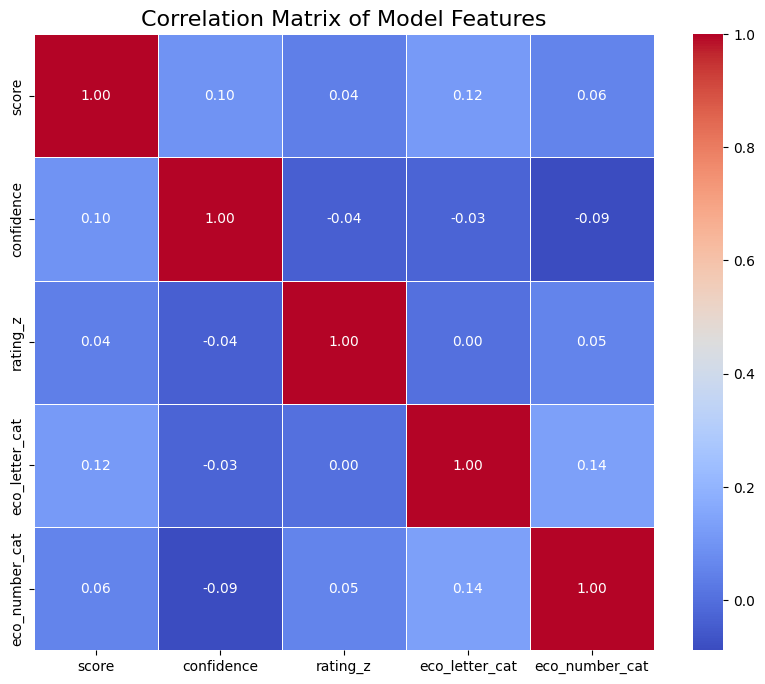

CORRELATIONS WITH TARGET VARIABLE (score)
eco_letter_cat    0.116399
confidence        0.097993
eco_number_cat    0.055865
rating_z          0.042897


In [14]:
# Step 4c: Correlation Analysis of Processed Data

%pip install seaborn --quiet
import seaborn as sns
import matplotlib.pyplot as plt

print("=" * 60)
print("STEP 4C: CORRELATION ANALYSIS OF PROCESSED DATA")
print("=" * 60)


# Start with the main interaction data (already has remapped IDs, adjusted score, confidence)
corr_df = clean_data[["player_id", "opening_id", "score", "confidence"]].copy()

# Merge player side information (rating_z)
# player_side_info is indexed by the remapped player_id
corr_df = corr_df.merge(
    player_side_info[["rating_z"]], left_on="player_id", right_index=True, how="left"
)

# Merge opening side information (eco categories)
# opening_side_info is indexed by the remapped opening_id
corr_df = corr_df.merge(
    opening_side_info[["eco_letter_cat", "eco_number_cat"]],
    left_on="opening_id",
    right_index=True,
    how="left",
)

print(f"Final DataFrame for correlation created.")
print(f"   • Columns: {corr_df.columns.tolist()}")


correlation_matrix = corr_df.corr().drop(columns=['player_id', 'opening_id']).drop(index=['player_id', 'opening_id'])


# 3. Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Model Features", fontsize=16)
plt.show()

# 4. Analyze correlations with the target variable 'score'
print("CORRELATIONS WITH TARGET VARIABLE (score)")
print("=" * 80)
score_correlations = (
    correlation_matrix["score"].drop("score").sort_values(ascending=False)
)
print(score_correlations.to_string())


In [15]:
# Verification: Sample player-opening pairs with reconstructed ECO codes and opening names
# Doing this to make sure that our ECO encoding/decoding is correct

print("VERIFICATION: ECO RECONSTRUCTION AND OPENING NAMES")
print("=" * 100)

# Sample random player-opening pairs from training data
sample_size = 100
sample_data = X_train.sample(min(sample_size, len(X_train)), random_state=42)

# Get unique opening IDs from sample (these are NEW remapped IDs)
new_opening_ids = sample_data['opening_id'].unique()

# Convert NEW opening IDs back to OLD database IDs for query
if opening_remapped:
    old_opening_ids = [opening_idx_to_id[int(new_id)] for new_id in new_opening_ids]
    print(f"   • Converting {len(new_opening_ids)} NEW opening IDs to OLD database IDs for query")
    print(f"   • Example: NEW ID {new_opening_ids[0]} → OLD ID {old_opening_ids[0]}")
else:
    old_opening_ids = new_opening_ids
    print(f"   • No remapping was done - using opening IDs directly")

opening_ids_str = ','.join(map(str, old_opening_ids))

# Query database for opening names using OLD IDs
con = get_db_connection(str(DB_PATH))
try:
    opening_query = f"""
        SELECT id, name, eco
        FROM opening
        WHERE id IN ({opening_ids_str})
    """
    opening_names = pd.DataFrame(con.execute(opening_query).df()).set_index('id')
finally:
    con.close()

# Create reverse mappings for ECO decoding
eco_int_to_letter = {v: k for k, v in eco_letter_map.items()}
eco_int_to_number = {v: k for k, v in eco_number_map.items()}

# Build verification table
print(f"{'#':<4} {'Player':<8} {'Opening':<9} {'ECO (DB)':<10} {'Reconstructed':<13} {'Match':<6} {'Opening Name':<50}")
print("=" * 100)

matches = 0
for i, (idx, row) in enumerate(sample_data.iterrows(), 1):
    player_id = int(row['player_id'])
    new_opening_id = int(row['opening_id'])
    
    # Convert NEW opening ID to OLD database ID for lookup
    if opening_remapped:
        old_opening_id = opening_idx_to_id[new_opening_id]
    else:
        old_opening_id = new_opening_id
    
    # Lookup opening side info using NEW ID
    opening_info = opening_side_info.loc[new_opening_id]
    
    # Reconstruct ECO from encoded categorical values
    eco_letter_encoded = opening_info['eco_letter_cat']
    eco_number_encoded = opening_info['eco_number_cat']
    
    eco_letter_decoded = eco_int_to_letter[eco_letter_encoded]
    eco_number_decoded = eco_int_to_number[eco_number_encoded]
    
    reconstructed_eco = f"{eco_letter_decoded}{eco_number_decoded}"
    
    # Get original ECO from database using OLD ID
    db_eco = opening_names.loc[old_opening_id, 'eco']
    opening_name = opening_names.loc[old_opening_id, 'name']
    
    # Check if they match
    match = "✓" if reconstructed_eco == db_eco else "✗"
    if reconstructed_eco == db_eco:
        matches += 1
    
    # Truncate opening name if too long
    if len(opening_name) > 48:
        opening_name = opening_name[:45] + "..."
    
    # Display using NEW opening ID (what's in the data now)
    print(f"{i:<4} {player_id:<8} {new_opening_id:<9} {db_eco:<10} {reconstructed_eco:<13} {match:<6} {opening_name:<50}")

print("=" * 100)
print(f"\n✅ Verification Results:")
print(f"   • Total samples: {len(sample_data)}")
print(f"   • Matches: {matches}/{len(sample_data)} ({100*matches/len(sample_data):.1f}%)")
print(f"   • Mismatches: {len(sample_data) - matches}")

if matches == len(sample_data):
    print(f"\n All ECO codes reconstructed correctly")
    print(f"   • ID remapping preserved all ECO code mappings")
else:
    print(f"\n⚠️  Warning: Some ECO codes did not match. Investigate mismatches above.")

VERIFICATION: ECO RECONSTRUCTION AND OPENING NAMES
   • Converting 88 NEW opening IDs to OLD database IDs for query
   • Example: NEW ID 653 → OLD ID 838
#    Player   Opening   ECO (DB)   Reconstructed Match  Opening Name                                      
1    18357    653       B06        B06           ✓      Modern Defense                                    
2    45188    668       B06        B06           ✓      Modern Defense: Two Knights Variation             
3    32831    653       B06        B06           ✓      Modern Defense                                    
4    19492    1819      D00        D00           ✓      Blackmar-Diemer Gambit                            
5    14696    849       B27        B27           ✓      Sicilian Defense: Hyperaccelerated Dragon         
6    24876    1346      C34        C34           ✓      King's Gambit Accepted: Fischer Defense           
7    6247     729       B12        B12           ✓      Caro-Kann Defense: Advance Variation, Bot

## 5. Data Verification and Examination
We're almost there. Let's examine our data structures to check for any obvious flaws.

In [16]:
print("X_train \n", X_train.head())
print("="*60)
print("X_val \n", X_val.head())
print("=" * 60)
print("X_test \n", X_test.head())
print("=" * 60)
print("y_train \n", y_train.head())
print("=" * 60)
print("y_val \n", y_val.head())
print("=" * 60) 
print("y_test \n", y_test.head())

# Now side information
print("player_side_info \n", player_side_info.head())
print("=" * 60)
print("opening_side_info \n", opening_side_info.head())

X_train 
          player_id  opening_id  confidence
679380       11013        1819    0.748744
1544705      25322         398    0.612403
2323873      38086        2430    0.305556
1941596      31801         598    0.825784
1403739      23037           6    0.180328
X_val 
          player_id  opening_id  confidence
444255        7206         297    0.557522
675589       10950        1703    0.230769
2397491      39307        1919    0.253731
80045         1330        2671    0.596774
1714910      28088        1709    0.576271
X_test 
          player_id  opening_id  confidence
1400658      22991        1079    0.719101
2321194      38038        1671    0.645390
2710107      44570        1263    0.367089
1204342      19746         166    0.425287
419673        6824        1236    0.812734
y_train 
 679380     0.528668
1544705    0.543867
2323873    0.458324
1941596    0.513303
1403739    0.480933
Name: score, dtype: float64
y_val 
 444255     0.516579
675589     0.494777
2397491    0.

In [17]:
# Final verification: Display cleaned side info tables

print("=" * 60)
print("CLEANED SIDE INFORMATION TABLES")
print("=" * 60)

print(f"\n📊 player_side_info (cleaned):")
print(f"   • Shape: {player_side_info.shape}")
print(f"   • Columns: {list(player_side_info.columns)}")
print(f"   • Index: player_id")
print(f"\n   Sample (5 rows):")
print(player_side_info.head().to_string())

print(f"\n📊 opening_side_info (cleaned):")
print(f"   • Shape: {opening_side_info.shape}")
print(f"   • Columns: {list(opening_side_info.columns)}")
print(f"   • Index: opening_id")
print(f"\n   Sample (5 rows):")
print(opening_side_info.head().to_string())


CLEANED SIDE INFORMATION TABLES

📊 player_side_info (cleaned):
   • Shape: (48468, 1)
   • Columns: ['rating_z']
   • Index: player_id

   Sample (5 rows):
           rating_z
player_id          
0          0.608678
1          1.058287
2          0.560506
3          0.616707
4         -2.169266

📊 opening_side_info (cleaned):
   • Shape: (2717, 2)
   • Columns: ['eco_letter_cat', 'eco_number_cat']
   • Index: opening_id

   Sample (5 rows):
            eco_letter_cat  eco_number_cat
opening_id                                
531                      1               0
565                      1               0
572                      1               0
579                      1               1
589                      1               1


## Step 5: Convert to PyTorch Tensors

**What are tensors?**
Tensors are PyTorch's version of arrays - just multi-dimensional data structures optimized for deep learning. Think of them like fancy NumPy arrays that can run on GPUs.

**What we need to convert:**

1. **Main features** (X_train, X_val, X_test):
   - `player_id` → long tensor (integer IDs)
   - `opening_id` → long tensor (integer IDs)
   - `confidence` → float tensor (weights for loss function)

2. **Targets** (y_train, y_val, y_test):
   - `score` → float tensor (what we're predicting)

3. **Player side info** (player_side_info):
   - `rating_z` → float tensor (normalized ratings)
   - Indexed by player_id for fast lookup

4. **Opening side info** (opening_side_info):
   - `eco_letter_cat` → long tensor (categorical)
   - `eco_number_cat` → long tensor (categorical)
   - Indexed by opening_id for fast lookup

**Why these data types?**
- `long` (int64): For IDs and categorical features that will be embedded
- `float` (float32): For continuous values like scores, confidence, and normalized ratings



In [18]:
import sys
# It says subprocess is unused but complains at me if I don't import it
# Something to do with incompatible versions of blah blah blah
# Don't really care as long as it works
import subprocess
import torch


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/a/Documents/personalprojects/chess-opening-recommender/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/a/Documents/personalprojects/chess-opening-recommender/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/a/Documents/personalprojects/chess-opening-

In [19]:
# Step 5: Convert all data to PyTorch tensors

print("STEP 5: CONVERT TO PYTORCH TENSORS")
print("=" * 60)

# Set random seed for reproducibility
torch.manual_seed(42)

print(f"   • CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   • CUDA device: {torch.cuda.get_device_name(0)}")
print(f"   • Default dtype: float32 for continuous, int64 for IDs/categorical")

# 0. Index alignment sanity checks
print(f"\n0️⃣  Index alignment sanity checks...")

# Check player_side_info is properly indexed
player_ids_sorted = sorted(player_side_info.index.values)
if player_ids_sorted != list(player_side_info.index.values):
    print(f"   ⚠️  player_side_info index is not sorted - this is OK, we'll use index values directly")
else:
    print(f"   ✓ player_side_info index is sorted")
print(f"   • Index range: [{player_side_info.index.min()}, {player_side_info.index.max()}]")
print(f"   • Index dtype: {player_side_info.index.dtype}")

# Check opening_side_info is properly indexed
opening_ids_sorted = sorted(opening_side_info.index.values)
if opening_ids_sorted != list(opening_side_info.index.values):
    print(f"   ⚠️  opening_side_info index is not sorted - this is OK, we'll use index values directly")
else:
    print(f"   ✓ opening_side_info index is sorted")
print(f"   • Index range: [{opening_side_info.index.min()}, {opening_side_info.index.max()}]")
print(f"   • Index dtype: {opening_side_info.index.dtype}")

# CRITICAL: Check if indices are contiguous 0-based
# If opening_side_info.index = [0, 1, 2, ..., N-1], then we can use opening_id as direct array index
# If not (e.g., [10, 15, 23, ...]), we'll need a mapping dictionary
print(f"\n   Checking if indices are contiguous 0-based...")
player_ids_are_contiguous = (player_side_info.index == range(len(player_side_info))).all()
opening_ids_are_contiguous = (opening_side_info.index == range(len(opening_side_info))).all()


if not player_ids_are_contiguous:
    print(f"   ℹ️  Player IDs are NOT 0-based contiguous - will need mapping for embedding lookup")
if not opening_ids_are_contiguous:
    print(f"   ℹ️  Opening IDs are NOT 0-based contiguous - will need mapping for embedding lookup")

# 1. Convert main features (train/val/test)

# Train set
player_ids_train = torch.tensor(X_train['player_id'].values, dtype=torch.long)
opening_ids_train = torch.tensor(X_train['opening_id'].values, dtype=torch.long)
confidence_train = torch.tensor(X_train['confidence'].values, dtype=torch.float32)

print(f"   • Training tensors:")
print(f"   • player_ids_train: {player_ids_train.shape}, dtype={player_ids_train.dtype}")
print(f"   • opening_ids_train: {opening_ids_train.shape}, dtype={opening_ids_train.dtype}")
print(f"   • confidence_train: {confidence_train.shape}, dtype={confidence_train.dtype}")

# Validation set
player_ids_val = torch.tensor(X_val['player_id'].values, dtype=torch.long)
opening_ids_val = torch.tensor(X_val['opening_id'].values, dtype=torch.long)
confidence_val = torch.tensor(X_val['confidence'].values, dtype=torch.float32)

print(f"\n   Validation tensors:")
print(f"   • player_ids_val: {player_ids_val.shape}, dtype={player_ids_val.dtype}")
print(f"   • opening_ids_val: {opening_ids_val.shape}, dtype={opening_ids_val.dtype}")
print(f"   • confidence_val: {confidence_val.shape}, dtype={confidence_val.dtype}")

# Test set
player_ids_test = torch.tensor(X_test['player_id'].values, dtype=torch.long)
opening_ids_test = torch.tensor(X_test['opening_id'].values, dtype=torch.long)
confidence_test = torch.tensor(X_test['confidence'].values, dtype=torch.float32)

print(f"\n   Test tensors:")
print(f"   • player_ids_test: {player_ids_test.shape}, dtype={player_ids_test.dtype}")
print(f"   • opening_ids_test: {opening_ids_test.shape}, dtype={opening_ids_test.dtype}")
print(f"   • confidence_test: {confidence_test.shape}, dtype={confidence_test.dtype}")

# 2. Convert targets (scores)
print(f"\n2️⃣  Converting target scores (y_train, y_val, y_test)...")

scores_train = torch.tensor(y_train.values, dtype=torch.float32)
scores_val = torch.tensor(y_val.values, dtype=torch.float32)
scores_test = torch.tensor(y_test.values, dtype=torch.float32)

print(f"   • scores_train: {scores_train.shape}, dtype={scores_train.dtype}")
print(f"   • scores_val: {scores_val.shape}, dtype={scores_val.dtype}")
print(f"   • scores_test: {scores_test.shape}, dtype={scores_test.dtype}")

print(f"\n   Score ranges (sanity check):")
print(f"   • Train: [{scores_train.min():.4f}, {scores_train.max():.4f}]")
print(f"   • Val: [{scores_val.min():.4f}, {scores_val.max():.4f}]")
print(f"   • Test: [{scores_test.min():.4f}, {scores_test.max():.4f}]")

# 3. Convert player side information

# Create tensor of all player ratings (indexed by player_id)
# Since player_side_info is indexed by player_id, we need to ensure coverage
player_ratings_tensor = torch.tensor(player_side_info['rating_z'].values, dtype=torch.float32)
player_ids_in_side_info = torch.tensor(player_side_info.index.values, dtype=torch.long)

print(f"   • player_ratings_tensor: {player_ratings_tensor.shape}, dtype={player_ratings_tensor.dtype}")
print(f"   • player_ids_in_side_info: {player_ids_in_side_info.shape}, dtype={player_ids_in_side_info.dtype}")
print(f"   • Rating range: [{player_ratings_tensor.min():.4f}, {player_ratings_tensor.max():.4f}]")

# Verify all player IDs in train/val/test are covered
all_player_ids = torch.cat([player_ids_train, player_ids_val, player_ids_test]).unique()
missing_players = set(all_player_ids.tolist()) - set(player_ids_in_side_info.tolist())
if len(missing_players) > 0:
    print(f"   ⚠️  WARNING: {len(missing_players)} players in splits missing from side_info!")

# 4. Convert opening side information
print(f"\n4️⃣  Converting opening side information...")

# Verify column names exist (using eco_letter_cat and eco_number_cat consistently)
if 'eco_letter_cat' not in opening_side_info.columns:
    raise ValueError(f"Column 'eco_letter_cat' not found. Available: {opening_side_info.columns.tolist()}")
if 'eco_number_cat' not in opening_side_info.columns:
    raise ValueError(f"Column 'eco_number_cat' not found. Available: {opening_side_info.columns.tolist()}")

# Create tensors for opening ECO features (indexed by opening_id)
opening_eco_letter_tensor = torch.tensor(opening_side_info['eco_letter_cat'].values, dtype=torch.long)
opening_eco_number_tensor = torch.tensor(opening_side_info['eco_number_cat'].values, dtype=torch.long)
opening_ids_in_side_info = torch.tensor(opening_side_info.index.values, dtype=torch.long)

print(f"   • opening_eco_letter_tensor: {opening_eco_letter_tensor.shape}, dtype={opening_eco_letter_tensor.dtype}")
print(f"   • opening_eco_number_tensor: {opening_eco_number_tensor.shape}, dtype={opening_eco_number_tensor.dtype}")
print(f"   • opening_ids_in_side_info: {opening_ids_in_side_info.shape}, dtype={opening_ids_in_side_info.dtype}")
print(f"   • ECO letter range: [{opening_eco_letter_tensor.min()}, {opening_eco_letter_tensor.max()}]")
print(f"   • ECO number range: [{opening_eco_number_tensor.min()}, {opening_eco_number_tensor.max()}]")

# Verify all opening IDs in train/val/test are covered
all_opening_ids = torch.cat([opening_ids_train, opening_ids_val, opening_ids_test]).unique()
missing_openings = set(all_opening_ids.tolist()) - set(opening_ids_in_side_info.tolist())
if len(missing_openings) > 0:
    print(f"   ⚠️  WARNING: {len(missing_openings)} openings in splits missing from side_info!")

# 5. Summary statistics
print(f"\n5️⃣  Summary statistics:")
print(f"   • Train: {len(scores_train):,} samples")
print(f"   • Val: {len(scores_val):,} samples")
print(f"   • Test: {len(scores_test):,} samples")

print(f"\n   Unique entities:")
print(f"   • Players: {len(player_ids_in_side_info):,}")
print(f"   • Openings: {len(opening_ids_in_side_info):,}")

print(f"\n   Vocabulary sizes (for embedding layers):")
print(f"   • num_players: {player_ids_in_side_info.max() + 1} (max player_id + 1)")
print(f"   • num_openings: {opening_ids_in_side_info.max() + 1} (max opening_id + 1)")
print(f"   • num_eco_letters: {opening_eco_letter_tensor.max() + 1} (max eco_letter_cat + 1)")
print(f"   • num_eco_numbers: {opening_eco_number_tensor.max() + 1} (max eco_number_cat + 1)")

# 6. Memory usage (approximate - using simple calculation)
print(f"\n6️⃣  Approximate memory usage:")
def tensor_memory_mb(t):
    """Calculate tensor memory in MB"""
    return (t.element_size() * t.nelement()) / (1024 * 1024)

tensors = [
    player_ids_train, opening_ids_train, confidence_train, scores_train,
    player_ids_val, opening_ids_val, confidence_val, scores_val,
    player_ids_test, opening_ids_test, confidence_test, scores_test,
    player_ratings_tensor, opening_eco_letter_tensor, opening_eco_number_tensor
]
total_memory_mb = sum(tensor_memory_mb(t) for t in tensors)
print(f"   • Total tensor memory: {total_memory_mb:.2f} MB")

print("\n" + "=" * 60)
print("✅ TENSOR CONVERSION COMPLETE")

STEP 5: CONVERT TO PYTORCH TENSORS
   • CUDA available: False
   • Default dtype: float32 for continuous, int64 for IDs/categorical

0️⃣  Index alignment sanity checks...
   ✓ player_side_info index is sorted
   • Index range: [0, 48467]
   • Index dtype: int64
   ⚠️  opening_side_info index is not sorted - this is OK, we'll use index values directly
   • Index range: [0, 2716]
   • Index dtype: int64

   Checking if indices are contiguous 0-based...
   ℹ️  Opening IDs are NOT 0-based contiguous - will need mapping for embedding lookup
   • Training tensors:
   • player_ids_train: torch.Size([2173275]), dtype=torch.int64
   • opening_ids_train: torch.Size([2173275]), dtype=torch.int64
   • confidence_train: torch.Size([2173275]), dtype=torch.float32

   Validation tensors:
   • player_ids_val: torch.Size([434655]), dtype=torch.int64
   • opening_ids_val: torch.Size([434655]), dtype=torch.int64
   • confidence_val: torch.Size([434655]), dtype=torch.float32
   • Training tensors:
   • pl

## Step 6: Training Setup

Define all constants, loss functions, optimizer, and helper functions for training.

**What we need to set up:**

1. **Constants and Hyperparameters:**
   - `NUM_FACTORS`: Dimensionality of latent factor embeddings (e.g., 50)
   - `LEARNING_RATE`: Step size for SGD optimizer (e.g., 0.01)
   - `BATCH_SIZE`: Number of samples per training batch (e.g., 1024)
   - `N_EPOCHS`: Number of full passes through training data (e.g., 10)
   - Random seeds for reproducibility

2. **Loss Functions:**
   - MSE (Mean Squared Error): Main training loss
   - RMSE (Root Mean Squared Error): Evaluation metric
   - Confidence-weighted loss: Down-weight uncertain predictions

3. **Optimizer:**
   - SGD (Stochastic Gradient Descent) with momentum

4. **Helper Functions:**
   - `train_one_epoch()`: Train for one epoch
   - `evaluate_model()`: Evaluate on validation/test set
   - `calculate_rmse()`: Compute RMSE metric
   - `save_checkpoint()`: Save model state

5. **Logging:**
   - Progress bars with ETA
   - Loss tracking per epoch
   - Model checkpointing


In [20]:
# Step 6a: Define Hyperparameters and Constants

import torch
import random
import numpy as np

print("STEP 6A: DEFINE HYPERPARAMETERS AND CONSTANTS")
print("=" * 60)

# ========================================
# HYPERPARAMETERS AND CONSTANTS CONFIG
# ========================================

NUM_FACTORS = 50  # Dimensionality of latent factor embeddings

# Training parameters
LEARNING_RATE = 0.01
MOMENTUM = 0.9  # SGD momentum
BATCH_SIZE = 1024 
N_EPOCHS = 20

# Regularization (if needed)
WEIGHT_DECAY = 0.0

RANDOM_SEED = 42

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_SAVE_DIR = Path.cwd().parent / "data" / "models"  # Saves to projectroot/data/models
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)


print(f"\n📋 Hyperparameters:")
print(f"   • NUM_FACTORS: {NUM_FACTORS}")
print(f"   • LEARNING_RATE: {LEARNING_RATE}")
print(f"   • MOMENTUM: {MOMENTUM}")
print(f"   • BATCH_SIZE: {BATCH_SIZE}")
print(f"   • N_EPOCHS: {N_EPOCHS}")
print(f"   • WEIGHT_DECAY: {WEIGHT_DECAY}")

print(f"\n🎲 Random Seed:")
print(f"   • RANDOM_SEED: {RANDOM_SEED}")

print(f"\n💻 Device Configuration:")
print(f"   • DEVICE: {DEVICE}")
if torch.cuda.is_available():
    print(f"   • GPU: {torch.cuda.get_device_name(0)}")
    print(f"   • GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f"\n💾 Model Saving:")
print(f"   • Save directory: {MODEL_SAVE_DIR}")

# ========================================
# SET RANDOM SEEDS FOR REPRODUCIBILITY
# ========================================

# Python random
random.seed(RANDOM_SEED)
print(f"   ✓ Python random seed set to {RANDOM_SEED}")

# NumPy random
np.random.seed(RANDOM_SEED)
print(f"   ✓ NumPy random seed set to {RANDOM_SEED}")

# PyTorch random
torch.manual_seed(RANDOM_SEED)
print(f"   ✓ PyTorch CPU random seed set to {RANDOM_SEED}")

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)  # For multi-GPU
    print(f"   ✓ PyTorch GPU random seed set to {RANDOM_SEED}")
    
    # Additional CUDA reproducibility settings
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"   ✓ CUDA deterministic mode enabled")

# ========================================
# CALCULATE VOCABULARY SIZES
# ========================================

print(f"\n📊 Vocabulary Sizes (for embedding layers):")

# Calculate from our tensors
NUM_PLAYERS = int(player_ids_in_side_info.max()) + 1
NUM_OPENINGS = int(opening_ids_in_side_info.max()) + 1
NUM_ECO_LETTERS = int(opening_eco_letter_tensor.max()) + 1
NUM_ECO_NUMBERS = int(opening_eco_number_tensor.max()) + 1

print(f"   • NUM_PLAYERS: {NUM_PLAYERS:,} (max player_id + 1)")
print(f"   • NUM_OPENINGS: {NUM_OPENINGS:,} (max opening_id + 1)")
print(f"   • NUM_ECO_LETTERS: {NUM_ECO_LETTERS} (ECO letter categories)")
print(f"   • NUM_ECO_NUMBERS: {NUM_ECO_NUMBERS} (ECO number categories)")

# ========================================
# DATASET STATISTICS
# ========================================

print(f"\n📈 Dataset Statistics:")
print(f"   • Train samples: {len(scores_train):,}")
print(f"   • Validation samples: {len(scores_val):,}")
print(f"   • Test samples: {len(scores_test):,}")
print(f"   • Total samples: {len(scores_train) + len(scores_val) + len(scores_test):,}")

print(f"\n   • Batches per epoch: {len(scores_train) // BATCH_SIZE:,}")
print(f"   • Training iterations (total): {(len(scores_train) // BATCH_SIZE) * N_EPOCHS:,}")

print("\n" + "=" * 60)
print("✅ HYPERPARAMETERS AND CONSTANTS DEFINED")

STEP 6A: DEFINE HYPERPARAMETERS AND CONSTANTS

📋 Hyperparameters:
   • NUM_FACTORS: 50
   • LEARNING_RATE: 0.01
   • MOMENTUM: 0.9
   • BATCH_SIZE: 1024
   • N_EPOCHS: 20
   • WEIGHT_DECAY: 0.0

🎲 Random Seed:
   • RANDOM_SEED: 42

💻 Device Configuration:
   • DEVICE: cpu

💾 Model Saving:
   • Save directory: /Users/a/Documents/personalprojects/chess-opening-recommender/data/models
   ✓ Python random seed set to 42
   ✓ NumPy random seed set to 42
   ✓ PyTorch CPU random seed set to 42

📊 Vocabulary Sizes (for embedding layers):
   • NUM_PLAYERS: 48,468 (max player_id + 1)
   • NUM_OPENINGS: 2,717 (max opening_id + 1)
   • NUM_ECO_LETTERS: 5 (ECO letter categories)
   • NUM_ECO_NUMBERS: 100 (ECO number categories)

📈 Dataset Statistics:
   • Train samples: 2,173,275
   • Validation samples: 434,655
   • Test samples: 289,770
   • Total samples: 2,897,700

   • Batches per epoch: 2,122
   • Training iterations (total): 42,440

✅ HYPERPARAMETERS AND CONSTANTS DEFINED


In [21]:
# Step 6b: Define Loss Functions

# import torch.nn as nn
# import torch.nn.functional as F

print("STEP 6B: DEFINE LOSS FUNCTIONS")
print("=" * 60)

# ========================================
# LOSS FUNCTIONS
# ========================================

def mse_loss(predictions, targets, confidence_weights=None):
    """
    Mean Squared Error loss with optional confidence weighting.
    
    Parameters:
    -----------
    predictions : torch.Tensor
        Model predictions (shape: [batch_size])
    targets : torch.Tensor
        Ground truth scores (shape: [batch_size])
    confidence_weights : torch.Tensor, optional
        Confidence weights for each sample (shape: [batch_size])
        Higher confidence = larger loss contribution
        
    Returns:
    --------
    torch.Tensor
        Scalar loss value
    """
    # Compute squared error
    squared_error = (predictions - targets) ** 2
    
    # Apply confidence weighting if provided
    if confidence_weights is not None:
        weighted_squared_error = squared_error * confidence_weights
        # Average over all samples (sum of weighted errors / sum of weights)
        loss = weighted_squared_error.sum() / confidence_weights.sum()
    else:
        # Standard MSE (average over all samples)
        loss = squared_error.mean()
    
    return loss


def rmse_loss(predictions, targets, confidence_weights=None):
    """
    Root Mean Squared Error loss.
    
    This is the square root of MSE and is our primary evaluation metric.
    RMSE is in the same units as the target (score), making it interpretable.
    
    Parameters:
    -----------
    predictions : torch.Tensor
        Model predictions (shape: [batch_size])
    targets : torch.Tensor
        Ground truth scores (shape: [batch_size])
    confidence_weights : torch.Tensor, optional
        Confidence weights for each sample (shape: [batch_size])
        
    Returns:
    --------
    torch.Tensor
        Scalar RMSE value
    """
    mse = mse_loss(predictions, targets, confidence_weights)
    return torch.sqrt(mse)


def calculate_rmse(predictions, targets, confidence_weights=None):
    """
    Calculate RMSE metric (convenience function for evaluation).
    
    This is the same as rmse_loss but with clearer naming for evaluation.
    
    Parameters:
    -----------
    predictions : torch.Tensor
        Model predictions (shape: [batch_size])
    targets : torch.Tensor
        Ground truth scores (shape: [batch_size])
    confidence_weights : torch.Tensor, optional
        Confidence weights for each sample (shape: [batch_size])
        
    Returns:
    --------
    float
        RMSE value (Python float, not tensor)
    """
    with torch.no_grad():  # Don't compute gradients for evaluation
        rmse = rmse_loss(predictions, targets, confidence_weights)
    return rmse.item()


# ========================================
# TEST LOSS FUNCTIONS
# ========================================

print(f"\n🧪 Testing loss functions with dummy data...")

# Create dummy data for testing
dummy_predictions = torch.tensor([0.5, 0.6, 0.7, 0.8], dtype=torch.float32)
dummy_targets = torch.tensor([0.55, 0.62, 0.68, 0.75], dtype=torch.float32)
dummy_confidence = torch.tensor([0.8, 0.9, 0.7, 1.0], dtype=torch.float32)

print(f"\n   Dummy data:")
print(f"   • Predictions: {dummy_predictions.tolist()}")
print(f"   • Targets: {dummy_targets.tolist()}")
print(f"   • Confidence: {dummy_confidence.tolist()}")

# Test MSE without confidence weighting
mse_unweighted = mse_loss(dummy_predictions, dummy_targets)
print(f"\n   MSE (unweighted): {mse_unweighted.item():.6f}")

# Test MSE with confidence weighting
mse_weighted = mse_loss(dummy_predictions, dummy_targets, dummy_confidence)
print(f"   MSE (weighted): {mse_weighted.item():.6f}")

# Test RMSE
rmse_unweighted = rmse_loss(dummy_predictions, dummy_targets)
rmse_weighted = rmse_loss(dummy_predictions, dummy_targets, dummy_confidence)
print(f"\n   RMSE (unweighted): {rmse_unweighted.item():.6f}")
print(f"   RMSE (weighted): {rmse_weighted.item():.6f}")

# Test calculate_rmse
rmse_eval = calculate_rmse(dummy_predictions, dummy_targets, dummy_confidence)
print(f"\n   calculate_rmse() result: {rmse_eval:.6f}")
print(f"   ✓ Returns Python float (not tensor): {type(rmse_eval)}")

print("\n" + "=" * 60)
print("✅ LOSS FUNCTIONS COMPLETE")
print("=" * 60)

STEP 6B: DEFINE LOSS FUNCTIONS

🧪 Testing loss functions with dummy data...

   Dummy data:
   • Predictions: [0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929]
   • Targets: [0.550000011920929, 0.6200000047683716, 0.6800000071525574, 0.75]
   • Confidence: [0.800000011920929, 0.8999999761581421, 0.699999988079071, 1.0]

   MSE (unweighted): 0.001450
   MSE (weighted): 0.001512

   RMSE (unweighted): 0.038079
   RMSE (weighted): 0.038881

   calculate_rmse() result: 0.038881
   ✓ Returns Python float (not tensor): <class 'float'>

✅ LOSS FUNCTIONS COMPLETE


In [22]:
# Step 6c: Create PyTorch Dataset and DataLoader

from torch.utils.data import Dataset, DataLoader

print("STEP 6C: CREATE PYTORCH DATASET AND DATALOADER")
print("=" * 60)

# ========================================
# CUSTOM DATASET CLASS
# ========================================

class ChessOpeningDataset(Dataset):
    """
    PyTorch Dataset for chess player-opening interactions.
    
    Each sample contains:
    - player_id: Integer ID for embedding lookup
    - opening_id: Integer ID for embedding lookup
    - confidence: Confidence weight for loss function
    - score: Target value (win rate)
    """
    
    def __init__(self, player_ids, opening_ids, confidence, scores):
        """
        Initialize dataset.
        
        Parameters:
        -----------
        player_ids : torch.Tensor
            Player IDs (long tensor)
        opening_ids : torch.Tensor
            Opening IDs (long tensor)
        confidence : torch.Tensor
            Confidence weights (float tensor)
        scores : torch.Tensor
            Target scores (float tensor)
        """
        self.player_ids = player_ids
        self.opening_ids = opening_ids
        self.confidence = confidence
        self.scores = scores
        
        # Validate shapes
        assert len(player_ids) == len(opening_ids) == len(confidence) == len(scores), \
            "All tensors must have the same length"
        
    def __len__(self):
        """Return the number of samples."""
        return len(self.player_ids)
    
    def __getitem__(self, idx):
        """
        Get a single sample.
        
        Parameters:
        -----------
        idx : int
            Index of the sample to retrieve
            
        Returns:
        --------
        dict
            Dictionary with keys: 'player_id', 'opening_id', 'confidence', 'score'
        """
        return {
            'player_id': self.player_ids[idx],
            'opening_id': self.opening_ids[idx],
            'confidence': self.confidence[idx],
            'score': self.scores[idx]
        }


# ========================================
# CREATE DATASETS
# ========================================

print(f"\n1️⃣  Creating PyTorch Datasets...")

train_dataset = ChessOpeningDataset(
    player_ids_train, opening_ids_train, confidence_train, scores_train
)
val_dataset = ChessOpeningDataset(
    player_ids_val, opening_ids_val, confidence_val, scores_val
)
test_dataset = ChessOpeningDataset(
    player_ids_test, opening_ids_test, confidence_test, scores_test
)

print(f"   ✓ Train dataset: {len(train_dataset):,} samples")
print(f"   ✓ Validation dataset: {len(val_dataset):,} samples")
print(f"   ✓ Test dataset: {len(test_dataset):,} samples")

# Test dataset access
print(f"\n2️⃣  Testing dataset access...")
sample = train_dataset[0]
print(f"   Sample from train_dataset[0]:")
print(f"   • player_id: {sample['player_id']}")
print(f"   • opening_id: {sample['opening_id']}")
print(f"   • confidence: {sample['confidence']:.4f}")
print(f"   • score: {sample['score']:.4f}")

# ========================================
# CREATE DATALOADERS
# ========================================

print(f"\n3️⃣  Creating PyTorch DataLoaders...")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle training data each epoch
    num_workers=0,  # Number of subprocesses for data loading (0 = main process)
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Don't shuffle validation data
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Don't shuffle test data
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)


STEP 6C: CREATE PYTORCH DATASET AND DATALOADER

1️⃣  Creating PyTorch Datasets...
   ✓ Train dataset: 2,173,275 samples
   ✓ Validation dataset: 434,655 samples
   ✓ Test dataset: 289,770 samples

2️⃣  Testing dataset access...
   Sample from train_dataset[0]:
   • player_id: 11013
   • opening_id: 1819
   • confidence: 0.7487
   • score: 0.5287

3️⃣  Creating PyTorch DataLoaders...


In [23]:
# Step 6d: Define Helper Functions for Training

import time

print("STEP 6D: DEFINE HELPER FUNCTIONS")
print("=" * 60)

# ========================================
# HELPER FUNCTION: Save Checkpoint
# ========================================

def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, filepath):
    """
    Save model checkpoint to disk.
    
    Parameters:
    -----------
    model : nn.Module
        The model to save
    optimizer : torch.optim.Optimizer
        The optimizer state to save
    epoch : int
        Current epoch number
    train_loss : float
        Training loss for this epoch
    val_loss : float
        Validation loss for this epoch
    filepath : Path or str
        Where to save the checkpoint
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        
        # Save hyperparameters for reproducibility
        'hyperparameters': {
            'num_factors': NUM_FACTORS,
            'learning_rate': LEARNING_RATE,
            'momentum': MOMENTUM,
            'batch_size': BATCH_SIZE,
            'num_players': NUM_PLAYERS,
            'num_openings': NUM_OPENINGS,
            'num_eco_letters': NUM_ECO_LETTERS,
            'num_eco_numbers': NUM_ECO_NUMBERS,
        }
    }
    
    torch.save(checkpoint, filepath)
    print(f"   Checkpoint saved to: {filepath}")


# ========================================
# HELPER FUNCTION: Load Checkpoint
# ========================================

def load_checkpoint(model, optimizer, filepath):
    """
    Load model checkpoint from disk.
    
    Parameters:
    -----------
    model : nn.Module
        The model to load weights into
    optimizer : torch.optim.Optimizer
        The optimizer to load state into
    filepath : Path or str
        Where to load the checkpoint from
        
    Returns:
    --------
    int
        The epoch number from the checkpoint
    """
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    print(f"    Checkpoint loaded from: {filepath}")
    print(f"   • Epoch: {epoch}")
    print(f"   • Train loss: {checkpoint['train_loss']:.6f}")
    print(f"   • Val loss: {checkpoint['val_loss']:.6f}")
    
    return epoch


# ========================================
# HELPER FUNCTION: Format Time
# ========================================

def format_time(seconds):
    """
    Format seconds as human-readable time string.
    
    Parameters:
    -----------
    seconds : float
        Number of seconds
        
    Returns:
    --------
    str
        Formatted time string (e.g., "1h 23m 45s")
    """
    if seconds < 60:
        return f"{seconds:.1f}s"
    elif seconds < 3600:
        minutes = int(seconds // 60)
        secs = int(seconds % 60)
        return f"{minutes}m {secs}s"
    else:
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        secs = int(seconds % 60)
        return f"{hours}h {minutes}m {secs}s"


# ========================================
# HELPER FUNCTION: Print Progress
# ========================================

def print_progress(epoch, batch_idx, total_batches, loss, elapsed_time):
    """
    Print training progress with ETA.
    
    Parameters:
    -----------
    epoch : int
        Current epoch number
    batch_idx : int
        Current batch index (0-based)
    total_batches : int
        Total number of batches per epoch
    loss : float
        Current loss value
    elapsed_time : float
        Elapsed time in seconds since epoch start
    """
    # Calculate progress
    progress_pct = 100.0 * (batch_idx + 1) / total_batches
    
    # Estimate time remaining
    time_per_batch = elapsed_time / (batch_idx + 1)
    remaining_batches = total_batches - (batch_idx + 1)
    eta_seconds = time_per_batch * remaining_batches
    
    # Print progress bar
    bar_length = 40
    filled_length = int(bar_length * (batch_idx + 1) / total_batches)
    bar = '█' * filled_length + '░' * (bar_length - filled_length)
    
    print(f"   Epoch {epoch} [{bar}] {progress_pct:>6.2f}% | "
          f"Loss: {loss:.6f} | "
          f"ETA: {format_time(eta_seconds)}", end='\r')


# ========================================
# TEST HELPER FUNCTIONS
# ========================================

# Test format_time
print(f"\n   format_time() tests:")
test_times = [30, 90, 300, 3661, 7384]
for t in test_times:
    print(f"   • {t} seconds → {format_time(t)}")

# Test print_progress (will overwrite line)
print(f"\n   print_progress() test (simulating batch progress):")
for i in range(0, 101, 20):
    total = 100
    loss = 0.05 - i * 0.0003
    elapsed = i * 0.5
    print_progress(epoch=1, batch_idx=i, total_batches=total, loss=loss, elapsed_time=elapsed)
    time.sleep(0.1)  # Brief pause to show animation
print()  # New line after progress bar

print("\n" + "=" * 60)
print("✅ HELPER FUNCTIONS COMPLETE")
print("=" * 60)

STEP 6D: DEFINE HELPER FUNCTIONS

   format_time() tests:
   • 30 seconds → 30.0s
   • 90 seconds → 1m 30s
   • 300 seconds → 5m 0s
   • 3661 seconds → 1h 1m 1s
   • 7384 seconds → 2h 3m 4s

   print_progress() test (simulating batch progress):
   Epoch 1 [████████████████████████████████████████] 101.00% | Loss: 0.020000 | ETA: -0.5s

✅ HELPER FUNCTIONS COMPLETE
   Epoch 1 [████████████████████████████████████████] 101.00% | Loss: 0.020000 | ETA: -0.5s

✅ HELPER FUNCTIONS COMPLETE


In [24]:
# Step 6e: Define Training and Evaluation Functions

print("STEP 6E: DEFINE TRAINING AND EVALUATION FUNCTIONS")
print("=" * 60)

# ========================================
# TRAINING FUNCTION: Train One Epoch
# ========================================

def train_one_epoch(model, train_loader, optimizer, device, epoch_num):
    """
    Train the model for one epoch.
    
    Parameters:
    -----------
    model : nn.Module
        The model to train
    train_loader : DataLoader
        DataLoader for training data
    optimizer : torch.optim.Optimizer
        Optimizer for updating model parameters
    device : torch.device
        Device to train on (CPU or CUDA)
    epoch_num : int
        Current epoch number (for logging)
        
    Returns:
    --------
    tuple
        (average_loss, elapsed_time)
    """
    model.train()  # Set model to training mode
    
    total_loss = 0.0
    num_batches = len(train_loader)
    epoch_start_time = time.time()
    
    for batch_idx, batch in enumerate(train_loader):
        # Move batch to device
        player_ids = batch['player_id'].to(device)
        opening_ids = batch['opening_id'].to(device)
        confidence = batch['confidence'].to(device)
        targets = batch['score'].to(device)
        
        # Forward pass
        predictions = model(player_ids, opening_ids)
        
        # Compute loss with confidence weighting
        loss = mse_loss(predictions, targets, confidence)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters
        
        # Track loss
        total_loss += loss.item()
        
        # Print progress every 10 batches or on last batch
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == num_batches:
            elapsed = time.time() - epoch_start_time
            print_progress(epoch_num, batch_idx, num_batches, loss.item(), elapsed)
    
    # Calculate average loss
    avg_loss = total_loss / num_batches
    elapsed_time = time.time() - epoch_start_time
    
    # Clear progress line and print summary
    print()  # New line after progress bar
    
    return avg_loss, elapsed_time


# ========================================
# EVALUATION FUNCTION: Evaluate Model
# ========================================

def evaluate_model(model, data_loader, device, dataset_name="Validation"):
    """
    Evaluate the model on a dataset.
    
    Parameters:
    -----------
    model : nn.Module
        The model to evaluate
    data_loader : DataLoader
        DataLoader for evaluation data
    device : torch.device
        Device to evaluate on (CPU or CUDA)
    dataset_name : str
        Name of dataset for logging (e.g., "Validation", "Test")
        
    Returns:
    --------
    tuple
        (mse, rmse)
    """
    model.eval()  # Set model to evaluation mode
    
    total_mse = 0.0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in data_loader:
            # Move batch to device
            player_ids = batch['player_id'].to(device)
            opening_ids = batch['opening_id'].to(device)
            confidence = batch['confidence'].to(device)
            targets = batch['score'].to(device)
            
            # Forward pass
            predictions = model(player_ids, opening_ids)
            
            # Compute MSE with confidence weighting
            batch_mse = mse_loss(predictions, targets, confidence)
            
            # Track weighted sum of MSE
            total_mse += batch_mse.item() * len(targets)
            total_samples += len(targets)
    
    # Calculate average MSE and RMSE
    avg_mse = total_mse / total_samples
    avg_rmse = avg_mse ** 0.5
    
    return avg_mse, avg_rmse


# ========================================
# TEST FUNCTIONS (with dummy model)
# ========================================

print(" TRAINING AND EVALUATION FUNCTIONS COMPLETE")
print("=" * 60)

print(f"\n📋 Training workflow:")
print(f"   1. Initialize model and optimizer")
print(f"   2. For each epoch:")
print(f"      a. Call train_one_epoch()")
print(f"      b. Call evaluate_model() on validation set")
print(f"      c. Save checkpoint with save_checkpoint()")
print(f"      d. Log metrics")
print(f"   3. After training, evaluate on test set")


STEP 6E: DEFINE TRAINING AND EVALUATION FUNCTIONS
 TRAINING AND EVALUATION FUNCTIONS COMPLETE

📋 Training workflow:
   1. Initialize model and optimizer
   2. For each epoch:
      a. Call train_one_epoch()
      b. Call evaluate_model() on validation set
      c. Save checkpoint with save_checkpoint()
      d. Log metrics
   3. After training, evaluate on test set


In [25]:
# Step 6f: Define Model Architecture

print("STEP 6F: DEFINE MODEL ARCHITECTURE")
print("=" * 60)

# ========================================
# Chess Opening Recommender Model
# ========================================

class ChessOpeningRecommender(torch.nn.Module):
    """
    Matrix Factorization model for chess opening recommendations.
    
    The model learns latent factors for players and openings, incorporating
    side information:
    - Player ratings (normalized)
    - Opening ECO codes (letter and number as categorical features)
    
    Architecture:
    - Player embedding: learnable latent factors
    - Opening embedding: learnable latent factors
    - Player rating: fixed side information (no embedding)
    - ECO letter/number: categorical embeddings
    
    Prediction: dot product of player and opening representations
    """
    
    def __init__(self, num_players, num_openings, num_factors,
                 player_ratings, opening_eco_letters, opening_eco_numbers,
                 num_eco_letters, num_eco_numbers, eco_embed_dim=4):
        """
        Initialize the recommendation model.
        
        Parameters:
        -----------
        num_players : int
            Total number of unique players
        num_openings : int
            Total number of unique openings
        num_factors : int
            Dimensionality of latent factor embeddings
        player_ratings : torch.Tensor
            Z-score normalized ratings for all players (shape: [num_players])
        opening_eco_letters : torch.Tensor
            ECO letter categories for all openings (shape: [num_openings])
        opening_eco_numbers : torch.Tensor
            ECO number categories for all openings (shape: [num_openings])
        num_eco_letters : int
            Number of unique ECO letter categories
        num_eco_numbers : int
            Number of unique ECO number categories
        eco_embed_dim : int
            Dimensionality of ECO categorical embeddings (default: 4)
        """
        super(ChessOpeningRecommender, self).__init__()
        
        # Store configuration
        self.num_players = num_players
        self.num_openings = num_openings
        self.num_factors = num_factors
        self.eco_embed_dim = eco_embed_dim
        
        # ========================================
        # Player Components
        # ========================================
        
        self.player_factors = torch.nn.Embedding(num_players, num_factors)
        
        self.player_biases = torch.nn.Embedding(num_players, 1)
        
        # Player ratings (fixed side information - registered as buffer, not parameter)
        self.register_buffer('player_ratings', player_ratings)
        
        # ========================================
        # Opening Components
        # ========================================
        
        self.opening_factors = torch.nn.Embedding(num_openings, num_factors)
        
        self.opening_biases = torch.nn.Embedding(num_openings, 1)
        
        # ECO letter and number (fixed side information - registered as buffers)
        self.register_buffer('opening_eco_letters', opening_eco_letters)
        self.register_buffer('opening_eco_numbers', opening_eco_numbers)
        
        # ECO embeddings (learnable)
        self.eco_letter_embedding = torch.nn.Embedding(num_eco_letters, eco_embed_dim)
        self.eco_number_embedding = torch.nn.Embedding(num_eco_numbers, eco_embed_dim)
        
        # ========================================
        # Combination Layers
        # ========================================
        
        # Combine player latent factors with rating
        # Input: [num_factors + 1] → Output: [num_factors]
        self.player_combiner = torch.nn.Linear(num_factors + 1, num_factors)
        
        # Combine opening latent factors with ECO embeddings
        # Input: [num_factors + 2*eco_embed_dim] → Output: [num_factors]
        self.opening_combiner = torch.nn.Linear(num_factors + 2 * eco_embed_dim, num_factors)
        
        # ========================================
        # Global Bias
        # ========================================
        
        # Global bias term (learnable scalar)
        self.global_bias = torch.nn.Parameter(torch.zeros(1))
        
        # ========================================
        # Initialize Weights
        # ========================================
        
        # Initialize embeddings with small random values
        torch.nn.init.normal_(self.player_factors.weight, mean=0, std=0.01)
        torch.nn.init.normal_(self.opening_factors.weight, mean=0, std=0.01)
        torch.nn.init.normal_(self.eco_letter_embedding.weight, mean=0, std=0.01)
        torch.nn.init.normal_(self.eco_number_embedding.weight, mean=0, std=0.01)
        
        # Initialize biases to zero
        torch.nn.init.zeros_(self.player_biases.weight)
        torch.nn.init.zeros_(self.opening_biases.weight)
        
        # Initialize linear layers with Xavier initialization
        torch.nn.init.xavier_uniform_(self.player_combiner.weight)
        torch.nn.init.zeros_(self.player_combiner.bias)
        torch.nn.init.xavier_uniform_(self.opening_combiner.weight)
        torch.nn.init.zeros_(self.opening_combiner.bias)
    
    def forward(self, player_ids, opening_ids):
        """
        Forward pass: predict player-opening scores.
        
        Parameters:
        -----------
        player_ids : torch.Tensor
            Player IDs (shape: [batch_size])
        opening_ids : torch.Tensor
            Opening IDs (shape: [batch_size])
            
        Returns:
        --------
        torch.Tensor
            Predicted scores (shape: [batch_size])
        """
        # ========================================
        # Get Player Representation
        # ========================================
        
        # Get player latent factors [batch_size, num_factors]
        player_embed = self.player_factors(player_ids)
        
        # Get player ratings [batch_size, 1]
        player_rating = self.player_ratings[player_ids].unsqueeze(1)
        
        # Concatenate player factors with rating [batch_size, num_factors + 1]
        player_concat = torch.cat([player_embed, player_rating], dim=1)
        
        # Combine into final player representation [batch_size, num_factors]
        player_repr = self.player_combiner(player_concat)
        
        # Get player bias [batch_size]
        player_bias = self.player_biases(player_ids).squeeze()
        
        # ========================================
        # Get Opening Representation
        # ========================================
        
        # Get opening latent factors [batch_size, num_factors]
        opening_embed = self.opening_factors(opening_ids)
        
        # Get ECO embeddings
        eco_letters = self.opening_eco_letters[opening_ids]  # [batch_size]
        eco_numbers = self.opening_eco_numbers[opening_ids]  # [batch_size]
        
        eco_letter_embed = self.eco_letter_embedding(eco_letters)  # [batch_size, eco_embed_dim]
        eco_number_embed = self.eco_number_embedding(eco_numbers)  # [batch_size, eco_embed_dim]
        
        # Concatenate opening factors with ECO embeddings
        # [batch_size, num_factors + 2*eco_embed_dim]
        opening_concat = torch.cat([opening_embed, eco_letter_embed, eco_number_embed], dim=1)
        
        # Combine into final opening representation [batch_size, num_factors]
        opening_repr = self.opening_combiner(opening_concat)
        
        # Get opening bias [batch_size]
        opening_bias = self.opening_biases(opening_ids).squeeze()
        
        # ========================================
        # Compute Prediction
        # ========================================
        
        # Dot product of player and opening representations [batch_size]
        interaction = (player_repr * opening_repr).sum(dim=1)
        
        # Add biases and global bias
        prediction = interaction + player_bias + opening_bias + self.global_bias
        
        # Apply sigmoid to constrain output to [0, 1] range (since scores are win rates)
        prediction = torch.sigmoid(prediction)
        
        return prediction
    
    def get_player_embedding(self, player_id):
        """
        Get the full embedding for a specific player.
        
        Parameters:
        -----------
        player_id : int
            Player ID
            
        Returns:
        --------
        torch.Tensor
            Player representation (shape: [num_factors])
        """
        with torch.no_grad():
            player_ids = torch.tensor([player_id], device=self.player_factors.weight.device)
            player_embed = self.player_factors(player_ids)
            player_rating = self.player_ratings[player_ids].unsqueeze(1)
            player_concat = torch.cat([player_embed, player_rating], dim=1)
            player_repr = self.player_combiner(player_concat)
            return player_repr.squeeze()
    
    def get_opening_embedding(self, opening_id):
        """
        Get the full embedding for a specific opening.
        
        Parameters:
        -----------
        opening_id : int
            Opening ID
            
        Returns:
        --------
        torch.Tensor
            Opening representation (shape: [num_factors])
        """
        with torch.no_grad():
            opening_ids = torch.tensor([opening_id], device=self.opening_factors.weight.device)
            opening_embed = self.opening_factors(opening_ids)
            
            eco_letters = self.opening_eco_letters[opening_ids]
            eco_numbers = self.opening_eco_numbers[opening_ids]
            
            eco_letter_embed = self.eco_letter_embedding(eco_letters)
            eco_number_embed = self.eco_number_embedding(eco_numbers)
            
            opening_concat = torch.cat([opening_embed, eco_letter_embed, eco_number_embed], dim=1)
            opening_repr = self.opening_combiner(opening_concat)
            return opening_repr.squeeze()


# ========================================
# Model Summary
# ========================================

print(f"\n✅ ChessOpeningRecommender model class defined")

print(f"\n📊 Model Architecture:")
print(f"   Player Components:")
print(f"      • Latent factors: Embedding({NUM_PLAYERS}, {NUM_FACTORS})")
print(f"      • Biases: Embedding({NUM_PLAYERS}, 1)")
print(f"      • Ratings: Fixed side info (z-score normalized)")
print(f"      • Combiner: Linear({NUM_FACTORS + 1}, {NUM_FACTORS})")

print(f"\n   Opening Components:")
print(f"      • Latent factors: Embedding({NUM_OPENINGS}, {NUM_FACTORS})")
print(f"      • Biases: Embedding({NUM_OPENINGS}, 1)")
print(f"      • ECO letter embedding: Embedding({NUM_ECO_LETTERS}, 4)")
print(f"      • ECO number embedding: Embedding({NUM_ECO_NUMBERS}, 4)")
print(f"      • Combiner: Linear({NUM_FACTORS + 8}, {NUM_FACTORS})")

print(f"\n   Prediction:")
print(f"      • Dot product of player and opening representations")
print(f"      • + player bias + opening bias + global bias")
print(f"      • → Sigmoid activation (output ∈ [0, 1])")

# Calculate total parameters
player_factor_params = NUM_PLAYERS * NUM_FACTORS
player_bias_params = NUM_PLAYERS
player_combiner_params = (NUM_FACTORS + 1) * NUM_FACTORS + NUM_FACTORS

opening_factor_params = NUM_OPENINGS * NUM_FACTORS
opening_bias_params = NUM_OPENINGS
eco_letter_params = NUM_ECO_LETTERS * 4
eco_number_params = NUM_ECO_NUMBERS * 4
opening_combiner_params = (NUM_FACTORS + 8) * NUM_FACTORS + NUM_FACTORS

global_bias_params = 1

total_params = (player_factor_params + player_bias_params + player_combiner_params +
                opening_factor_params + opening_bias_params + 
                eco_letter_params + eco_number_params + opening_combiner_params +
                global_bias_params)

print(f"\n Model Statistics:")
print(f"   • Total trainable parameters: {total_params:,}")
print(f"   • Player parameters: {player_factor_params + player_bias_params + player_combiner_params:,}")
print(f"   • Opening parameters: {opening_factor_params + opening_bias_params + eco_letter_params + eco_number_params + opening_combiner_params:,}")
print(f"   • Global parameters: {global_bias_params}")

print("\n" + "=" * 60)

STEP 6F: DEFINE MODEL ARCHITECTURE

✅ ChessOpeningRecommender model class defined

📊 Model Architecture:
   Player Components:
      • Latent factors: Embedding(48468, 50)
      • Biases: Embedding(48468, 1)
      • Ratings: Fixed side info (z-score normalized)
      • Combiner: Linear(51, 50)

   Opening Components:
      • Latent factors: Embedding(2717, 50)
      • Biases: Embedding(2717, 1)
      • ECO letter embedding: Embedding(5, 4)
      • ECO number embedding: Embedding(100, 4)
      • Combiner: Linear(58, 50)

   Prediction:
      • Dot product of player and opening representations
      • + player bias + opening bias + global bias
      • → Sigmoid activation (output ∈ [0, 1])

 Model Statistics:
   • Total trainable parameters: 2,616,406
   • Player parameters: 2,474,468
   • Opening parameters: 141,937
   • Global parameters: 1



In [ ]:
# 6.1 CROSS VALIDATION CONFIGURATION & DATA SUBSETTING

from sklearn.model_selection import KFold
import itertools
import time
import seaborn as sns
import matplotlib.pyplot as plt

print("STEP 6.1: CV CONFIGURATION & DATA SUBSETTING")
print("=" * 60)

# ========================================
# 1. Configuration
# ========================================
NUM_CV_PLAYERS = 7_500
K_FOLDS = 3
CV_EPOCHS = 25 # Number of epochs to train for each fold/config

# Hyperparameter grid
param_grid = {
    "num_factors": [10, 20, 30, 40, 50, 75],
    "learning_rate": [0.03, 0.04, 0.05, 0.06],
    "batch_size": [512, 768],
}


# ========================================
# 2. Balanced Player Sampling
# ========================================
# Sample players in a balanced way by rating and number of games
np.random.seed(42)

# Get player-level statistics
player_stats = (
    clean_data.groupby("player_id")
    .agg({"num_games": "sum"})  # Sum all games across all openings
    .reset_index()
)

# Merge with player_side_info to get rating_z
player_stats = player_stats.merge(
    player_side_info.reset_index()[["player_id", "rating_z"]],
    on="player_id",
    how="left",
)

# Create stratification bins
# Bin by rating (quartiles)
player_stats['rating_bin'] = pd.qcut(player_stats['rating_z'], q=4, labels=['low', 'med_low', 'med_high', 'high'], duplicates='drop')

# Bin by number of games (quartiles)
player_stats['games_bin'] = pd.qcut(player_stats['num_games'], q=4, labels=['few', 'some', 'many', 'lots'], duplicates='drop')

# Create combined stratification key
player_stats['strata'] = player_stats['rating_bin'].astype(str) + '_' + player_stats['games_bin'].astype(str)

print(f"Total players: {len(player_stats):,}")
print(f"Unique strata: {player_stats['strata'].nunique()}")
print("\nStrata distribution:")
print(player_stats['strata'].value_counts().sort_index())

# Sample proportionally from each stratum
cv_player_ids = []
for stratum in player_stats['strata'].unique():
    stratum_players = player_stats[player_stats['strata'] == stratum]['player_id'].values
    n_sample = max(1, int(len(stratum_players) * NUM_CV_PLAYERS / len(player_stats)))
    n_sample = min(n_sample, len(stratum_players))  # Don't sample more than available
    sampled = np.random.choice(stratum_players, size=n_sample, replace=False)
    cv_player_ids.extend(sampled)

cv_player_ids = np.array(cv_player_ids)
print(f"\nSampled {len(cv_player_ids):,} players for CV (target was {NUM_CV_PLAYERS:,})")

# Create a dataframe containing only the interactions from the selected players
cv_data = clean_data[clean_data["player_id"].isin(cv_player_ids)].copy()

# Verify balanced distribution
cv_player_stats = player_stats[player_stats['player_id'].isin(cv_player_ids)]
print(f"\nCV subset player statistics:")
print(f"  Players: {len(cv_player_ids):,}")
print(f"  Interactions: {len(cv_data):,}")
print(f"  Rating range: {cv_player_stats['rating_z'].min():.0f} - {cv_player_stats['rating_z'].max():.0f}")
print(f"  Rating mean: {cv_player_stats['rating_z'].mean():.1f} (full data: {player_stats['rating_z'].mean():.1f})")
print(f"  Games range: {cv_player_stats['num_games'].min()} - {cv_player_stats['num_games'].max()}")
print(f"  Games mean: {cv_player_stats['num_games'].mean():.1f} (full data: {player_stats['num_games'].mean():.1f})")

print("\n" + "=" * 60)
print("✅ BALANCED SAMPLING COMPLETE")
print("=" * 60)

STEP 6.1: CV CONFIGURATION & DATA SUBSETTING
Total players: 48,468
Unique strata: 16

Strata distribution:
strata
high_few         2778
high_lots        3480
high_many        3007
high_some        2840
low_few          3548
low_lots         2497
low_many         2939
low_some         3180
med_high_few     2767
med_high_lots    3221
med_high_many    3083
med_high_some    3050
med_low_few      3027
med_low_lots     2918
med_low_many     3081
med_low_some     3052
Name: count, dtype: int64

Sampled 7,493 players for CV (target was 7,500)
Total players: 48,468
Unique strata: 16

Strata distribution:
strata
high_few         2778
high_lots        3480
high_many        3007
high_some        2840
low_few          3548
low_lots         2497
low_many         2939
low_some         3180
med_high_few     2767
med_high_lots    3221
med_high_many    3083
med_high_some    3050
med_low_few      3027
med_low_lots     2918
med_low_many     3081
med_low_some     3052
Name: count, dtype: int64

Sampled 7,4

In [29]:
# 6.2 K-FOLD CROSS-VALIDATION LOOP WITH RANDOM SEARCH

from sklearn.model_selection import ParameterSampler
import numpy as np

print("STEP 6.2: K-FOLD CROSS-VALIDATION LOOP")
print("=" * 60)

# ========================================
# Random Search Configuration
# ========================================
N_RANDOM_SAMPLES = 25  # Number of random hyperparameter combinations to try
random_state = 42

# Use sklearn's ParameterSampler for random search
param_sampler = ParameterSampler(
    param_grid, n_iter=N_RANDOM_SAMPLES, random_state=random_state
)

print(f"Using Random Search with {N_RANDOM_SAMPLES} hyperparameter combinations")
print(f"Total CV runs: {N_RANDOM_SAMPLES * K_FOLDS}")
print()

# ========================================
# K-Fold Cross-Validation Loop
# ========================================

# Store results
cv_results = []

# Initialize KFold
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=random_state)

# Loop through random hyperparameter combinations
for config_idx, params in enumerate(param_sampler):
    num_factors = params['num_factors']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    
    config_str = f"factors={num_factors}, lr={learning_rate:.5f}, batch={batch_size}"
    print(f"\n{'='*60}")
    print(f"CONFIG {config_idx+1}/{N_RANDOM_SAMPLES}: {config_str}")
    print(f"{'='*60}")

    fold_metrics = {'rmse': [], 'mae': [], 'huber': [], 'weighted_rmse': [], 'spearman': [], 'baseline_delta': [], 'time': []}
    
    # K-Fold CV for this configuration
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(cv_data)):
        fold_start_time = time.time()
        print(f"  Fold {fold_idx+1}/{K_FOLDS}...", end=" ", flush=True)

        # --- Data preparation for this fold ---
        train_fold_df = cv_data.iloc[train_idx]
        val_fold_df = cv_data.iloc[val_idx]

        # --- Convert to Tensors for this fold ---
        train_dataset_f = ChessOpeningDataset(
            torch.tensor(train_fold_df['player_id'].values, dtype=torch.long),
            torch.tensor(train_fold_df['opening_id'].values, dtype=torch.long),
            torch.tensor(train_fold_df['confidence'].values, dtype=torch.float32),
            torch.tensor(train_fold_df['score'].values, dtype=torch.float32)
        )
        val_dataset_f = ChessOpeningDataset(
            torch.tensor(val_fold_df['player_id'].values, dtype=torch.long),
            torch.tensor(val_fold_df['opening_id'].values, dtype=torch.long),
            torch.tensor(val_fold_df['confidence'].values, dtype=torch.float32),
            torch.tensor(val_fold_df['score'].values, dtype=torch.float32)
        )
        
        train_loader_f = DataLoader(train_dataset_f, batch_size=batch_size, shuffle=True)
        val_loader_f = DataLoader(val_dataset_f, batch_size=batch_size, shuffle=False)

        # --- Model and Optimizer for this fold ---
        model_f = ChessOpeningRecommender(
            num_players=NUM_PLAYERS, 
            num_openings=NUM_OPENINGS, 
            num_factors=num_factors,
            player_ratings=player_ratings_tensor, 
            opening_eco_letters=opening_eco_letter_tensor,
            opening_eco_numbers=opening_eco_number_tensor, 
            num_eco_letters=NUM_ECO_LETTERS,
            num_eco_numbers=NUM_ECO_NUMBERS
        ).to(DEVICE)
        
        optimizer_f = torch.optim.SGD(model_f.parameters(), lr=learning_rate, momentum=0.9)

        # --- Training loop for this fold (silent mode) ---
        model_f.train()
        for epoch in range(1, CV_EPOCHS + 1):
            for batch in train_loader_f:
                optimizer_f.zero_grad()
                predictions = model_f(
                    batch['player_id'].to(DEVICE), 
                    batch['opening_id'].to(DEVICE)
                )
                loss = mse_loss(predictions, batch['score'].to(DEVICE), batch['confidence'].to(DEVICE))
                loss.backward()
                optimizer_f.step()
        
        # --- Evaluation for this fold ---
        val_mse, val_rmse = evaluate_model(model_f, val_loader_f, DEVICE)
        
        # Calculate MAE and collect predictions/targets/confidence
        model_f.eval()
        all_preds, all_targets, all_conf = [], [], []
        with torch.no_grad():
            for batch in val_loader_f:
                preds = model_f(batch['player_id'].to(DEVICE), batch['opening_id'].to(DEVICE))
                all_preds.append(preds.cpu())
                all_targets.append(batch['score'].cpu())
                all_conf.append(batch['confidence'].cpu())
        
        # Concatenate all batches - keep as PyTorch tensors
        preds_all = torch.cat(all_preds)
        targets_all = torch.cat(all_targets)
        conf_all = torch.cat(all_conf)
        
        # MAE
        val_mae = torch.nn.functional.l1_loss(preds_all, targets_all).item()
        
        # ============================================================
        # ADDITIONAL METRICS
        # ============================================================
        
        # 1. Huber Loss (robust to outliers)
        huber_fn = torch.nn.HuberLoss(delta=1.0)
        val_huber = huber_fn(preds_all, targets_all).item()
        
        # 2. Weighted RMSE (using confidence as weights)
        weighted_mse = torch.sum(conf_all * (preds_all - targets_all)**2) / torch.sum(conf_all)
        val_weighted_rmse = torch.sqrt(weighted_mse).item()
        
        # 3. Spearman correlation (rank correlation between predictions and true scores)
        # PyTorch implementation of Spearman correlation
        def spearman_torch(x, y):
            """Calculate Spearman correlation using PyTorch"""
            # Convert to ranks
            x_rank = torch.argsort(torch.argsort(x)).float()
            y_rank = torch.argsort(torch.argsort(y)).float()
            # Calculate Pearson correlation on ranks
            x_rank_centered = x_rank - x_rank.mean()
            y_rank_centered = y_rank - y_rank.mean()
            numerator = (x_rank_centered * y_rank_centered).sum()
            denominator = torch.sqrt((x_rank_centered**2).sum() * (y_rank_centered**2).sum())
            return (numerator / denominator).item()
        
        val_spearman = spearman_torch(preds_all, targets_all)
        
        # 4. Baseline comparison: RMSE if we predicted the mean target
        mean_target = targets_all.mean()
        baseline_mse = torch.mean((targets_all - mean_target)**2)
        baseline_rmse = torch.sqrt(baseline_mse).item()
        val_baseline_delta = baseline_rmse - val_rmse  # positive means we beat the baseline

        fold_time = time.time() - fold_start_time
        fold_metrics['rmse'].append(val_rmse)
        fold_metrics['mae'].append(val_mae)
        fold_metrics['huber'].append(val_huber)
        fold_metrics['weighted_rmse'].append(val_weighted_rmse)
        fold_metrics['spearman'].append(val_spearman)
        fold_metrics['baseline_delta'].append(val_baseline_delta)
        fold_metrics['time'].append(fold_time)
        
        print(f"RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, Spearman: {val_spearman:.3f}, Time: {fold_time:.1f}s")

    # --- Aggregate metrics for this hyperparameter config ---
    avg_rmse = np.mean(fold_metrics['rmse'])
    std_rmse = np.std(fold_metrics['rmse'])
    avg_mae = np.mean(fold_metrics['mae'])
    std_mae = np.std(fold_metrics['mae'])
    avg_huber = np.mean(fold_metrics['huber'])
    avg_weighted_rmse = np.mean(fold_metrics['weighted_rmse'])
    avg_spearman = np.mean(fold_metrics['spearman'])
    avg_baseline_delta = np.mean(fold_metrics['baseline_delta'])
    avg_time = np.mean(fold_metrics['time'])
    
    cv_results.append({
        'num_factors': num_factors,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'mean_rmse': avg_rmse,
        'std_rmse': std_rmse,
        'mean_mae': avg_mae,
        'std_mae': std_mae,
        'mean_huber': avg_huber,
        'mean_weighted_rmse': avg_weighted_rmse,
        'mean_spearman': avg_spearman,
        'mean_baseline_delta': avg_baseline_delta,
        'mean_time_per_fold': avg_time
    })
    
    print(f"  ✓ Config {config_idx+1} complete: Avg RMSE = {avg_rmse:.4f} ± {std_rmse:.4f}")

print("\n" + "=" * 60)
print("✅ CROSS-VALIDATION LOOP COMPLETE")
print("=" * 60)

STEP 6.2: K-FOLD CROSS-VALIDATION LOOP
Using Random Search with 25 hyperparameter combinations
Total CV runs: 75


CONFIG 1/25: factors=5, lr=0.00100, batch=1024
  Fold 1/3... 

RMSE: 0.0414, MAE: 0.0321, Spearman: 0.096, Time: 104.5s
  Fold 2/3... RMSE: 0.0414, MAE: 0.0321, Spearman: 0.097, Time: 130.0s
  Fold 3/3... RMSE: 0.0414, MAE: 0.0321, Spearman: 0.097, Time: 130.0s
  Fold 3/3... RMSE: 0.0415, MAE: 0.0321, Spearman: 0.098, Time: 135.6s
  ✓ Config 1 complete: Avg RMSE = 0.0414 ± 0.0000

CONFIG 2/25: factors=20, lr=0.01000, batch=512
  Fold 1/3... RMSE: 0.0415, MAE: 0.0321, Spearman: 0.098, Time: 135.6s
  ✓ Config 1 complete: Avg RMSE = 0.0414 ± 0.0000

CONFIG 2/25: factors=20, lr=0.01000, batch=512
  Fold 1/3... RMSE: 0.0393, MAE: 0.0304, Spearman: 0.384, Time: 155.2s
  Fold 2/3... RMSE: 0.0393, MAE: 0.0304, Spearman: 0.384, Time: 155.2s
  Fold 2/3... RMSE: 0.0393, MAE: 0.0304, Spearman: 0.386, Time: 155.2s
  Fold 3/3... RMSE: 0.0393, MAE: 0.0304, Spearman: 0.386, Time: 155.2s
  Fold 3/3... RMSE: 0.0393, MAE: 0.0305, Spearman: 0.388, Time: 153.2s
  ✓ Config 2 complete: Avg RMSE = 0.0393 ± 0.0000

CONFIG 3/25: factors=5, lr=0.05000, batch=1024
  Fold 1/3


CROSS-VALIDATION RESULTS (Top 10)
 num_factors  learning_rate  batch_size  mean_rmse  mean_mae  mean_huber  mean_weighted_rmse  mean_spearman  mean_baseline_delta
          50          0.050         512   0.036977  0.028471    0.000656            0.036985       0.463294             0.004063
          10          0.050         512   0.037030  0.028518    0.000658            0.037038       0.461823             0.004011
          10          0.050        1024   0.037996  0.029338    0.000698            0.038001       0.434836             0.003044
           5          0.050        1024   0.038027  0.029347    0.000699            0.038032       0.435572             0.003013
          10          0.050        2048   0.039000  0.030184    0.000740            0.039003       0.397124             0.002040
          20          0.010         512   0.039300  0.030439    0.000753            0.039309       0.386101             0.001740
          50          0.005         512   0.040114  0.031104  

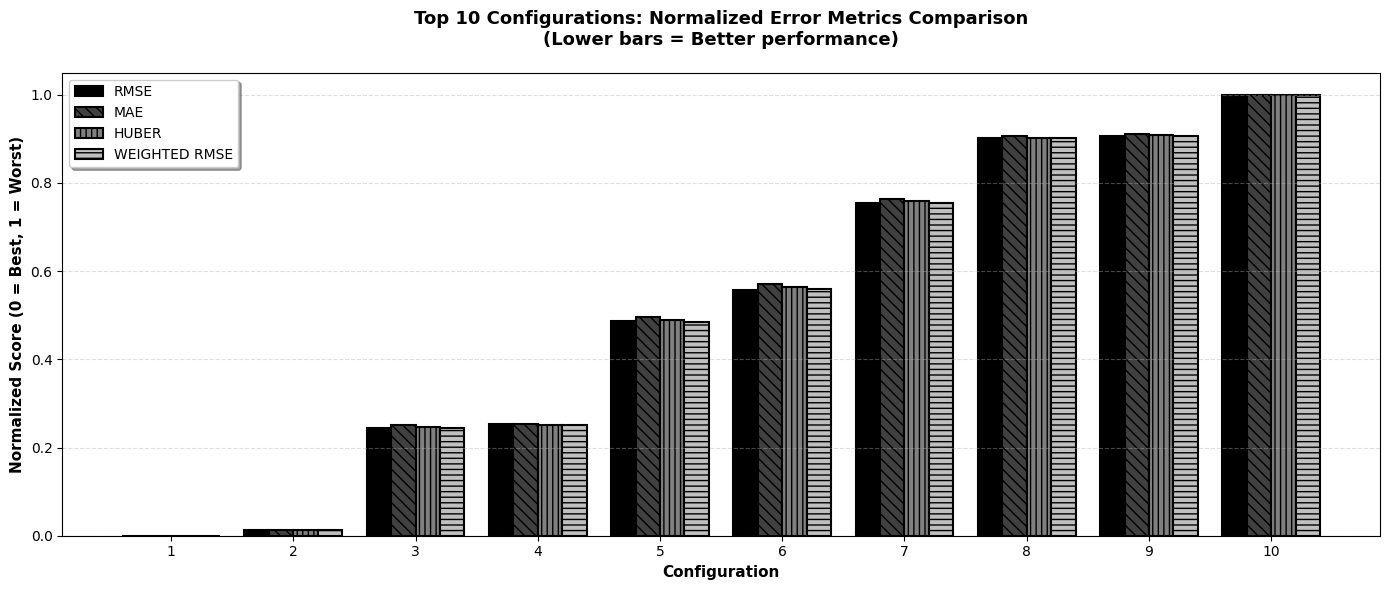


VISUALIZATION 2: Spearman Correlation (Prediction Quality)


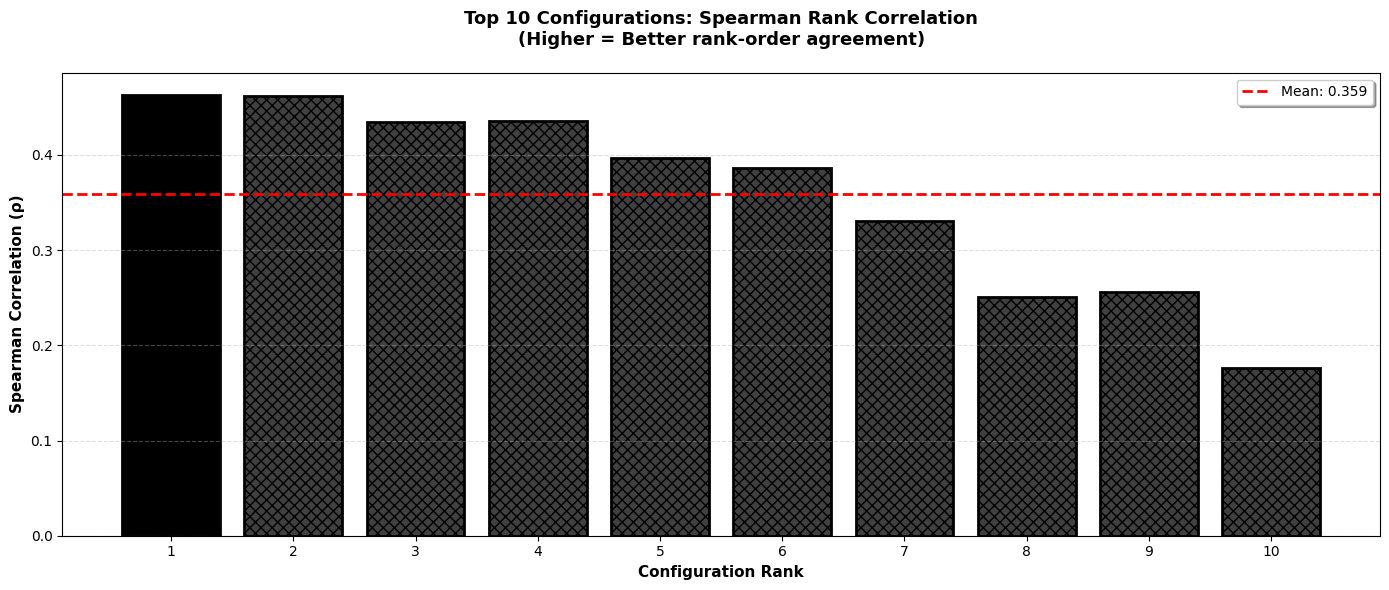


VISUALIZATION 3: Improvement Over Baseline


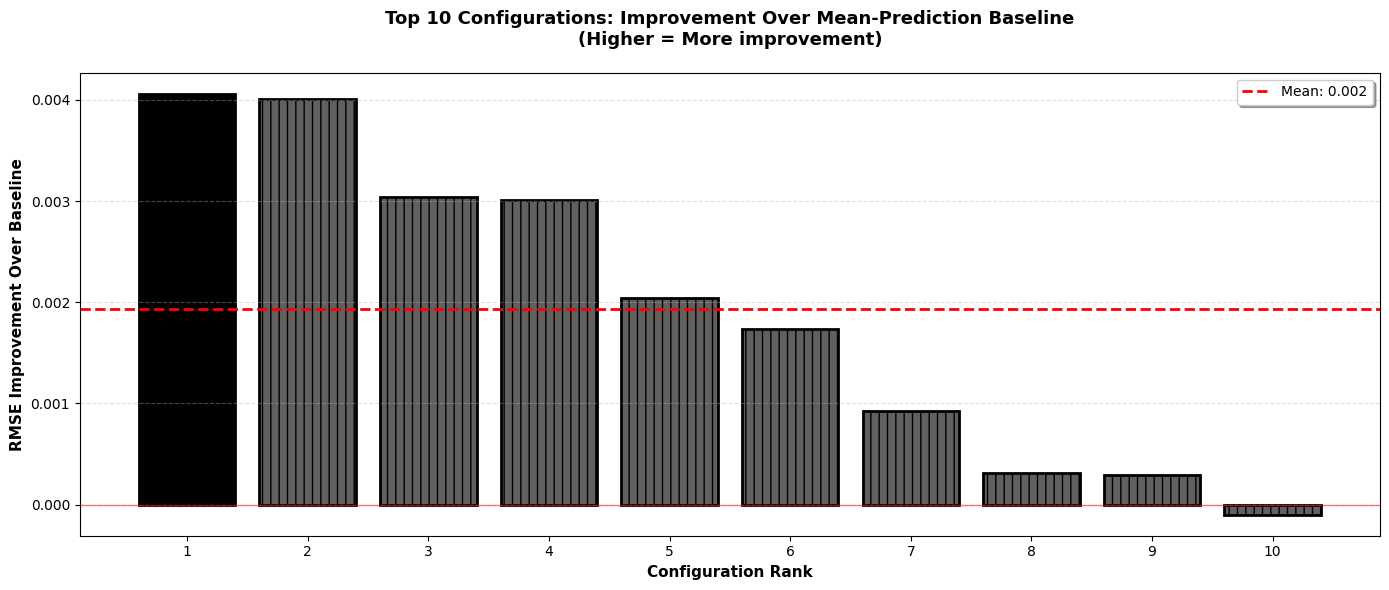


VISUALIZATION 4: Metric Correlation Matrix


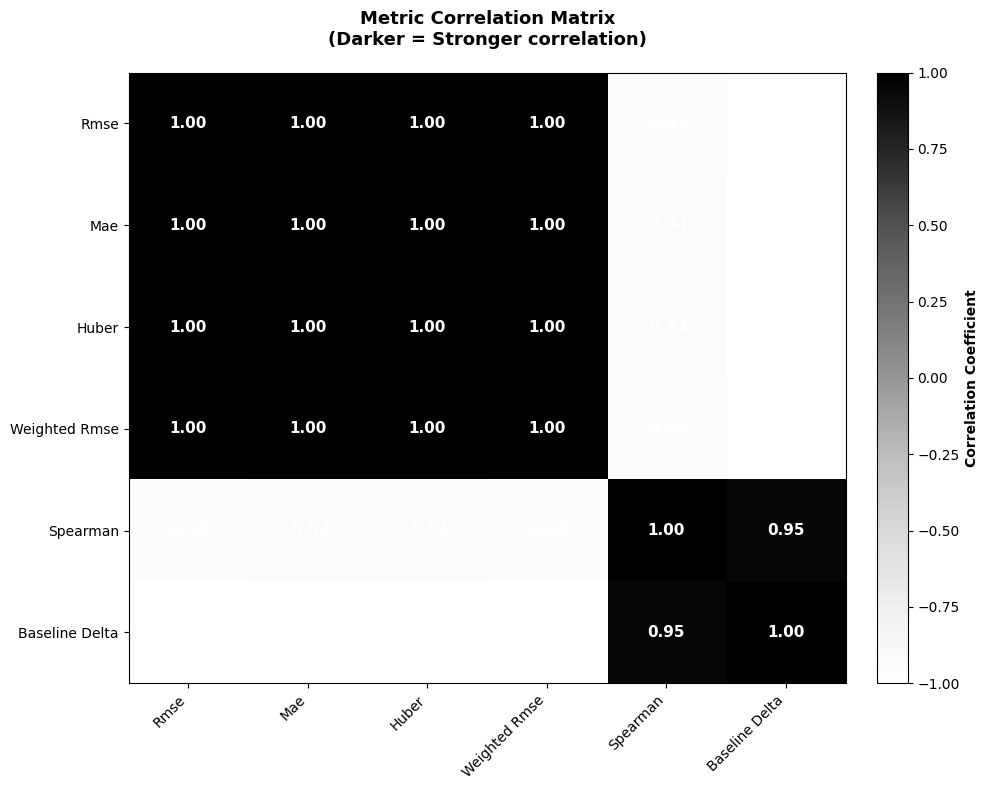


VISUALIZATION 5: Hyperparameter Effects on RMSE


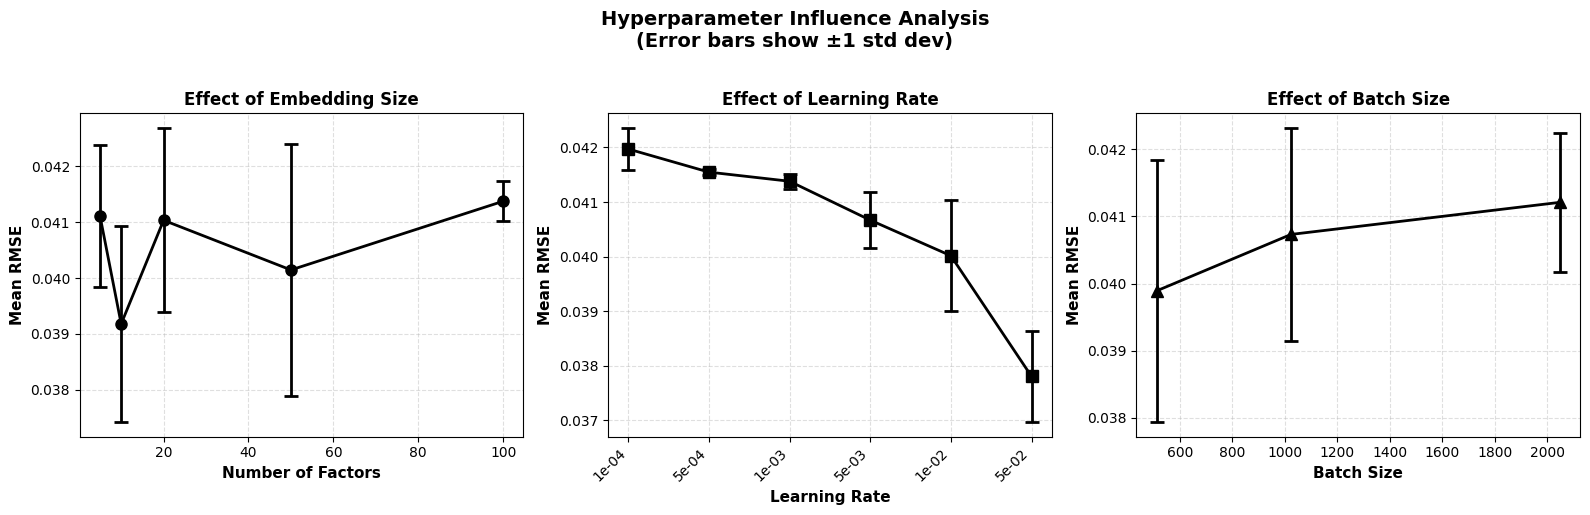


VISUALIZATION 6: RMSE vs Spearman Correlation


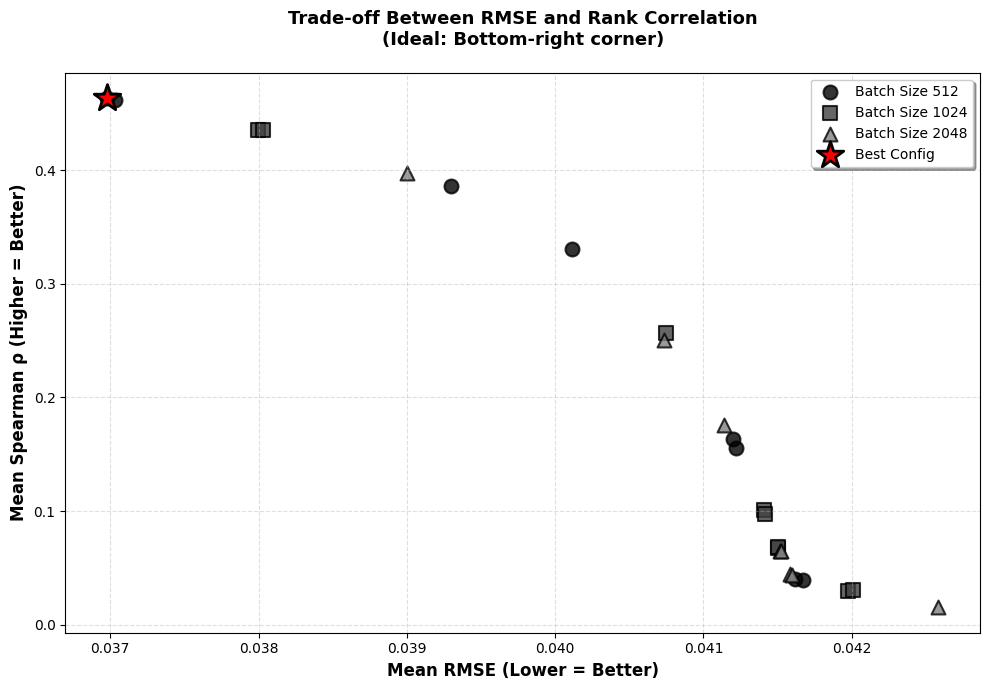


VISUALIZATION 7: Performance Summary Dashboard


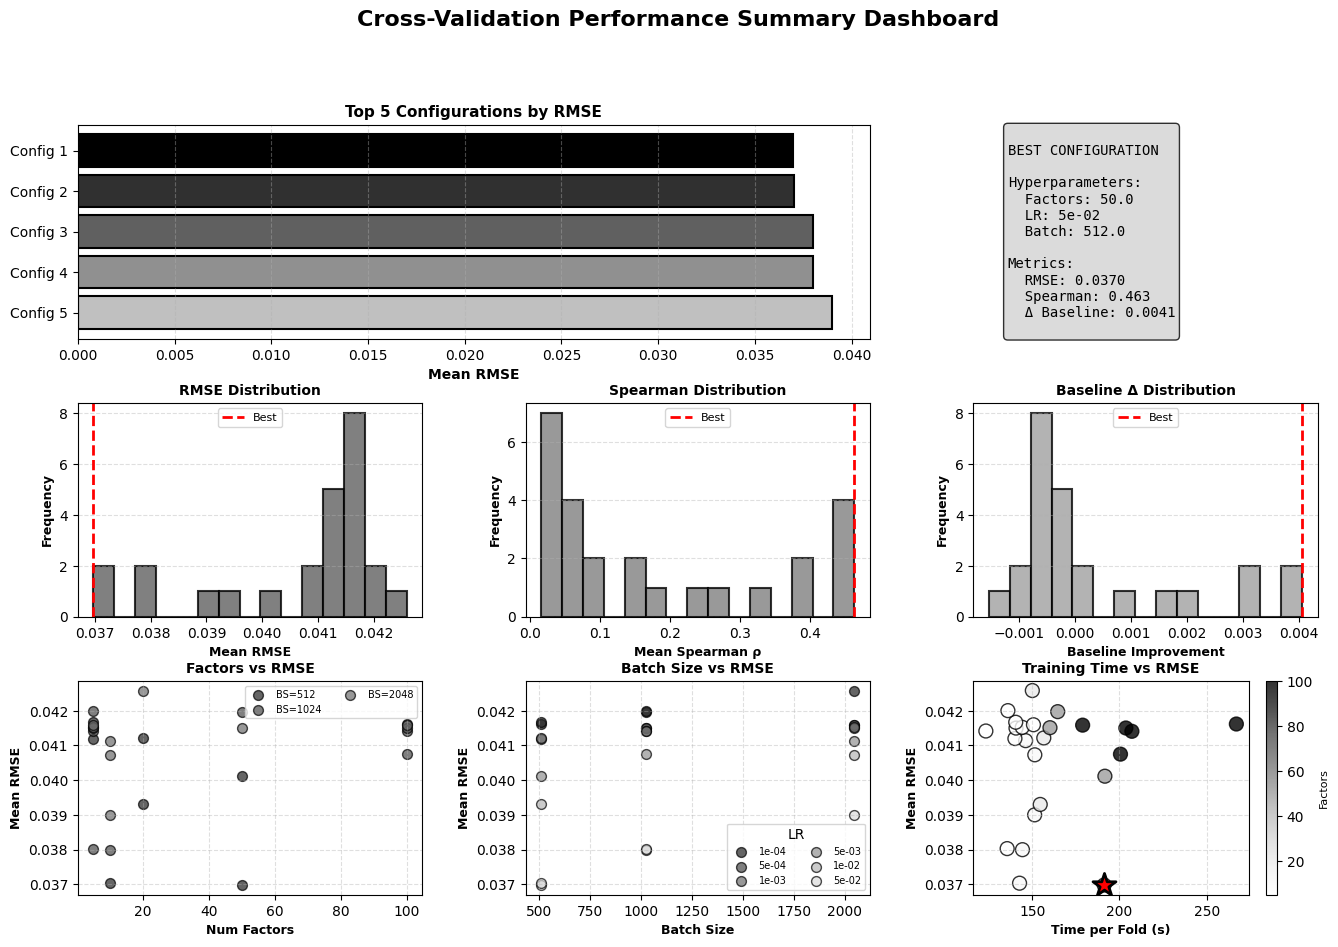


✅ HYPERPARAMETER TUNING & VISUALIZATION COMPLETE


In [30]:
# ========================================
# 6.3 Analyze and Visualize Results
# ========================================
results_df = pd.DataFrame(cv_results)
results_df = results_df.sort_values("mean_rmse", ascending=True)

# Set up colorblind-friendly styling (grayscale + patterns)
plt.style.use('default')
sns.set_palette("gray")

print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS (Top 10)")
print("=" * 60)

# Display top 10 configs with all metrics
display_cols = ['num_factors', 'learning_rate', 'batch_size', 
                'mean_rmse', 'mean_mae', 'mean_huber', 
                'mean_weighted_rmse', 'mean_spearman', 'mean_baseline_delta']
print(results_df[display_cols].head(10).to_string(index=False))

best_params = results_df.iloc[0]
print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS")
print("=" * 60)
print(f"  Num Factors:      {best_params['num_factors']}")
print(f"  Learning Rate:    {best_params['learning_rate']:.6f}")
print(f"  Batch Size:       {best_params['batch_size']}")
print(f"\nPerformance Metrics:")
print(f"  RMSE:             {best_params['mean_rmse']:.4f} ± {best_params['std_rmse']:.4f}")
print(f"  MAE:              {best_params['mean_mae']:.4f}")
print(f"  Huber Loss:       {best_params['mean_huber']:.4f}")
print(f"  Weighted RMSE:    {best_params['mean_weighted_rmse']:.4f}")
print(f"  Spearman ρ:       {best_params['mean_spearman']:.3f}")
print(f"  Baseline Δ:       {best_params['mean_baseline_delta']:.4f}")
print(f"  Time/Fold:        {best_params['mean_time_per_fold']:.1f}s")

# ============================================================
# VISUALIZATION 1: Top 10 Configs - All Metrics Comparison
# ============================================================
print("\n" + "=" * 60)
print("VISUALIZATION 1: Top 10 Configurations - Metric Comparison")
print("=" * 60)

top_10 = results_df.head(10).copy()
top_10['config_label'] = top_10.apply(
    lambda x: f"F{x['num_factors']}_LR{x['learning_rate']:.0e}_B{x['batch_size']}", axis=1
)

# Normalize metrics to 0-1 scale for comparison
metrics_to_plot = ['mean_rmse', 'mean_mae', 'mean_huber', 'mean_weighted_rmse']
top_10_normalized = top_10.copy()
for metric in metrics_to_plot:
    min_val = top_10[metric].min()
    max_val = top_10[metric].max()
    if max_val > min_val:
        top_10_normalized[metric + '_norm'] = (top_10[metric] - min_val) / (max_val - min_val)
    else:
        top_10_normalized[metric + '_norm'] = 0

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(top_10))
width = 0.2

# Use different grayscale shades and hatches for colorblind accessibility
colors = ['#000000', '#404040', '#808080', '#BFBFBF']
hatches = ['///', '\\\\\\', '|||', '---']

for i, metric in enumerate(metrics_to_plot):
    offset = (i - 1.5) * width
    bars = ax.bar(x + offset, top_10_normalized[metric + '_norm'], width,
                   label=metric.replace('mean_', '').replace('_', ' ').upper(),
                   color=colors[i], edgecolor='black', linewidth=1.5, hatch=hatches[i])

ax.set_xlabel('Configuration', fontweight='bold', fontsize=11)
ax.set_ylabel('Normalized Score (0 = Best, 1 = Worst)', fontweight='bold', fontsize=11)
ax.set_title('Top 10 Configurations: Normalized Error Metrics Comparison\n(Lower bars = Better performance)', 
             fontweight='bold', fontsize=13, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(range(1, 11), fontsize=10)
ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# ============================================================
# VISUALIZATION 2: Spearman Correlation - Higher is Better
# ============================================================
print("\n" + "=" * 60)
print("VISUALIZATION 2: Spearman Correlation (Prediction Quality)")
print("=" * 60)

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(range(1, 11), top_10['mean_spearman'], 
               color='#404040', edgecolor='black', linewidth=2, hatch='xxx')

# Highlight the best config
bars[0].set_color('#000000')
bars[0].set_hatch('///')

ax.set_xlabel('Configuration Rank', fontweight='bold', fontsize=11)
ax.set_ylabel('Spearman Correlation (ρ)', fontweight='bold', fontsize=11)
ax.set_title('Top 10 Configurations: Spearman Rank Correlation\n(Higher = Better rank-order agreement)', 
             fontweight='bold', fontsize=13, pad=20)
ax.set_xticks(range(1, 11))
ax.axhline(y=top_10['mean_spearman'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f"Mean: {top_10['mean_spearman'].mean():.3f}")
ax.legend(frameon=True, fancybox=True, shadow=True)
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# ============================================================
# VISUALIZATION 3: Baseline Improvement
# ============================================================
print("\n" + "=" * 60)
print("VISUALIZATION 3: Improvement Over Baseline")
print("=" * 60)

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(range(1, 11), top_10['mean_baseline_delta'], 
               color='#606060', edgecolor='black', linewidth=2, hatch='||')

# Highlight the best config
bars[0].set_color('#000000')
bars[0].set_hatch('\\\\\\')

ax.set_xlabel('Configuration Rank', fontweight='bold', fontsize=11)
ax.set_ylabel('RMSE Improvement Over Baseline', fontweight='bold', fontsize=11)
ax.set_title('Top 10 Configurations: Improvement Over Mean-Prediction Baseline\n(Higher = More improvement)', 
             fontweight='bold', fontsize=13, pad=20)
ax.set_xticks(range(1, 11))
ax.axhline(y=0, color='red', linestyle='-', linewidth=1, alpha=0.5)
ax.axhline(y=top_10['mean_baseline_delta'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f"Mean: {top_10['mean_baseline_delta'].mean():.3f}")
ax.legend(frameon=True, fancybox=True, shadow=True)
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# ============================================================
# VISUALIZATION 4: Metric Correlation Heatmap
# ============================================================
print("\n" + "=" * 60)
print("VISUALIZATION 4: Metric Correlation Matrix")
print("=" * 60)

metric_cols = ['mean_rmse', 'mean_mae', 'mean_huber', 'mean_weighted_rmse', 
               'mean_spearman', 'mean_baseline_delta']
correlation_matrix = results_df[metric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
# Use Greys colormap for true black/white/gray gradient
im = ax.imshow(correlation_matrix, cmap='Greys', aspect='auto', vmin=-1, vmax=1)

# Add gridlines
ax.set_xticks(np.arange(len(metric_cols)))
ax.set_yticks(np.arange(len(metric_cols)))
labels = [col.replace('mean_', '').replace('_', ' ').title() for col in metric_cols]
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(labels, fontsize=10)

# Add correlation values as text
for i in range(len(metric_cols)):
    for j in range(len(metric_cols)):
        text_color = 'white' if correlation_matrix.iloc[i, j] < -0.3 or correlation_matrix.iloc[i, j] > 0.7 else 'black'
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color=text_color, fontweight='bold', fontsize=11)

ax.set_title('Metric Correlation Matrix\n(Darker = Stronger correlation)', 
             fontweight='bold', fontsize=13, pad=20)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

# ============================================================
# VISUALIZATION 5: Hyperparameter Influence on RMSE
# ============================================================
print("\n" + "=" * 60)
print("VISUALIZATION 5: Hyperparameter Effects on RMSE")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Number of Factors
factors_grouped = results_df.groupby('num_factors')['mean_rmse'].agg(['mean', 'std', 'count'])
axes[0].errorbar(factors_grouped.index, factors_grouped['mean'], 
                yerr=factors_grouped['std'], fmt='o-', color='black', 
                linewidth=2, markersize=8, capsize=5, capthick=2)
axes[0].set_xlabel('Number of Factors', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Mean RMSE', fontweight='bold', fontsize=11)
axes[0].set_title('Effect of Embedding Size', fontweight='bold', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.4)

# Learning Rate
lr_grouped = results_df.groupby('learning_rate')['mean_rmse'].agg(['mean', 'std', 'count'])
axes[1].errorbar(range(len(lr_grouped)), lr_grouped['mean'], 
                yerr=lr_grouped['std'], fmt='s-', color='black', 
                linewidth=2, markersize=8, capsize=5, capthick=2)
axes[1].set_xlabel('Learning Rate', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Mean RMSE', fontweight='bold', fontsize=11)
axes[1].set_title('Effect of Learning Rate', fontweight='bold', fontsize=12)
axes[1].set_xticks(range(len(lr_grouped)))
axes[1].set_xticklabels([f'{lr:.0e}' for lr in lr_grouped.index], rotation=45, ha='right')
axes[1].grid(True, linestyle='--', alpha=0.4)

# Batch Size
batch_grouped = results_df.groupby('batch_size')['mean_rmse'].agg(['mean', 'std', 'count'])
axes[2].errorbar(batch_grouped.index, batch_grouped['mean'], 
                yerr=batch_grouped['std'], fmt='^-', color='black', 
                linewidth=2, markersize=8, capsize=5, capthick=2)
axes[2].set_xlabel('Batch Size', fontweight='bold', fontsize=11)
axes[2].set_ylabel('Mean RMSE', fontweight='bold', fontsize=11)
axes[2].set_title('Effect of Batch Size', fontweight='bold', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.4)

plt.suptitle('Hyperparameter Influence Analysis\n(Error bars show ±1 std dev)', 
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ============================================================
# VISUALIZATION 6: RMSE vs Spearman Scatter
# ============================================================
print("\n" + "=" * 60)
print("VISUALIZATION 6: RMSE vs Spearman Correlation")
print("=" * 60)

fig, ax = plt.subplots(figsize=(10, 7))

# Different markers for different batch sizes
batch_sizes = results_df['batch_size'].unique()
markers = ['o', 's', '^', 'D', 'v', 'p', '*']
colors_gray = ['#000000', '#404040', '#808080', '#A0A0A0', '#C0C0C0']

for i, bs in enumerate(sorted(batch_sizes)):
    subset = results_df[results_df['batch_size'] == bs]
    ax.scatter(subset['mean_rmse'], subset['mean_spearman'], 
              s=100, marker=markers[i % len(markers)], 
              color=colors_gray[i % len(colors_gray)], 
              edgecolor='black', linewidth=1.5,
              label=f'Batch Size {bs}', alpha=0.8)

# Highlight best config
ax.scatter(best_params['mean_rmse'], best_params['mean_spearman'], 
          s=400, marker='*', color='red', edgecolor='black', 
          linewidth=2, label='Best Config', zorder=10)

ax.set_xlabel('Mean RMSE (Lower = Better)', fontweight='bold', fontsize=12)
ax.set_ylabel('Mean Spearman ρ (Higher = Better)', fontweight='bold', fontsize=12)
ax.set_title('Trade-off Between RMSE and Rank Correlation\n(Ideal: Bottom-right corner)', 
             fontweight='bold', fontsize=13, pad=20)
ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# ============================================================
# VISUALIZATION 7: Performance Summary Dashboard
# ============================================================
print("\n" + "=" * 60)
print("VISUALIZATION 7: Performance Summary Dashboard")
print("=" * 60)

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Top 5 configs RMSE comparison
ax1 = fig.add_subplot(gs[0, :2])
top_5 = results_df.head(5)
bars = ax1.barh(range(5), top_5['mean_rmse'], color=['#000000', '#303030', '#606060', '#909090', '#C0C0C0'],
                edgecolor='black', linewidth=1.5)
ax1.set_yticks(range(5))
ax1.set_yticklabels([f"Config {i+1}" for i in range(5)], fontsize=10)
ax1.set_xlabel('Mean RMSE', fontweight='bold')
ax1.set_title('Top 5 Configurations by RMSE', fontweight='bold', fontsize=11)
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.4)

# 2. Best config details
ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')
details_text = f"""
BEST CONFIGURATION

Hyperparameters:
  Factors: {best_params['num_factors']}
  LR: {best_params['learning_rate']:.0e}
  Batch: {best_params['batch_size']}

Metrics:
  RMSE: {best_params['mean_rmse']:.4f}
  Spearman: {best_params['mean_spearman']:.3f}
  Δ Baseline: {best_params['mean_baseline_delta']:.4f}
"""
ax2.text(0.1, 0.5, details_text, fontsize=10, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

# 3. RMSE distribution
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(results_df['mean_rmse'], bins=15, color='#606060', 
         edgecolor='black', linewidth=1.5, alpha=0.8)
ax3.axvline(best_params['mean_rmse'], color='red', linestyle='--', 
            linewidth=2, label='Best')
ax3.set_xlabel('Mean RMSE', fontweight='bold', fontsize=9)
ax3.set_ylabel('Frequency', fontweight='bold', fontsize=9)
ax3.set_title('RMSE Distribution', fontweight='bold', fontsize=10)
ax3.legend(fontsize=8)
ax3.grid(axis='y', linestyle='--', alpha=0.4)

# 4. Spearman distribution
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(results_df['mean_spearman'], bins=15, color='#808080', 
         edgecolor='black', linewidth=1.5, alpha=0.8)
ax4.axvline(best_params['mean_spearman'], color='red', linestyle='--', 
            linewidth=2, label='Best')
ax4.set_xlabel('Mean Spearman ρ', fontweight='bold', fontsize=9)
ax4.set_ylabel('Frequency', fontweight='bold', fontsize=9)
ax4.set_title('Spearman Distribution', fontweight='bold', fontsize=10)
ax4.legend(fontsize=8)
ax4.grid(axis='y', linestyle='--', alpha=0.4)

# 5. Baseline delta distribution
ax5 = fig.add_subplot(gs[1, 2])
ax5.hist(results_df['mean_baseline_delta'], bins=15, color='#A0A0A0', 
         edgecolor='black', linewidth=1.5, alpha=0.8)
ax5.axvline(best_params['mean_baseline_delta'], color='red', linestyle='--', 
            linewidth=2, label='Best')
ax5.set_xlabel('Baseline Improvement', fontweight='bold', fontsize=9)
ax5.set_ylabel('Frequency', fontweight='bold', fontsize=9)
ax5.set_title('Baseline Δ Distribution', fontweight='bold', fontsize=10)
ax5.legend(fontsize=8)
ax5.grid(axis='y', linestyle='--', alpha=0.4)

# 6. Num factors vs RMSE
ax6 = fig.add_subplot(gs[2, 0])
for bs in sorted(results_df['batch_size'].unique()):
    subset = results_df[results_df['batch_size'] == bs]
    ax6.scatter(subset['num_factors'], subset['mean_rmse'], 
               label=f'BS={bs}', s=50, edgecolor='black', linewidth=1, alpha=0.7)
ax6.set_xlabel('Num Factors', fontweight='bold', fontsize=9)
ax6.set_ylabel('Mean RMSE', fontweight='bold', fontsize=9)
ax6.set_title('Factors vs RMSE', fontweight='bold', fontsize=10)
ax6.legend(fontsize=7, ncol=2)
ax6.grid(True, linestyle='--', alpha=0.4)

# 7. Learning rate vs RMSE
ax7 = fig.add_subplot(gs[2, 1])
lr_values = sorted(results_df['learning_rate'].unique())
for i, lr in enumerate(lr_values):
    subset = results_df[results_df['learning_rate'] == lr]
    ax7.scatter(subset['batch_size'], subset['mean_rmse'], 
               label=f'{lr:.0e}', s=50, edgecolor='black', linewidth=1, alpha=0.7)
ax7.set_xlabel('Batch Size', fontweight='bold', fontsize=9)
ax7.set_ylabel('Mean RMSE', fontweight='bold', fontsize=9)
ax7.set_title('Batch Size vs RMSE', fontweight='bold', fontsize=10)
ax7.legend(title='LR', fontsize=7, ncol=2)
ax7.grid(True, linestyle='--', alpha=0.4)

# 8. Time vs RMSE
ax8 = fig.add_subplot(gs[2, 2])
scatter = ax8.scatter(results_df['mean_time_per_fold'], results_df['mean_rmse'], 
                     c=results_df['num_factors'], cmap='Greys', 
                     s=100, edgecolor='black', linewidth=1, alpha=0.8)
ax8.scatter(best_params['mean_time_per_fold'], best_params['mean_rmse'], 
           s=300, marker='*', color='red', edgecolor='black', linewidth=2, zorder=10)
ax8.set_xlabel('Time per Fold (s)', fontweight='bold', fontsize=9)
ax8.set_ylabel('Mean RMSE', fontweight='bold', fontsize=9)
ax8.set_title('Training Time vs RMSE', fontweight='bold', fontsize=10)
cbar = plt.colorbar(scatter, ax=ax8)
cbar.set_label('Factors', fontsize=8)
ax8.grid(True, linestyle='--', alpha=0.4)

plt.suptitle('Cross-Validation Performance Summary Dashboard', 
             fontweight='bold', fontsize=16, y=0.995)
plt.show()

print("\n" + "=" * 60)
print("✅ HYPERPARAMETER TUNING & VISUALIZATION COMPLETE")
print("=" * 60)

## Step 6: Hyperparameter Tuning with K-Fold Cross-Validation

Before training the final model, we will perform k-fold cross-validation to find the optimal hyperparameters. This provides a more robust evaluation than a single validation set.

**Process:**
1.  **Subset Data**: We'll use a smaller, representative sample of players to make the tuning process faster.
2.  **K-Fold Split**: The player data will be split into `k` folds. For each fold, we train on `k-1` folds and validate on the remaining one.
3.  **Hyperparameter Search**: We will iterate through different combinations of `NUM_FACTORS`, `LEARNING_RATE`, and `BATCH_SIZE`.
4.  **Aggregate & Evaluate**: We'll average the performance metrics (like RMSE) across all folds for each hyperparameter combination to determine the best set.
5.  **Visualize**: Results will be plotted to visualize the impact of each hyperparameter.

## Step 7: Final Model Training Setup

Now we'll set up the training components for the **final model**: the model instance, optimizer, and learning rate scheduler.

We'll use the best hyperparameters found during cross-validation.

In [ ]:
print("STEP 7: FINAL MODEL TRAINING SETUP")
print("=" * 50)

# ==================================
# Hyperparameters for Final Training
# ==================================
# These would be set by the results from the CV step.
# For now, we'll use the initial defaults.
NUM_FACTORS = 50
LEARNING_RATE = 0.01
BATCH_SIZE = 1024
NUM_EPOCHS = 20

# ==================================
# Model Instantiation
# ==================================
final_model = ChessOpeningRecommender(
    num_players=NUM_PLAYERS,
    num_openings=NUM_OPENINGS,
    num_factors=NUM_FACTORS,
    player_ratings=player_ratings_tensor,
    opening_eco_letters=opening_eco_letter_tensor,
    opening_eco_numbers=opening_eco_number_tensor,
    num_eco_letters=NUM_ECO_LETTERS,
    num_eco_numbers=NUM_ECO_NUMBERS
).to(DEVICE)

# ==================================
# Optimizer
# ==================================
# We'll use SGD with momentum, a classic choice for matrix factorization.
optimizer = torch.optim.SGD(final_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# ==================================
# Learning Rate Scheduler
# ==================================
# Reduces the learning rate when a metric has stopped improving.
# This helps to fine-tune the model in the later stages of training.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # The scheduler will step when the quantity monitored has stopped decreasing
    factor=0.1,      # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=2,      # Number of epochs with no improvement after which learning rate will be reduced
    verbose=True     # If True, prints a message to stdout for each update
)

# ==================================
# Checkpoint and Model Save Paths
# ==================================
CHECKPOINT_DIR = "data/models"
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "best_model.pt")

# Ensure the directory exists
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"Final model hyperparameters:")
print(f"  - Device: {DEVICE}")
print(f"  - Num Factors: {NUM_FACTORS}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Num Epochs: {NUM_EPOCHS}")
print(f"\nModel, optimizer, and scheduler initialized.")
print(f"Checkpoints will be saved in: '{CHECKPOINT_DIR}'")
print(f"Best model will be saved to: '{BEST_MODEL_PATH}'")
print("\n" + "=" * 50)
print("✅ SETUP COMPLETE")
print("=" * 50)

## Step 8: Final Model Training Loop

Here's the main training loop for the final model. We'll iterate for a specified number of epochs, training the model and evaluating its performance on the validation set periodically. We'll also save checkpoints.

In [ ]:
import time
from collections import defaultdict

print("STEP 8: TRAINING THE FINAL MODEL")
print("=" * 50)

# ==================================
# Training State Tracking
# ==================================
history = defaultdict(list)
best_val_rmse = float('inf')
epochs_since_improvement = 0

# ==================================
# Main Training Loop
# ==================================
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    
    # --- Training Phase ---
    train_loss, train_rmse = train_one_epoch(final_model, train_loader, optimizer, DEVICE, epoch)
    
    # --- Validation Phase ---
    val_loss, val_rmse = evaluate_model(final_model, val_loader, DEVICE)
    
    # --- Learning Rate Scheduler Step ---
    scheduler.step(val_rmse)
    
    # --- Logging ---
    history['train_loss'].append(train_loss)
    history['train_rmse'].append(train_rmse)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)
    
    epoch_duration = time.time() - epoch_start_time
    
    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f} | "
          f"Duration: {epoch_duration:.2f}s")

    # --- Checkpoint Saving ---
    # Save a checkpoint every epoch
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"checkpoint_epoch_{epoch:03d}.pt")
    torch.save({
        'epoch': epoch,
        'model_state_dict': final_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_rmse': val_rmse,
    }, checkpoint_path)
    
    # Save the best model based on validation RMSE
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        epochs_since_improvement = 0
        torch.save(final_model.state_dict(), BEST_MODEL_PATH)
        print(f"  -> New best model saved with Val RMSE: {val_rmse:.4f}")
    else:
        epochs_since_improvement += 1

# ==================================
# Post-Training Summary
# ==================================
print("\n" + "=" * 50)
print("✅ FINAL TRAINING COMPLETE")
print("=" * 50)
print(f"Best Validation RMSE: {best_val_rmse:.4f}")
print(f"Best model saved to: '{BEST_MODEL_PATH}'")
print(f"Last checkpoint saved to: '{checkpoint_path}'")